---
# Análisis de la Demanda Internacional
---



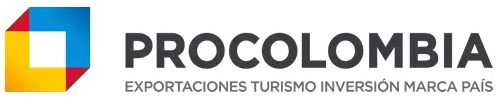

#### Objetivo de Proyecto

* Desarrollar un tablero que compile de forma automatizada indicadores de comercio internacional sobre la demanda de productos no minero-energéticos en diferentes mercados del mundo.

* Desarrollar un algoritmo que clasifique el potencial exportador para Colombia en cuanto al mercado y productos no minero-energéticos.


#### Metodología

- Se utiliza los datos de Procolombia ([*Trademap*](https://www.trademap.org/Index.aspx?lang=es)) de las exportaciones e importaciones realizadas por Colombia y de los demás países del mundo. Los datasets se componen de archivos planos por cada país que contienen información de códigos de productos de clasificación arancelarios HS6 y valor en USD de exportaciones e importaciones.

- Se desarrolla un ETL para el procesamiento de los datos para generar la plantilla que despliega el tablero.


- Se utiliza la librería Tableau para generar el archivo en formato hyper y el desarrollo del tablero.


Archivos de datos que son tablas de referencias:


- Códigos de productos de [clasificación arancelarios HS6](https://www.trademap.org/Index.aspx?lang=es)  (*Sectorización_HS6_20231005_uversion.xlsx*)

- [Códigos *ISO2*](https://uiaf.gov.co/sites/default/files/2022-06/documentos/archivos-anexos/Codigos%20paises%20ISO%203166Act.xlsx) de los países (*Codigos paises ISO 3166Act.xlsx*)


- [GeoDist](http://www.cepii.fr/CEPII/fr/bdd_modele/bdd_modele_item.asp?id=6) proporciona variables geográficas: (*geo_cepii.xlsx*)


| Variables | Formato | Definición ||
| --- | --- | --- | --- |
|Código del producto        |  string | Código HS6 para productos|
|país                       |  string |país donde se realizo la exportanción|
|año                      |  string |periodo en años entre 2018 a 2022|
|País Importa desde el mundo|  entero  |valor importado por país|
|exportación real           |  entero  |valor de exportación de Colombia |
|potencial exportación      |  entero  |Valor importado por país|
|País exporta hacia el mundo|  entero  |valor exportado por los países|
|cadena productiva          |  string | segmento de los productos|
|iso3                       |  string | código internacional de países|
|continent                  |  string | continente|
|dist                       |  decimal| distancia en kilometros|
|acuerdo                    |  string |acuerdos comerciales|
|elasticidad                |  string |elasticidad por arancel de los productos|
|pib_per                    |  string |Variación del producto interno bruta per capita|
|ipc                        |  string |Variación del Indice del precio al Consumidor|
|product_export             |  string |producto exportado por Colombia|

## Instalacción de Librerías

In [ ]:
# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# Importar librerias generales
import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
import io
import time
import sklearn.impute


from google.colab import files



#import modelos y métricas

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm


from sklearn.impute import KNNImputer
from sklearn.metrics import pairwise_distances

# manipulación y visualización

import seaborn as sns



import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline


from collections import Counter

import scipy
from pylab import rcParams


import plotly
import plotly.graph_objs as go
import plotly.express as px


plt.rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = 10, 5# Golden Mean


In [ ]:
#Libreria de Tableu para generar el hyper para el tablero

!pip install tableauhyperapi
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.7 MB/s eta 0:00:00


## Consulta de datos

La consulta se realiza sobre el dataset consolidado de la ETL para tableau.

In [ ]:
#Datasets en drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = '/content/drive/MyDrive/project_procolombia/Files/Resultados/results.csv'

In [ ]:
dfa= pd.read_csv(file, sep=',', encoding='utf-8')

In [ ]:
dfa.head(2)


Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   

   Colombia exporta hacia País  País Importa desde el mundo  \
0                            0                        15561   
1                            0                         2771   

   Colombia importa desde el mundo  Colombia importa desde País  \
0                              522                            0   
1                              590                            0   

   País exporta hacia el mundo                                   SubPartida  \
0                            0  Subpartida 010121 Descripción no disponible   
1                            0  Subpartida 010121 Descripción no disponible   

   ... city_en       lat   lon  cap maincity  langoff_1  \
0  ...   Kabul  34.51667  69.2  1.0      1.0    Persian   
1  ...   Kabul  34.51667  69.2  1.0      1.0    Persian   

                           descripción  potencial sin explotar restante  \
0  Caballos reproductores de raza pura                            15561   
1  Caballos reproductores de raza pura                             2771   

   exportación real potencial exportación  
0                 0                 15561  
1                 0                  2771  

[2 rows x 30 columns]

In [ ]:
# Crea la variable dummy para el páis que exporta a demás países del mundo.
dfa['product_export'] = dfa['Colombia exporta hacia País'].apply(lambda x: 'no' if x == 0 else 'si')

In [ ]:
#Se valida los acuerdos
dfa['product_export'].value_counts(dropna=False)

product_export
no    4425811
si     125264
Name: count, dtype: int64

In [ ]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 31 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Código del producto              int64  
 1   país                             object 
 2   años                             int64  
 3   Colombia exporta al mundo        int64  
 4   Colombia exporta hacia País      int64  
 5   País Importa desde el mundo      int64  
 6   Colombia importa desde el mundo  int64  
 7   Colombia importa desde País      int64  
 8   País exporta hacia el mundo      int64  
 9   SubPartida                       object 
 10  Cadena productiva                object 
 11  Sector                           object 
 12  Subsector                        object 
 13  iso2                             object 
 14  iso3                             object 
 15  cnum                             float64
 16  country                          object 
 17  area    

In [ ]:
dfb=dfa.drop(['Colombia exporta hacia País', 'Colombia importa desde País','cnum','iso2',
                'SubPartida','potencial sin explotar restante','Sector','Subsector','dis_int',
             'iso2','cnum','country','area','city_en','lat','lon','cap','maincity','langoff_1','descripción',], axis=1)

In [ ]:
iso_data = dfb[['iso3', 'país']]

# Eliminar duplicados
iso_data = iso_data.drop_duplicates()

In [ ]:
dfb.head(3)

Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   
2                10121  Afganistan  2020                        322   

   País Importa desde el mundo  Colombia importa desde el mundo  \
0                        15561                              522   
1                         2771                              590   
2                            0                              703   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   
2                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export  
0                 0                  15561             no  
1                 0                   2771             no  
2                 0                      0             no

In [ ]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 13 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   Código del producto              int64 
 1   país                             object
 2   años                             int64 
 3   Colombia exporta al mundo        int64 
 4   País Importa desde el mundo      int64 
 5   Colombia importa desde el mundo  int64 
 6   País exporta hacia el mundo      int64 
 7   Cadena productiva                object
 8   iso3                             object
 9   continent                        object
 10  exportación real                 int64 
 11  potencial exportación            int64 
 12  product_export                   object
dtypes: int64(8), object(5)
memory usage: 451.4+ MB


Ahora se cruza el archivo de la distancia

In [ ]:
# se corrige el iso de los países
dfb.loc[dfb['país'] == "Serbia", 'iso3'] = "SRB"
dfb.loc[dfb['país'] == "Montenegro", 'iso3'] = "MNE"

In [ ]:
file = '/content/drive/MyDrive/project_procolombia/Files/Paises/dist_cepii.xls'

In [ ]:
dist = pd.read_excel(file)

In [ ]:
dist = dist[dist['iso_o'] == 'COL']

In [ ]:
dist=dist.drop(['iso_o', 'contig','comlang_off','comlang_ethno','colony','comcol','curcol','col45','smctry','distcap','distw','distwces'], axis=1)

In [ ]:
dist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 9408 to 9631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iso_d   224 non-null    object 
 1   dist    224 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.2+ KB


In [ ]:
merged_df = pd.merge(dfb, dist, left_on='iso3', right_on='iso_d', how='left')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 15 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Código del producto              int64  
 1   país                             object 
 2   años                             int64  
 3   Colombia exporta al mundo        int64  
 4   País Importa desde el mundo      int64  
 5   Colombia importa desde el mundo  int64  
 6   País exporta hacia el mundo      int64  
 7   Cadena productiva                object 
 8   iso3                             object 
 9   continent                        object 
 10  exportación real                 int64  
 11  potencial exportación            int64  
 12  product_export                   object 
 13  iso_d                            object 
 14  dist                             float64
dtypes: float64(1), int64(8), object(6)
memory usage: 520.8+ MB


In [ ]:
# Revisar
iso_data = merged_df[['iso3', 'iso_d','país']]

# Eliminar duplicados
iso_data = iso_data.drop_duplicates()

iso_data_excel = "iso_data.xlsx"

# Exporta el DataFrame a un archivo de Excel sin el índice
#iso_data.to_excel(iso_data_excel, index=False)

In [ ]:
merged_df.drop('iso_d', axis=1, inplace=True)

In [ ]:
# Reemplazar NaN y valores infinitos con cero
merged_df['dist'] = merged_df['dist'].fillna(0)

# Convertir la columna a tipo entero
merged_df['dist'] = merged_df['dist'].astype(int)

Se completa datos faltantes de la variable distancia, se evidencia que tres países con código ISO = ['CUW', 'MNE', 'SRB'] no presentan la distancia. Se valida en [Distancias entre páises](https://www.geodatos.net/distancias/paises#google_vignette) para completar esta información.

In [ ]:
# Lista de nombres de los países
#paises = ['CUW', 'MNE', 'SRB']

# Valores de reemplazo para cada país
valores_reemplazo = {
    'CUW': 1023.0,
    'SRB': 10084.0,
    'MNE': 9969.0}

# Se reemplaza ceros en la columna "dist" según el país
def reemplazar_dist(row):
    iso3 = row['iso3']
    if iso3 in valores_reemplazo:
        if row['dist'] == 0:
            return valores_reemplazo[iso3]
    return row['dist']

# Se aplica la función a cada fila del dataFrame
merged_df['dist'] = merged_df.apply(reemplazar_dist, axis=1)

In [ ]:
#  Se valida la completitud de información de las distancias entre países.
agr = merged_df[['iso3','dist']].groupby('iso3').count()
agr = agr.reset_index()

Ahora se cruza el archivo de los acuerdos:

In [ ]:
file= '/content/drive/MyDrive/project_procolombia/Files/Paises/acuerdos.xlsx'

In [ ]:
acuerdos = pd.read_excel(file)

In [ ]:
merged_df = pd.merge(merged_df , acuerdos, left_on='iso3', right_on='iso3', how='left')

In [ ]:
merged_df.drop('pais', axis=1, inplace=True)

In [ ]:
merged_df.head(3)

Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   
2                10121  Afganistan  2020                        322   

   País Importa desde el mundo  Colombia importa desde el mundo  \
0                        15561                              522   
1                         2771                              590   
2                            0                              703   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   
2                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export     dist acuerdo  
0                 0                  15561             no  14288.0     NaN  
1                 0                   2771             no  14288.0     NaN  
2                 0                      0             no  14288.0     NaN

In [ ]:
merged_df['acuerdo'] = merged_df['acuerdo'].fillna('no')

In [ ]:
#Se valida los acuerdos
merged_df['acuerdo'].value_counts(dropna=False)

acuerdo
no    3000150
si    1550925
Name: count, dtype: int64

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 15 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Código del producto              int64  
 1   país                             object 
 2   años                             int64  
 3   Colombia exporta al mundo        int64  
 4   País Importa desde el mundo      int64  
 5   Colombia importa desde el mundo  int64  
 6   País exporta hacia el mundo      int64  
 7   Cadena productiva                object 
 8   iso3                             object 
 9   continent                        object 
 10  exportación real                 int64  
 11  potencial exportación            int64  
 12  product_export                   object 
 13  dist                             float64
 14  acuerdo                          object 
dtypes: float64(1), int64(8), object(6)
memory usage: 520.8+ MB


Ahora se cruza el archivo de la elasticidad:

In [ ]:
file= '/content/drive/MyDrive/project_procolombia/Files/Paises/elasticidad_v2.xlsx'

In [ ]:
elasticidad = pd.read_excel(file)

In [ ]:
elasticidad=elasticidad.drop(['epsilon', 'positive','missing','epsilon_pt','positive_pt'], axis=1)

In [ ]:
elasticidad.head(2)

HS6  zero
0  10110     1
1  10190     1

In [ ]:
elasticidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   HS6     5050 non-null   int64
 1   zero    5050 non-null   int64
dtypes: int64(2)
memory usage: 79.0 KB


In [ ]:
#Se valida los acuerdos
elasticidad['zero'].value_counts(dropna=False)

zero
0    2934
1    2116
Name: count, dtype: int64

In [ ]:
mapeo = {0: "no sign", 1: "sign"}

In [ ]:
elasticidad['zero'] = elasticidad['zero'].replace(mapeo)

In [ ]:
#Se valida los acuerdos
elasticidad['zero'].value_counts(dropna=False)

zero
no sign    2934
sign       2116
Name: count, dtype: int64

In [ ]:
merged_df2 = pd.merge(merged_df , elasticidad, left_on='Código del producto', right_on='HS6', how='left')

In [ ]:
merged_df2['zero'] = merged_df2['zero'].fillna('no sign')

In [ ]:
merged_df2['zero'].value_counts(dropna=False)

zero
no sign    2940075
sign       1611000
Name: count, dtype: int64

In [ ]:
merged_df2 = merged_df2.rename(columns={'zero': 'elasticidad'})

In [ ]:
merged_df2=merged_df2.drop(['HS6'], axis=1)

Ahora se cruza los indicadores financieros PIB

In [ ]:
file= '/content/drive/MyDrive/project_procolombia/Files/Paises/pib.xlsx'

In [ ]:
pib = pd.read_excel(file)

In [ ]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   años          1330 non-null   int64  
 1   Country Name  1330 non-null   object 
 2   Country Code  1330 non-null   object 
 3   pib_per%      1267 non-null   float64
 4   pib_per       1330 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 52.1+ KB


In [ ]:
# Juntar las dos columnas usando el método concat()
pib['año_iso'] = pd.concat([pib['años'].astype(str), pib['Country Code']], axis=1).agg('-'.join, axis=1)

In [ ]:
pib

años                 Country Name Country Code  pib_per%   pib_per  \
0     2018                  Afghanistan          AFG -1.688577  negativa   
1     2018  Africa Eastern and Southern          AFE -0.191859  negativa   
2     2018   Africa Western and Central          AFW  0.165181  positiva   
3     2018                      Albania          ALB  4.276312  positiva   
4     2018                      Algeria          DZA -0.707950  negativa   
...    ...                          ...          ...       ...       ...   
1325  2022           West Bank and Gaza          PSE  1.442371  positiva   
1326  2022                        World          WLD  2.277195  positiva   
1327  2022                  Yemen, Rep.          YEM       NaN  negativa   
1328  2022                       Zambia          ZMB  2.386469  positiva   
1329  2022                     Zimbabwe          ZWE  4.387997  positiva   

       año_iso  
0     2018-AFG  
1     2018-AFE  
2     2018-AFW  
3     2018-ALB  
4     2018-DZA  
...        ...  
1325  2022-PSE  
1326  2022-WLD  
1327  2022-YEM  
1328  2022-ZMB  
1329  2022-ZWE  

[1330 rows x 6 columns]

In [ ]:
pib=pib.drop(['Country Name', 'pib_per%','Country Code','años'], axis=1)

In [ ]:
merged_df2['año_iso'] = pd.concat([merged_df2['años'].astype(str), merged_df2['iso3']], axis=1).agg('-'.join, axis=1)

In [ ]:
merged_df2.head(2)

Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   

   País Importa desde el mundo  Colombia importa desde el mundo  \
0                        15561                              522   
1                         2771                              590   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export     dist acuerdo  \
0                 0                  15561             no  14288.0      no   
1                 0                   2771             no  14288.0      no   

  elasticidad   año_iso  
0     no sign  2018-AFG  
1     no sign  2019-AFG

In [ ]:
pib.head(2)

pib_per   año_iso
0  negativa  2018-AFG
1  negativa  2018-AFE

In [ ]:
merged_df3 = pd.merge(merged_df2, pib, left_on='año_iso', right_on='año_iso', how='left')

In [ ]:
merged_df3.head(2)

Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   

   País Importa desde el mundo  Colombia importa desde el mundo  \
0                        15561                              522   
1                         2771                              590   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export     dist acuerdo  \
0                 0                  15561             no  14288.0      no   
1                 0                   2771             no  14288.0      no   

  elasticidad   año_iso   pib_per  
0     no sign  2018-AFG  negativa  
1     no sign  2019-AFG  positiva

In [ ]:
merged_df3['pib_per'] = merged_df3['pib_per'].fillna('negativa')

In [ ]:
merged_df3['pib_per'].value_counts(dropna=False)

pib_per
positiva    2842515
negativa    1708560
Name: count, dtype: int64

Ahora se cruza los indicadores financieros IPC

In [ ]:
file= '/content/drive/MyDrive/project_procolombia/Files/Paises/ipc.xlsx'

In [ ]:
ipc = pd.read_excel(file)

In [ ]:
# Juntar las dos columnas usando el método concat()
ipc['año_iso'] = pd.concat([ipc['años'].astype(str), ipc['Country Code']], axis=1).agg('-'.join, axis=1)

In [ ]:
ipc

años                 Country Name Country Code        ipc%       ipc  \
0     2018                  Afghanistan          AFG    0.626149  positiva   
1     2018  Africa Eastern and Southern          AFE    4.720811  positiva   
2     2018   Africa Western and Central          AFW    1.784050  positiva   
3     2018                      Albania          ALB    2.028060  positiva   
4     2018                      Algeria          DZA    4.269990  positiva   
...    ...                          ...          ...         ...       ...   
1325  2022           West Bank and Gaza          PSE    3.741224  positiva   
1326  2022                        World          WLD    7.967574  positiva   
1327  2022                  Yemen, Rep.          YEM         NaN  negativa   
1328  2022                       Zambia          ZMB   10.993204  positiva   
1329  2022                     Zimbabwe          ZWE  104.705171  positiva   

       año_iso  
0     2018-AFG  
1     2018-AFE  
2     2018-AFW  
3     2018-ALB  
4     2018-DZA  
...        ...  
1325  2022-PSE  
1326  2022-WLD  
1327  2022-YEM  
1328  2022-ZMB  
1329  2022-ZWE  

[1330 rows x 6 columns]

In [ ]:
ipc=ipc.drop(['Country Name', 'ipc%','Country Code','años'], axis=1)

In [ ]:
ipc

ipc   año_iso
0     positiva  2018-AFG
1     positiva  2018-AFE
2     positiva  2018-AFW
3     positiva  2018-ALB
4     positiva  2018-DZA
...        ...       ...
1325  positiva  2022-PSE
1326  positiva  2022-WLD
1327  negativa  2022-YEM
1328  positiva  2022-ZMB
1329  positiva  2022-ZWE

[1330 rows x 2 columns]

In [ ]:
merged_df4 = pd.merge(merged_df3, ipc, left_on='año_iso', right_on='año_iso', how='left')

In [ ]:
merged_df4.head(2)

Código del producto        país  años  Colombia exporta al mundo  \
0                10121  Afganistan  2018                       1033   
1                10121  Afganistan  2019                        372   

   País Importa desde el mundo  Colombia importa desde el mundo  \
0                        15561                              522   
1                         2771                              590   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export     dist acuerdo  \
0                 0                  15561             no  14288.0      no   
1                 0                   2771             no  14288.0      no   

  elasticidad   año_iso   pib_per       ipc  
0     no sign  2018-AFG  negativa  positiva  
1     no sign  2019-AFG  positiva  positiva

In [ ]:
merged_df4['ipc'] = merged_df4['ipc'].fillna('negativa')

In [ ]:
merged_df4['ipc'].value_counts(dropna=False)

ipc
positiva    3584925
negativa     966150
Name: count, dtype: int64

In [ ]:
merged_df4=merged_df4.drop(['Colombia exporta al mundo', 'Colombia importa desde el mundo','año_iso'], axis=1)

In [ ]:
merged_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Código del producto          int64  
 1   país                         object 
 2   años                         int64  
 3   País Importa desde el mundo  int64  
 4   País exporta hacia el mundo  int64  
 5   Cadena productiva            object 
 6   iso3                         object 
 7   continent                    object 
 8   exportación real             int64  
 9   potencial exportación        int64  
 10  product_export               object 
 11  dist                         float64
 12  acuerdo                      object 
 13  elasticidad                  object 
 14  pib_per                      object 
 15  ipc                          object 
dtypes: float64(1), int64(6), object(9)
memory usage: 555.6+ MB


Se guarda archivo de datos procesados con los datos en general.

In [ ]:
#folderResults = '/content/drive/MyDrive/project_procolombia/Files/Resultados/'

In [ ]:
#merged_df4.to_csv(folderResults + 'datos.csv', index=False)

In [ ]:
#file = '/content/drive/MyDrive/project_procolombia/Files/Resultados/results.csv'

In [ ]:
file = '/content/drive/MyDrive/project_procolombia/Files/Resultados/datos.csv'

In [ ]:
df1 = pd.read_csv(file, sep=',', encoding='utf-8')

In [ ]:
df1['Código del producto']=df1['Código del producto'].astype('object')
df1['años']=df1['años'].astype('object')

In [ ]:
df1.head(2)

Código del producto        país  años  País Importa desde el mundo  \
0               10121  Afganistan  2018                        15561   
1               10121  Afganistan  2019                         2771   

   País exporta hacia el mundo Cadena productiva iso3 continent  \
0                            0     Agroalimentos  AFG      Asia   
1                            0     Agroalimentos  AFG      Asia   

   exportación real  potencial exportación product_export     dist acuerdo  \
0                 0                  15561             no  14288.0      no   
1                 0                   2771             no  14288.0      no   

  elasticidad   pib_per       ipc  
0     no sign  negativa  positiva  
1     no sign  positiva  positiva

Selección de variables de manera preliminar.

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 16 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Código del producto          object 
 1   país                         object 
 2   años                         object 
 3   País Importa desde el mundo  int64  
 4   País exporta hacia el mundo  int64  
 5   Cadena productiva            object 
 6   iso3                         object 
 7   continent                    object 
 8   exportación real             int64  
 9   potencial exportación        int64  
 10  product_export               object 
 11  dist                         float64
 12  acuerdo                      object 
 13  elasticidad                  object 
 14  pib_per                      object 
 15  ipc                          object 
dtypes: float64(1), int64(4), object(11)
memory usage: 555.6+ MB


## **Calidad de datos**

In [ ]:
# Identificamos el número de missing values en cada columna
# https://www.geeksforgeeks.org/python-pandas-isnull-and-notnull/

total = df1.isnull().sum().sort_values(ascending=False)
percent = (df1.isnull().sum()/df1['país'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(44)

Total  Percent
Código del producto              0      0.0
país                             0      0.0
años                             0      0.0
País Importa desde el mundo      0      0.0
País exporta hacia el mundo      0      0.0
Cadena productiva                0      0.0
iso3                             0      0.0
continent                        0      0.0
exportación real                 0      0.0
potencial exportación            0      0.0
product_export                   0      0.0
dist                             0      0.0
acuerdo                          0      0.0
elasticidad                      0      0.0
pib_per                          0      0.0
ipc                              0      0.0

Se presenta datos faltantes en la variable distancia (dist).

## Preparación de datos

Se renombran variables.

In [ ]:
df1 = df1.rename(columns={'exportación real': 'exportación_real'})
df1 = df1.rename(columns={'País exporta hacia el mundo': 'País_exporta_mundo'})
df1 = df1.rename(columns={'País Importa desde el mundo': 'País_importa_mundo'})
df1 = df1.rename(columns={'Código del producto': 'producto'})
df1 = df1.rename(columns={'Cadena productiva': 'cadena'})

In [ ]:
## Se genera copia de dataframe por los cambios realizados.
dft2=df1

Se cambia el formato de la variable años y se genera variables dummy.

In [ ]:
# Se cambia formato de la variable años a string
dft2['años'] = dft2['años'].astype(str)

In [ ]:
#Se valida los productos exportados entre colombia y demás países
dft2['product_export'].value_counts(dropna=False)

product_export
no    4425811
si     125264
Name: count, dtype: int64

In [ ]:
# Crea la variable dummy para el páis que exporta a demás países del mundo.
dft2['pais_export'] = dft2['País_exporta_mundo'].apply(lambda x: 'no' if x == 0 else 'si')

In [ ]:
# Se valida la variable creada

dft2['pais_export'].value_counts(dropna=False)

pais_export
no    2665093
si    1885982
Name: count, dtype: int64

In [ ]:
# se valida la variable acuerdos comerciales
dft2['acuerdo'].value_counts(dropna=False)

acuerdo
no    3000150
si    1550925
Name: count, dtype: int64

In [ ]:
# Se valida los cambios realizados en la estructura de los datos
dft2.head(2)

producto        país  años  País_importa_mundo  País_exporta_mundo  \
0    10121  Afganistan  2018               15561                   0   
1    10121  Afganistan  2019                2771                   0   

          cadena iso3 continent  exportación_real  potencial exportación  \
0  Agroalimentos  AFG      Asia                 0                  15561   
1  Agroalimentos  AFG      Asia                 0                   2771   

  product_export     dist acuerdo elasticidad   pib_per       ipc pais_export  
0             no  14288.0      no     no sign  negativa  positiva          no  
1             no  14288.0      no     no sign  positiva  positiva          no

A continuación, se generan los indicadores que nos permiten inferir con respecto a la demanda internacional presentada por Colombia.

### Índice penetración de mercado

 PMI (índice penetración de mercado) es una medida de cuánto están utilizando los clientes (países) un producto o servicio en comparación con el mercado total estimado para ese producto o servicio.

In [ ]:
# Se filtra los datos donde el valor exportado sea mayor a cero por el reportante
# y el valor importado mayor a cero por los países que importan el producto

dft2_filtrado1 = dft2[(dft2['exportación_real'] > 0)]
dft2_filtrado2 = dft2[(dft2['País_importa_mundo'] > 0)]

# Se calcula el número de países únicos a los que el reportante exporta cierto producto
num_paises_exporta = dft2_filtrado1.groupby(['producto', 'años'])['país'].nunique()


# Se calcula el número de países únicos que importan el producto en ese año
num_paises_importan = dft2_filtrado2.groupby(['producto', 'años'])['País_importa_mundo'].count()


# Se calcula el índice de penetración en el mercado de exportación
pmi = num_paises_exporta / num_paises_importan


# Se crea un DataFrame con los resultados
dft2_resultado = pd.DataFrame(pmi, columns=['pmi'])


In [ ]:
# se valida resultados
print(num_paises_exporta)

producto  años
10121     2018     5
          2019     6
          2020     6
          2021     5
          2022     6
                  ..
970300    2020    13
          2021    17
970310    2022     1
970390    2022    15
970500    2020     2
Name: país, Length: 16752, dtype: int64


In [ ]:
# se valida resultados
print(num_paises_importan)

producto  años
10121     2018    103
          2019    110
          2020    104
          2021    110
          2022    119
                 ... 
970600    2019    100
          2020     93
          2021    100
          2022     21
970690    2022     75
Name: País_importa_mundo, Length: 24429, dtype: int64


In [ ]:
# se valida resultados
dft2_resultado.head(2)

pmi
producto años          
10121    2018  0.048544
         2019  0.054545

In [ ]:
# Exportar el DataFrame al archivo Excel
ruta_archivo = 'dft2_resultado.xlsx'
dft2_resultado.to_excel(ruta_archivo, index=True)

In [ ]:
# se agrega la variable PMI
dft3 = pd.merge(dft2, dft2_resultado, how='left', on=['producto', 'años'])

In [ ]:
# se valida dataframe
dft3.head(2)

producto        país  años  País_importa_mundo  País_exporta_mundo  \
0    10121  Afganistan  2018               15561                   0   
1    10121  Afganistan  2019                2771                   0   

          cadena iso3 continent  exportación_real  potencial exportación  \
0  Agroalimentos  AFG      Asia                 0                  15561   
1  Agroalimentos  AFG      Asia                 0                   2771   

  product_export     dist acuerdo elasticidad   pib_per       ipc pais_export  \
0             no  14288.0      no     no sign  negativa  positiva          no   
1             no  14288.0      no     no sign  positiva  positiva          no   

        pmi  
0  0.048544  
1  0.054545

In [ ]:
# Se valida datos faltantes
dft3['pmi'].value_counts(dropna=False)

pmi
NaN         1552467
0.023256      13604
0.018182      12351
0.011905      11814
0.029412      11277
             ...   
0.204918        179
0.195876        179
0.173469        179
0.182692        179
0.137615        179
Name: count, Length: 1688, dtype: int64

In [ ]:
# Se reemplaza NaN y valores infinitos con cero
dft3['pmi'] = dft3['pmi'].fillna(0)

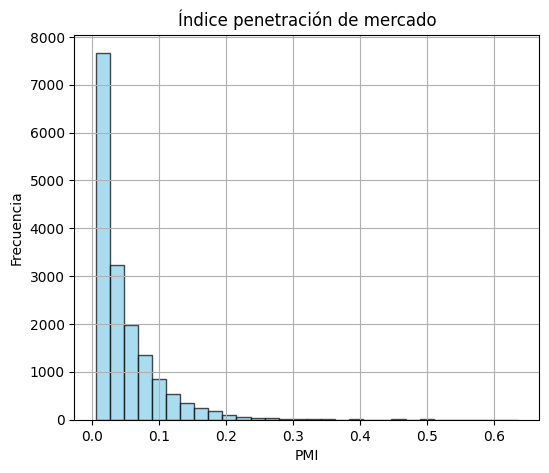

Cuantiles:
0.00    0.005587
0.25    0.013514
0.50    0.030075
0.75    0.064327
1.00    0.635514
dtype: float64


In [ ]:

# Graficar la distribución de la variable
plt.figure(figsize=(6, 5))
plt.hist(pmi, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Índice penetración de mercado')
plt.xlabel('PMI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcular los cuantiles
cuantiles = pmi.quantile([0, 0.25, 0.5, 0.75, 1])

# Imprimir los cuantiles
print("Cuantiles:")
print(cuantiles)

In [ ]:

# Se define el cuantil para dividir en dos grupos
cuantil_medio = 0.030075  # Este es el cuantil 50%

# Función para categorizar el índice de penetración en dos grupos: alto y bajo
def categorizar_indice(indice):
    if indice <= cuantil_medio:
        return 'bajo'
    else:
        return 'alto'

# Aplicar la función a cada valor de índice_penetracion y crear la variable dummy
dft3['pmi'] = dft3['pmi'].apply(categorizar_indice)



In [ ]:
# se valida la variable categorizada
dft3['pmi'].value_counts(dropna=False)

pmi
bajo    3051592
alto    1499483
Name: count, dtype: int64

In [ ]:
# se valida el dataframe
dft3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551075 entries, 0 to 4551074
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   producto               object 
 1   país                   object 
 2   años                   object 
 3   País_importa_mundo     int64  
 4   País_exporta_mundo     int64  
 5   cadena                 object 
 6   iso3                   object 
 7   continent              object 
 8   exportación_real       int64  
 9   potencial exportación  int64  
 10  product_export         object 
 11  dist                   float64
 12  acuerdo                object 
 13  elasticidad            object 
 14  pib_per                object 
 15  ipc                    object 
 16  pais_export            object 
 17  pmi                    object 
dtypes: float64(1), int64(4), object(13)
memory usage: 625.0+ MB


### Índice de ventaja comparativa revelada

El Índice de ventaja comparativa revelada (RCA) es igual a la proporción de las exportaciones del país, ciudad o región de un determinado producto, dividido por la proporción de exportaciones mundiales de este producto.

Valores de RCA > 1 indica que un territorio es especialista en determinado producto porque exporta más de lo esperado.

In [ ]:
# Se calcula las exportaciones totales de Colombia para cada año y producto
colombia_exports = dft3.groupby(['años', 'producto'])['exportación_real'].sum()

In [ ]:
# Se calcula las exportaciones totales de todos los países para cada año y producto
world_exports = dft3.groupby(['años', 'producto'])['País_exporta_mundo'].sum()

In [ ]:
# Se calcula la participación de Colombia en las exportaciones mundiales para cada producto y año
colombia_share = colombia_exports / world_exports

In [ ]:
# Se calcula la participación de Colombia en las exportaciones mundiales promedio para cada años
average_colombia_share = colombia_exports.groupby('años').sum() / world_exports.groupby('años').sum()

In [ ]:
# Se calcula la participación de cada país en las exportaciones mundiales promedio para cada años
average_world_share = world_exports.groupby('años').sum() / world_exports.groupby('años').sum()

In [ ]:
# Se calcular el RCA para cada producto y año
RCA = colombia_share / average_colombia_share / (average_world_share / 1)

In [ ]:
RCA

años  producto
2018  10121       0.633663
      10129       0.035367
      10130       0.209910
      10190       0.000000
      10221       0.000000
                    ...   
2022  970400      0.000000
      970500      0.000000
      970539      0.000000
      970600      0.000000
      970690      0.000000
Length: 25425, dtype: float64

In [ ]:
# Se reinicia los índices para ambos DataFrames
RCA_df = RCA.to_frame()

In [ ]:
# Exportar el DataFrame al archivo Excel
#ruta_archivo = 'RCA_df.xlsx'
#RCA_df.to_excel(ruta_archivo, index=True)

In [ ]:
# Se fusiona los DataFrames en función de las columnas 'año' y 'producto'
dft3 = pd.merge(dft3, RCA_df, on=['años', 'producto'], how='left')

In [ ]:
# Se renombra variable
dft3 = dft3.rename(columns={0: 'rca'})

In [ ]:
# Se crea la variable dummy
dft3['rca_a'] = (dft3['rca'] > 1).astype(int)

# Se muestra el resultado
print(dft3['rca_a'])

0          0
1          0
2          0
3          0
4          0
          ..
4551070    0
4551071    0
4551072    0
4551073    0
4551074    0
Name: rca_a, Length: 4551075, dtype: int64


In [ ]:
dft3.head()

producto        país  años  País_importa_mundo  País_exporta_mundo  \
0    10121  Afganistan  2018               15561                   0   
1    10121  Afganistan  2019                2771                   0   
2    10121  Afganistan  2020                   0                   0   
3    10121  Afganistan  2021                  34                   4   
4    10121  Afganistan  2022               13175                   8   

          cadena iso3 continent  exportación_real  potencial exportación  \
0  Agroalimentos  AFG      Asia                 0                  15561   
1  Agroalimentos  AFG      Asia                 0                   2771   
2  Agroalimentos  AFG      Asia                 0                      0   
3  Agroalimentos  AFG      Asia                 0                     34   
4  Agroalimentos  AFG      Asia                 0                  13175   

  product_export     dist acuerdo elasticidad   pib_per       ipc pais_export  \
0             no  14288.0      no     no sign  negativa  positiva          no   
1             no  14288.0      no     no sign  positiva  positiva          no   
2             no  14288.0      no     no sign  negativa  negativa          no   
3             no  14288.0      no     no sign  negativa  negativa          si   
4             no  14288.0      no     no sign  negativa  negativa          si   

    pmi       rca  rca_a  
0  alto  0.633663      0  
1  alto  0.238810      0  
2  alto  0.220875      0  
3  alto  0.324517      0  
4  alto  0.207930      0

In [ ]:
# se valida variable
dft3['rca_a'].value_counts(dropna=False)

rca_a
0    4024636
1     526439
Name: count, dtype: int64

In [ ]:

# Función para categorizar en dos grupos: alto y bajo
def categorizar_rca_a(rca_a):
    if rca_a <= 0:
        return 'bajo'
    else:
        return 'alto'

# Se aplica la función a cada valor y se crea la variable dummy
dft3['rca_a'] = dft3['rca_a'].apply(categorizar_rca_a)

In [ ]:
# se valida variable
dft3['rca_a'].value_counts(dropna=False)

rca_a
bajo    4024636
alto     526439
Name: count, dtype: int64

In [ ]:
# se valida variable en dataframe
dft3.head(2)

producto        país  años  País_importa_mundo  País_exporta_mundo  \
0    10121  Afganistan  2018               15561                   0   
1    10121  Afganistan  2019                2771                   0   

          cadena iso3 continent  exportación_real  potencial exportación  \
0  Agroalimentos  AFG      Asia                 0                  15561   
1  Agroalimentos  AFG      Asia                 0                   2771   

  product_export     dist acuerdo elasticidad   pib_per       ipc pais_export  \
0             no  14288.0      no     no sign  negativa  positiva          no   
1             no  14288.0      no     no sign  positiva  positiva          no   

    pmi       rca rca_a  
0  alto  0.633663  bajo  
1  alto  0.238810  bajo

### Factor distancia


Se realiza la categorización de la variable distancia entre tres niveles (larga, mediana, corta)

In [ ]:
dft3['dist']

0          14288.0
1          14288.0
2          14288.0
3          14288.0
4          14288.0
            ...   
4551070    11880.0
4551071    11880.0
4551072    11880.0
4551073    11880.0
4551074    11880.0
Name: dist, Length: 4551075, dtype: float64

Se valida la distribución de la variable distancia

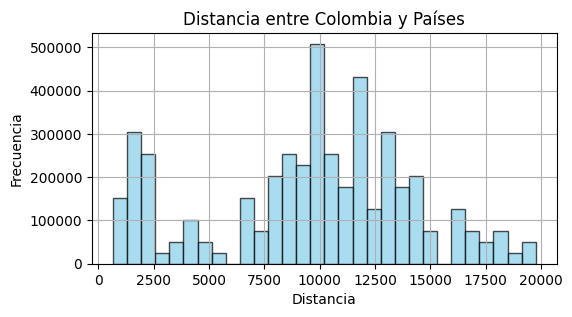

Cuantiles:
0.00      662.0
0.25     7122.0
0.50    10084.0
0.75    12883.0
1.00    19772.0
Name: dist, dtype: float64


In [ ]:
# Graficar la distribución de la variable
plt.figure(figsize=(6, 3))
plt.hist(dft3['dist'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distancia entre Colombia y Países')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcular los cuantiles
cuantiles = dft3['dist'].quantile([0, 0.25, 0.5, 0.75, 1])

# Imprimir los cuantiles
print("Cuantiles:")
print(cuantiles)

In [ ]:
import pandas as pd

# Definir los límites de las categorías según los cuantiles proporcionados
bin_edges = [0, 7122, 10084, 20000]  # Define los límites de los cuantiles para 'Corta', 'Mediana' y 'Larga'
bin_names = ['Corta', 'Mediana', 'Larga']  # Define los nombres de las categorías

# Utilizar pd.cut() para categorizar la distancia desde Colombia a otros países
dft3['categoria_distancia'] = pd.cut(dft3['dist'], bins=bin_edges, labels=bin_names, right=False)

# Mostrar el DataFrame con la nueva columna de categoría de distancia
dft3.head(2)


producto        país  años  País_importa_mundo  País_exporta_mundo  \
0    10121  Afganistan  2018               15561                   0   
1    10121  Afganistan  2019                2771                   0   

          cadena iso3 continent  exportación_real  potencial exportación  ...  \
0  Agroalimentos  AFG      Asia                 0                  15561  ...   
1  Agroalimentos  AFG      Asia                 0                   2771  ...   

      dist  acuerdo elasticidad   pib_per       ipc pais_export   pmi  \
0  14288.0       no     no sign  negativa  positiva          no  alto   
1  14288.0       no     no sign  positiva  positiva          no  alto   

        rca  rca_a categoria_distancia  
0  0.633663   bajo               Larga  
1  0.238810   bajo               Larga  

[2 rows x 21 columns]

In [ ]:
# Se valida variable
dft3['categoria_distancia'].value_counts(dropna=False)

categoria_distancia
Larga      2288250
Mediana    1144125
Corta      1118700
Name: count, dtype: int64

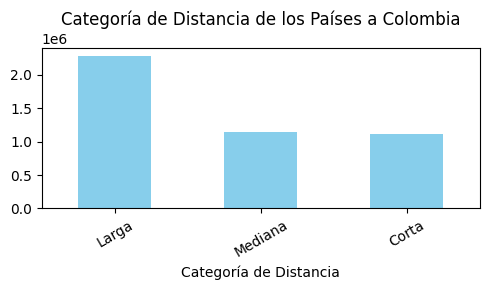

In [ ]:
import matplotlib.pyplot as plt


# Se calcula el recuento de cada categoría de distancia
categoria_counts = dft3['categoria_distancia'].value_counts()

# gráfica de barras
plt.figure(figsize=(5, 3))
categoria_counts.plot(kind='bar', color='skyblue')

# títulos y etiquetas
plt.title('Categoría de Distancia de los Países a Colombia')
plt.xlabel('Categoría de Distancia')

# gráfica
plt.xticks(rotation=30)  # etiquetas del eje x para mayor legibilidad
plt.tight_layout()  # diseño para evitar que se corten las etiquetas
plt.show()


Se valida las categorias de las distancias dadas de acuerdo con el país y se evidencia concordancia de acuerdo a la ubicación del continente.

In [ ]:
# se recorta la variable continente
dft3['continente_abr'] = dft3['continent'].str[:3]

# Crear una nueva columna que concatene país y continente
dft3['pais_continente'] = dft3['país'] + ' (' + dft3['continente_abr'] + ')'

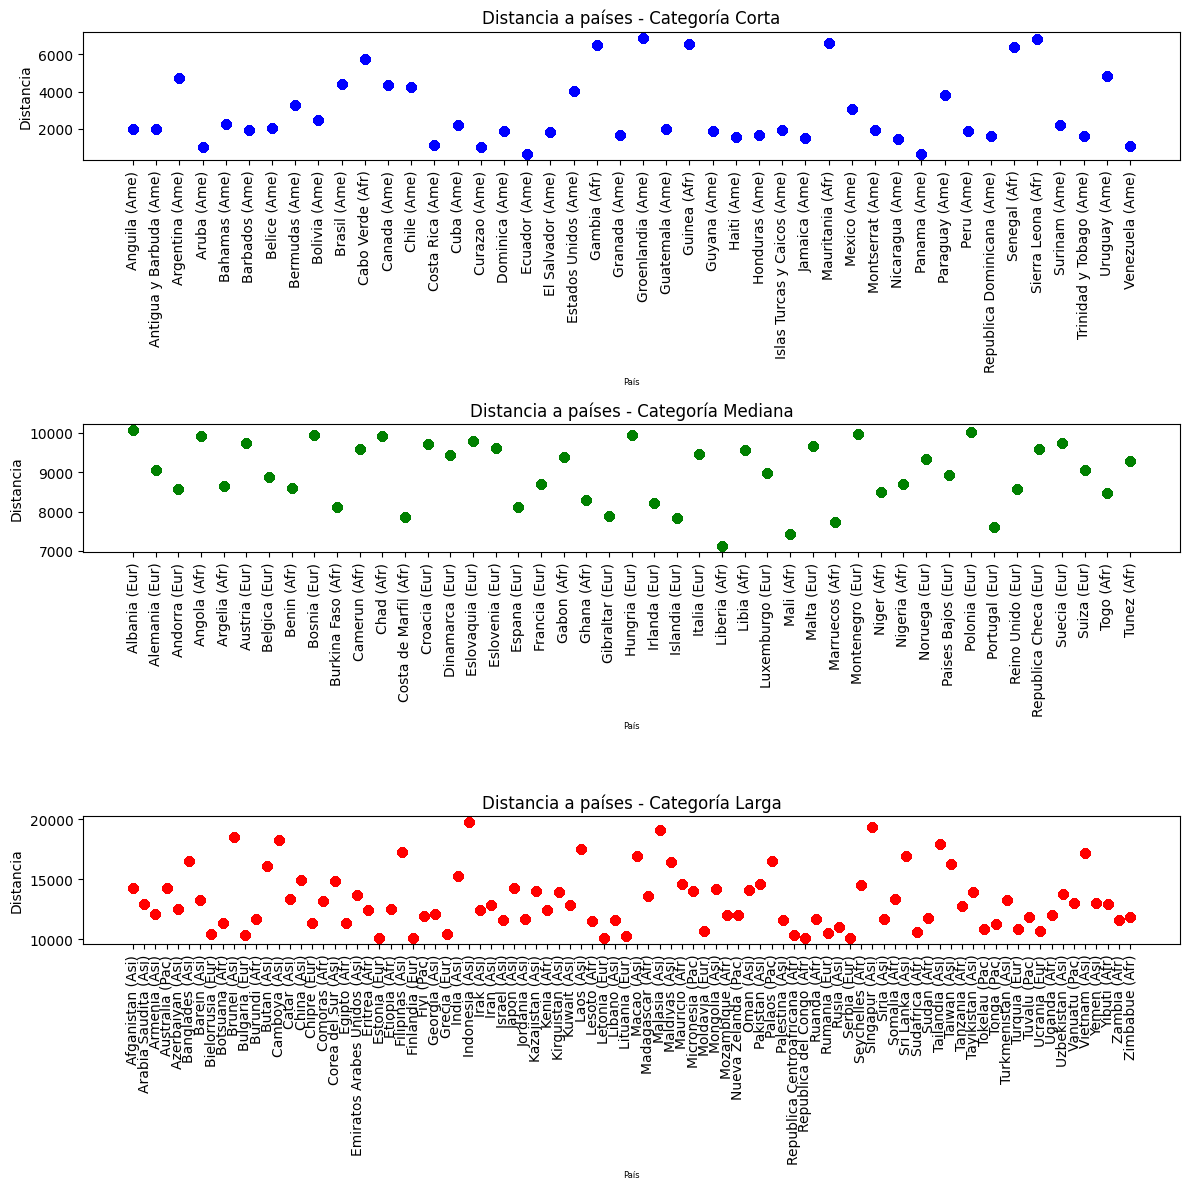

In [ ]:
import matplotlib.pyplot as plt


# Crear subgráficos
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Gráfica para la categoría "Corta"
dft3_corta = dft3[dft3['categoria_distancia'] == 'Corta']
axs[0].scatter(dft3_corta['pais_continente'], dft3_corta['dist'], color='blue')
axs[0].set_title('Distancia a países - Categoría Corta')
axs[0].set_xlabel('País', fontsize=6)
axs[0].set_ylabel('Distancia')
axs[0].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x

# Gráfica para la categoría "Mediana"
dft3_mediana = dft3[dft3['categoria_distancia'] == 'Mediana']
axs[1].scatter(dft3_mediana['pais_continente'], dft3_mediana['dist'], color='green')
axs[1].set_title('Distancia a países - Categoría Mediana')
axs[1].set_xlabel('País', fontsize=6)
axs[1].set_ylabel('Distancia')
axs[1].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x

# Gráfica para la categoría "Larga"
dft3_larga = dft3[dft3['categoria_distancia'] == 'Larga']
axs[2].scatter(dft3_larga['pais_continente'], dft3_larga['dist'], color='red')
axs[2].set_title('Distancia a países - Categoría Larga')
axs[2].set_xlabel('País', fontsize=6)
axs[2].set_ylabel('Distancia')
axs[2].tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x

# Ajustar diseño de los subgráficos
plt.tight_layout()

# Mostrar gráficas
plt.show()


## Análisis de datos



En este apartado se realiza un analisis exploratorio de los datos para validar las distribuciones de cada una de ellas. S eexcluye alguna de ellas debido a que no se tendrán en cuenta para el objetivo del estudio.

In [ ]:
dft4=dft3.drop(['País_importa_mundo','País_exporta_mundo','dist','rca','pais_continente','continente_abr','iso3','product_export','pais_export'], axis=1)

In [ ]:
categorical_vars = dft4.describe(include=["object","category"]).columns
continuous_vars = dft4.describe().columns

In [ ]:
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['exportación_real', 'potencial exportación'], dtype='object')
categorical_vars: Index(['producto', 'país', 'años', 'cadena', 'continent', 'acuerdo',
       'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a', 'categoria_distancia'],
      dtype='object')


### Variables Cuantitativas

In [ ]:
dft4[continuous_vars].describe().T

count          mean            std  min  25%   50%  \
exportación_real       4551075.0     18.260787    1798.741146  0.0  0.0   0.0   
potencial exportación  4551075.0  17381.771934  358548.471350  0.0  0.0  78.0   

                          75%          max  
exportación_real          0.0    1682811.0  
potencial exportación  1656.0  205091244.0

Distribución por año y con valores mayores a 1

In [ ]:
dft4b = dft4[dft4['exportación_real'] >0]

In [ ]:
categorical_vars = dft4b.describe(include=["object","category"]).columns
continuous_vars = dft4b.describe().columns
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['exportación_real', 'potencial exportación'], dtype='object')
categorical_vars: Index(['producto', 'país', 'años', 'cadena', 'continent', 'acuerdo',
       'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a', 'categoria_distancia'],
      dtype='object')


In [ ]:
dft4b[continuous_vars].describe().T

count           mean           std  min     25%  \
exportación_real       125264.0     663.448477  1.082236e+04  1.0    4.00   
potencial exportación  125264.0  171885.054429  1.728204e+06  0.0  774.75   

                          50%      75%          max  
exportación_real         19.0    107.0    1682811.0  
potencial exportación  5038.5  39864.5  205091244.0

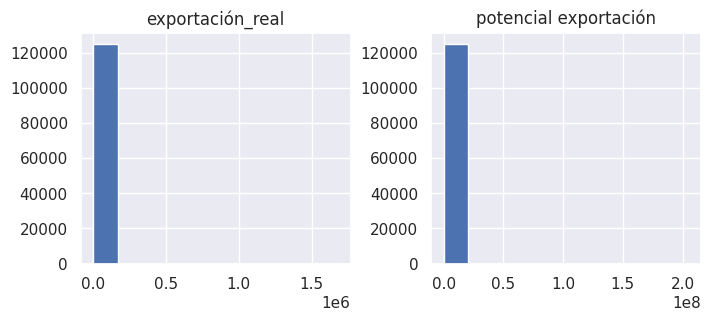

In [ ]:
_ = dft4b.hist(column=continuous_vars, figsize=(8,3))

In [ ]:
dft4c = dft4[dft4['potencial exportación'] >0]

In [ ]:
categorical_vars = dft4c.describe(include=["object","category"]).columns
continuous_vars = dft4c.describe().columns
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['exportación_real', 'potencial exportación'], dtype='object')
categorical_vars: Index(['producto', 'país', 'años', 'cadena', 'continent', 'acuerdo',
       'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a', 'categoria_distancia'],
      dtype='object')


In [ ]:
dft4c[continuous_vars].describe().T

count          mean            std  min   25%  \
exportación_real       3267718.0     25.307074    2121.961844  0.0   0.0   
potencial exportación  3267718.0  24208.254111  422943.240615  1.0  45.0   

                         50%     75%          max  
exportación_real         0.0     0.0    1682811.0  
potencial exportación  452.0  4090.0  205091244.0

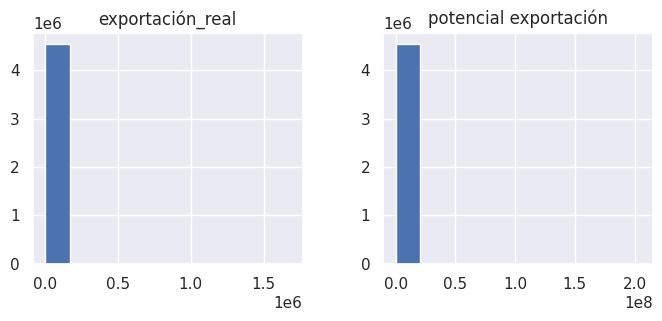

In [ ]:
# gráfico de barras de frecuencias relativas  #https://matplotlib.org/stable/tutorials/pyplot.html

_ = dft4.hist(column=continuous_vars, figsize=(8,3))


In [ ]:

# Pivotear la tabla según el año y el valor sea lo exportado
pivot_table = pd.pivot_table(dft4, values='exportación_real', index='país', columns='años', aggfunc='sum')

# Agregar una columna que sume lo exportado por todos los años
pivot_table['total_exportado'] = pivot_table.sum(axis=1)

# Tabla resultante
print(pivot_table)

años          2018    2019    2020    2021    2022  total_exportado
país                                                               
Afganistan       2       6      49       4       0               61
Albania        791     838     868     290     206             2993
Alemania    391934  422222  391102  462814  514264          2182336
Andorra         13       0       0       0       0               13
Angola        1006    2544     872    2222    4938            11582
...            ...     ...     ...     ...     ...              ...
Vietnam      40828   33418   18316   20882   24233           137677
Yemen         1327    1163    1282     257     657             4686
Yibuti         492    2047     611    2500    1050             6700
Zambia        1391     307     121       0     344             2163
Zimbabue       117       2       5      51       4              179

[179 rows x 6 columns]


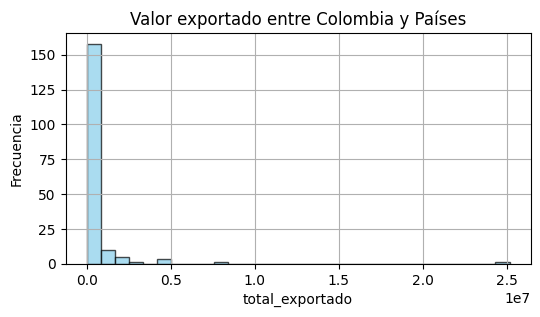

Cuantiles:
0.00           0.0
0.25         896.5
0.50       10304.0
0.75      147037.5
1.00    25163738.0
Name: total_exportado, dtype: float64


In [ ]:
# Grafica la distribución de la variable
plt.figure(figsize=(6, 3))
plt.hist(pivot_table['total_exportado'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Valor exportado entre Colombia y Países')
plt.xlabel('total_exportado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcula los cuantiles
cuantiles = pivot_table['total_exportado'].quantile([0, 0.25, 0.5, 0.75, 1])

# Cuantiles
print("Cuantiles:")
print(cuantiles)

In [ ]:
# Pivotear la tabla según el año y el valor sea lo exportado
pivot_table = pd.pivot_table(dft4, values='exportación_real', index='producto', columns='años', aggfunc='sum')

# Agregar una columna que sume lo exportado por todos los años
pivot_table['total_exportado'] = pivot_table.sum(axis=1)

# Mostrar la tabla resultante
print(pivot_table)

años      2018  2019  2020  2021  2022  total_exportado
producto                                               
10121     1033   372   323   570   390             2688
10129       44   126    89   102   299              660
10130        1    18     0     2    12               33
10190        0     0     7     0     4               11
10221        0     0     0     0     0                0
...        ...   ...   ...   ...   ...              ...
970400       0     0     0     0     0                0
970500       0     0   123     0     0              123
970539       0     0     0     0     0                0
970600       0     0     0     0     0                0
970690       0     0     0     0     0                0

[5085 rows x 6 columns]


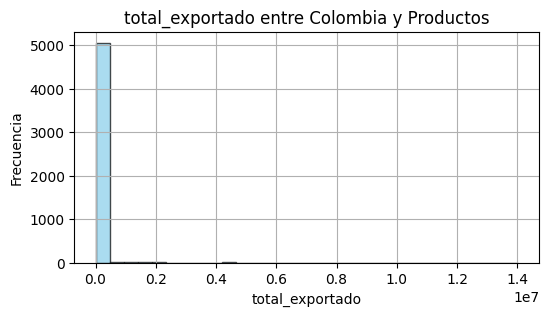

Cuantiles:
0.00           0.0
0.25           8.0
0.50         184.0
0.75        1940.0
1.00    14032399.0
Name: total_exportado, dtype: float64


In [ ]:
# Graficar la distribución de la variable
plt.figure(figsize=(6, 3))
plt.hist(pivot_table['total_exportado'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('total_exportado entre Colombia y Productos')
plt.xlabel('total_exportado')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcular los cuantiles
cuantiles = pivot_table['total_exportado'].quantile([0, 0.25, 0.5, 0.75, 1])

# Imprimir los cuantiles
print("Cuantiles:")
print(cuantiles)

### Variables Cualitativas

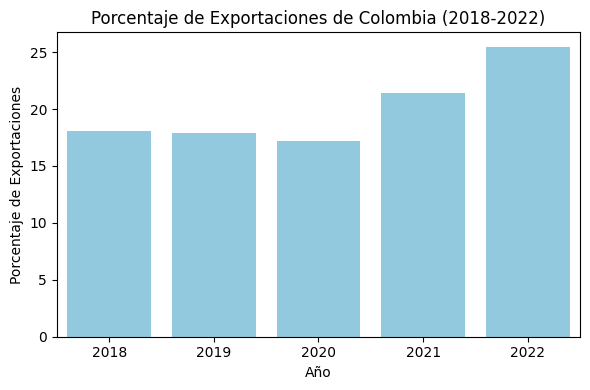

In [ ]:
# Calcular la suma total de exportaciones para cada año
total_exportaciones_por_año = dft4b.groupby('años')['exportación_real'].sum()

# Calcular los porcentajes de exportación para cada año
porcentajes_exportaciones_por_año = total_exportaciones_por_año / total_exportaciones_por_año.sum() * 100

# Crear un DataFrame con los años y los porcentajes de exportación
data = {'años': porcentajes_exportaciones_por_año.index,
        'porcentaje_exportaciones': porcentajes_exportaciones_por_año.values}
df_porcentajes = pd.DataFrame(data)

# Graficar
plt.figure(figsize=(6,4))
sns.barplot(x='años', y='porcentaje_exportaciones', data=df_porcentajes, color='skyblue')
plt.title("Porcentaje de Exportaciones de Colombia (2018-2022)")
plt.xlabel("Año")
plt.ylabel("Porcentaje de Exportaciones")
plt.tight_layout()
plt.show()

In [ ]:
# Calcular la suma total de exportaciones para cada año
total_exportaciones_por_año = dft4b.groupby('años')['exportación_real'].sum()

# Calcular los porcentajes de exportación para cada año
porcentajes_exportaciones_por_año = total_exportaciones_por_año / total_exportaciones_por_año.sum() * 100

# Mostrar los porcentajes de exportación por año
print(porcentajes_exportaciones_por_año)

años
2018    18.032959
2019    17.903330
2020    17.190282
2021    21.412094
2022    25.461334
Name: exportación_real, dtype: float64


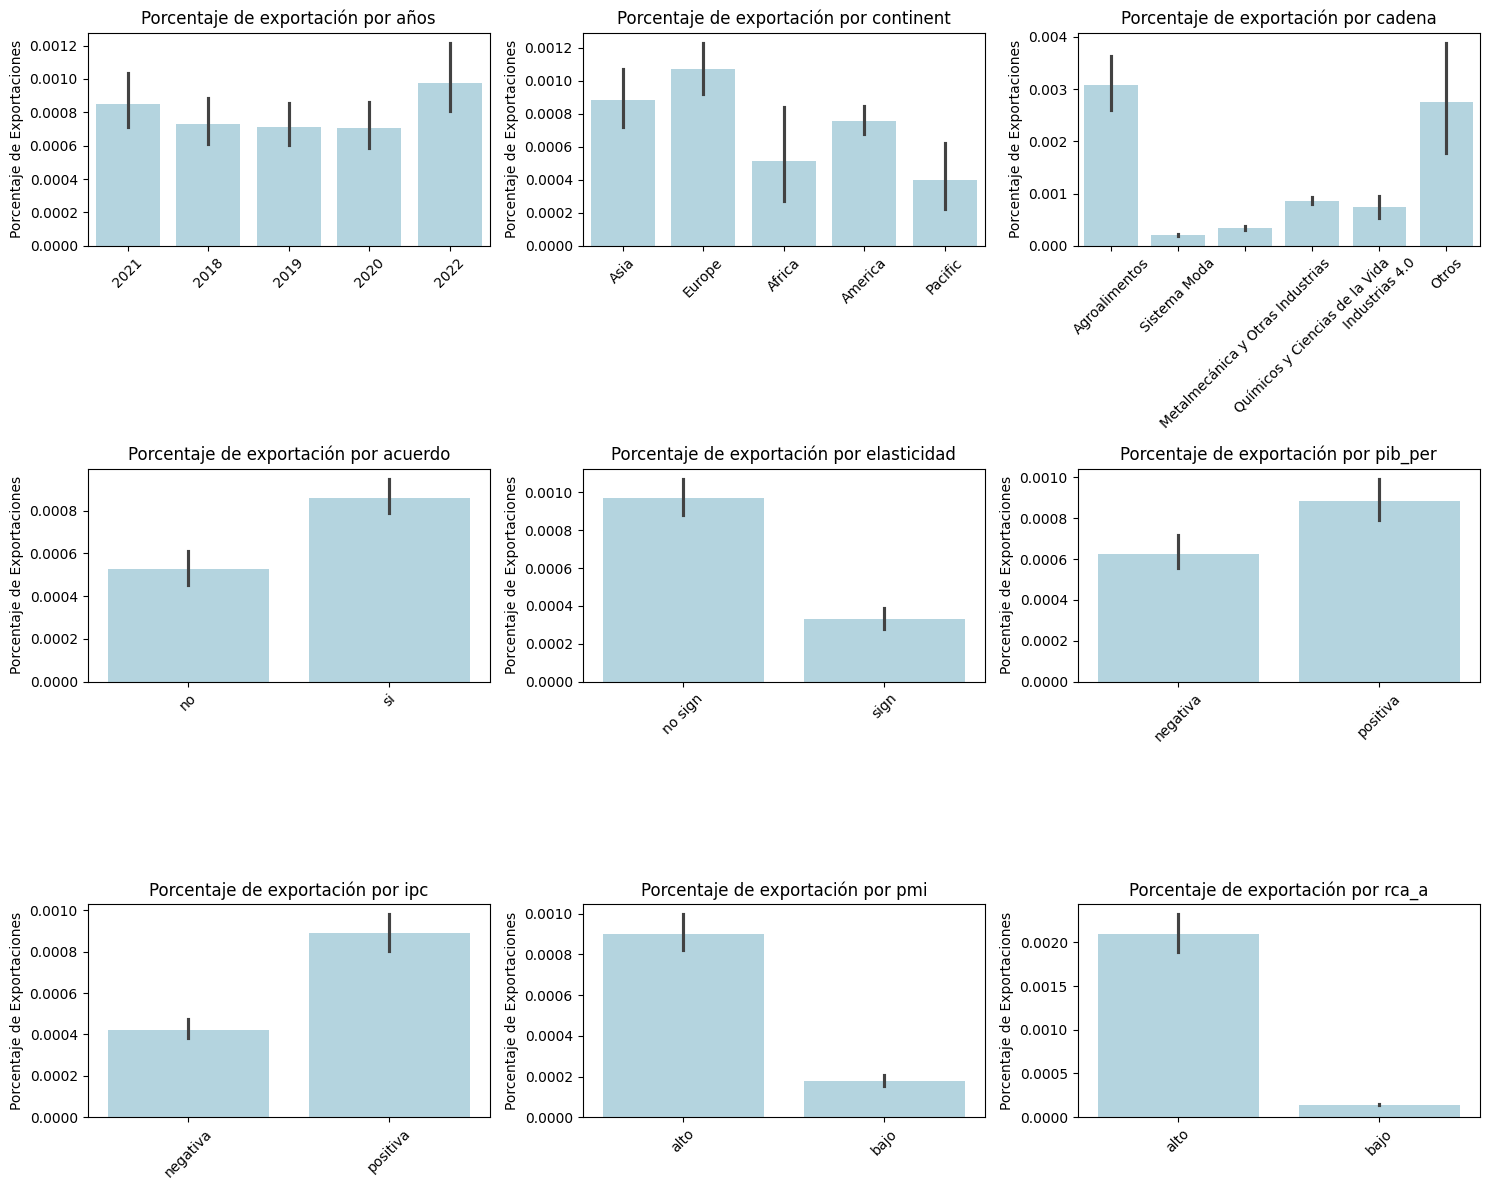

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que df es tu DataFrame con los datos

# Calcular el total de exportaciones reales
total_exportaciones = dft4b['exportación_real'].sum()

# Calcular los porcentajes de exportación real para cada categoría de la variable
dft4b['porcentaje_exportacion'] = (dft4b['exportación_real'] / total_exportaciones) * 100

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Variables a graficar
variables = ['años', 'continent', 'cadena', 'acuerdo', 'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a']

# Graficar cada variable
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.barplot(data=dft4b, x=var, y='porcentaje_exportacion', ax=axes[row][col], color='lightblue')
    axes[row][col].set_title(f'Porcentaje de exportación por {var}')
    axes[row][col].set_xlabel('')
    axes[row][col].set_ylabel('Porcentaje de Exportaciones')
    axes[row][col].tick_params(axis='x', rotation=45)

# Ajustar espaciado
plt.tight_layout()
plt.show()


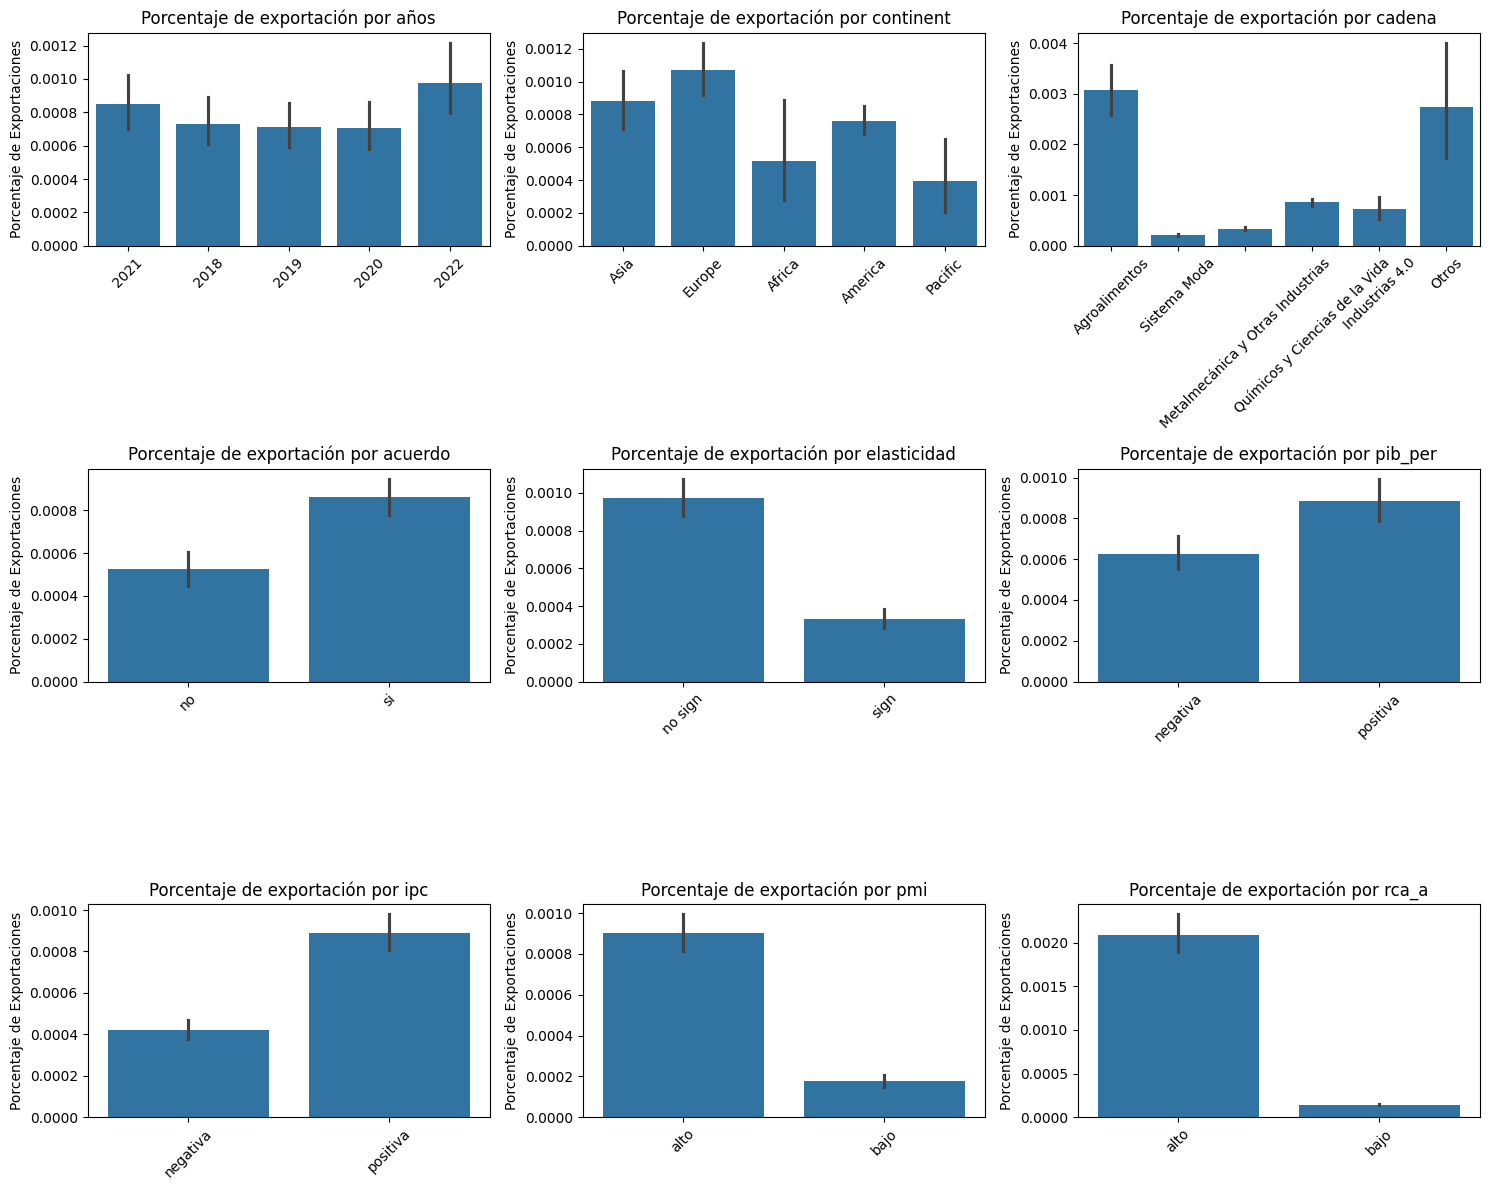

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que df es tu DataFrame con los datos

# Calcular el total de exportaciones reales
total_exportaciones = dft4b['exportación_real'].sum()

# Calcular los porcentajes de exportación real para cada categoría de la variable
dft4b['porcentaje_exportacion'] = (dft4b['exportación_real'] / total_exportaciones) * 100

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Variables a graficar
variables = ['años', 'continent', 'cadena', 'acuerdo', 'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a']

# Graficar cada variable
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.barplot(data=dft4b, x=var, y='porcentaje_exportacion', ax=axes[row][col])
    axes[row][col].set_title(f'Porcentaje de exportación por {var}')
    axes[row][col].set_xlabel('')
    axes[row][col].set_ylabel('Porcentaje de Exportaciones')
    axes[row][col].tick_params(axis='x', rotation=45)

# Ajustar espaciado
plt.tight_layout()
plt.show()


In [ ]:
# Variables a analizar
variables = ['años', 'continent', 'cadena', 'acuerdo', 'elasticidad', 'pib_per', 'ipc', 'pmi', 'rca_a']

# Iterar sobre cada variable y calcular los porcentajes de exportación
for var in variables:
    # Calcular la suma total de exportaciones para cada variable
    total_exportaciones_por_variable = dft4b.groupby(var)['exportación_real'].sum()

    # Calcular los porcentajes de exportación para cada variable
    porcentajes_exportaciones_por_variable = total_exportaciones_por_variable / total_exportaciones_por_variable.sum() * 100

    # Ordenar los resultados de mayor a menor
    porcentajes_exportaciones_por_variable = porcentajes_exportaciones_por_variable.sort_values(ascending=False)

    # Mostrar los porcentajes de exportación por variable
    print(f"Porcentaje de Exportaciones de Colombia por {var} (de mayor a menor):")
    print(porcentajes_exportaciones_por_variable)
    print()


Porcentaje de Exportaciones de Colombia por años (de mayor a menor):
años
2022    25.461334
2021    21.412094
2018    18.032959
2019    17.903330
2020    17.190282
Name: exportación_real, dtype: float64

Porcentaje de Exportaciones de Colombia por continent (de mayor a menor):
continent
America    73.735391
Europe     16.653061
Asia        8.076872
Africa      1.031561
Pacific     0.503115
Name: exportación_real, dtype: float64

Porcentaje de Exportaciones de Colombia por cadena (de mayor a menor):
cadena
Agroalimentos                       51.451356
Químicos y Ciencias de la Vida      21.808148
Metalmecánica y Otras Industrias    19.315782
Sistema Moda                         5.343692
Otros                                1.895255
Industrias 4.0                       0.185767
Name: exportación_real, dtype: float64

Porcentaje de Exportaciones de Colombia por acuerdo (de mayor a menor):
acuerdo
si    87.479287
no    12.520713
Name: exportación_real, dtype: float64

Porcentaje de Exporta

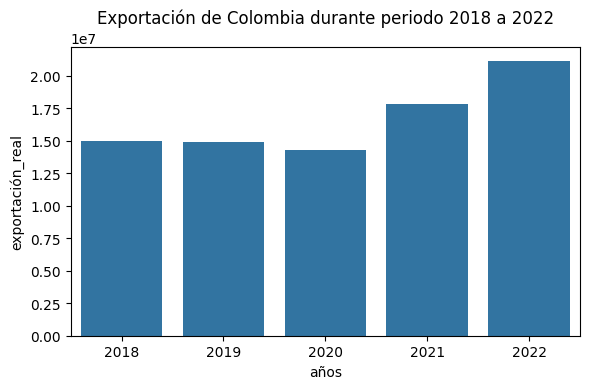

In [ ]:
agr = dft4b[['exportación_real','años']].groupby('años').sum()
agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(6,4))
sns.barplot(x='años', y='exportación_real', data=agr)
plt.title("Exportación de Colombia durante periodo 2018 a 2022")
plt.tight_layout()

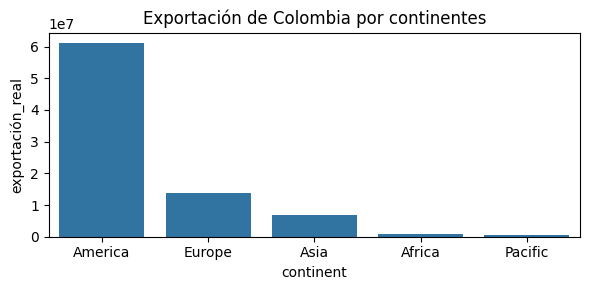

In [ ]:

agr = dft4[['exportación_real','continent']].groupby('continent').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(6,3))
sns.barplot(x='continent', y='exportación_real', data=agr)

plt.title("Exportación de Colombia por continentes")
plt.tight_layout()

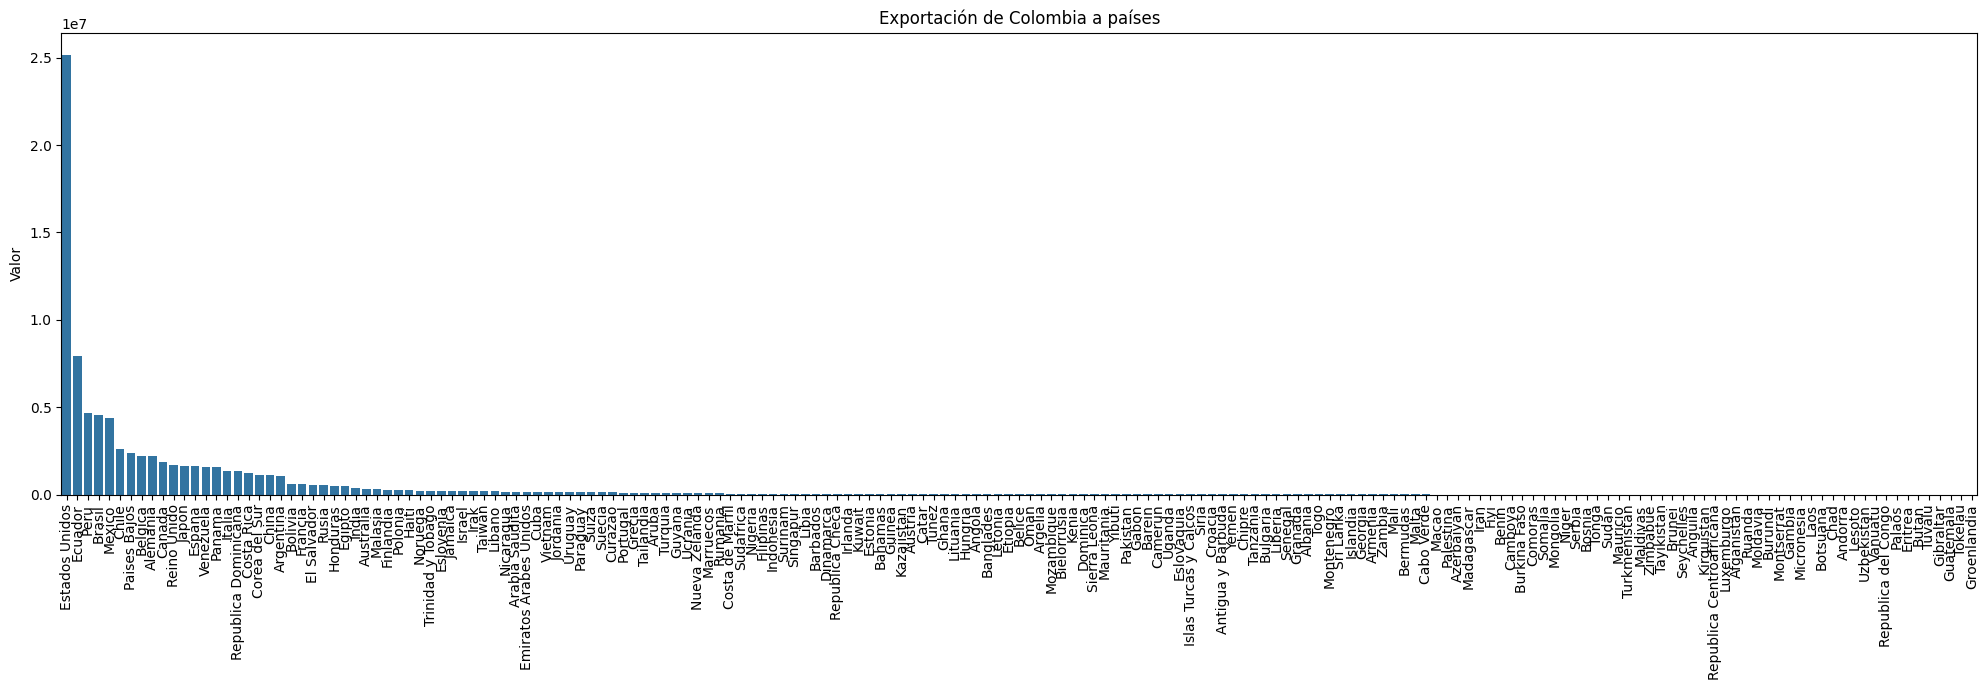

In [ ]:
agr = dft4[['exportación_real','país']].groupby('país').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(20,7))
sns.barplot(x='país', y='exportación_real', data=agr)
plt.title("Exportación de Colombia a países")
plt.xlabel('', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel("Valor")
plt.tight_layout()

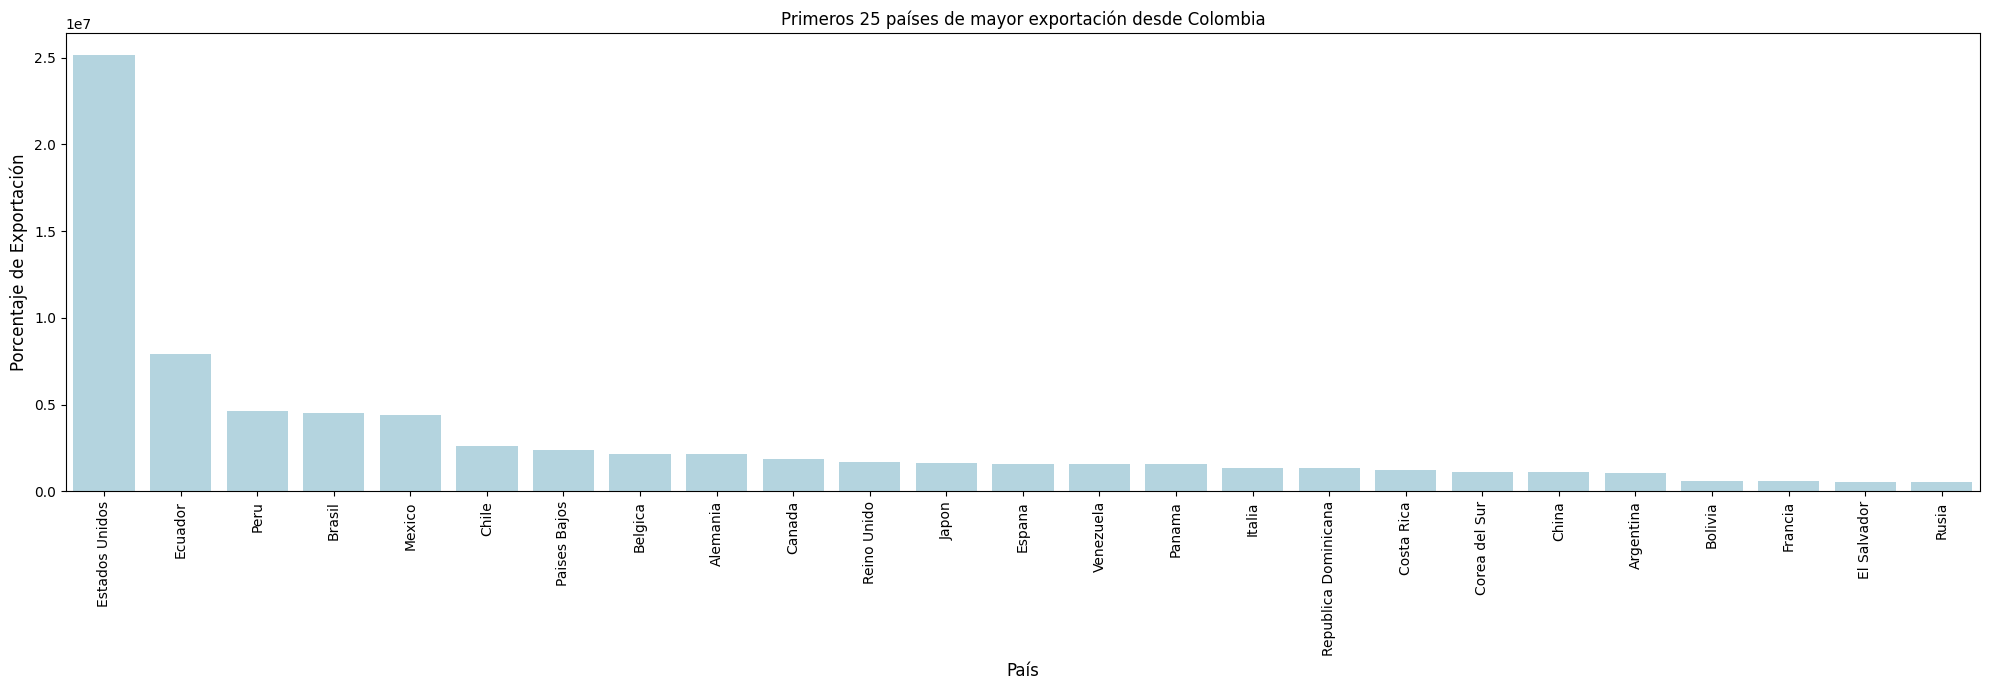

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que dft4b es tu DataFrame con los datos

# Calcular la suma total de exportaciones reales
total_exportaciones = dft4b['exportación_real'].sum()

# Calcular los porcentajes de exportación real para cada país
dft4b['porcentaje_exportacion'] = (dft4b['exportación_real'] / total_exportaciones) * 100

# Agrupar y ordenar por exportación real
agr = dft4b.groupby('país')['exportación_real'].sum().sort_values(ascending=False).reset_index()

# Tomar los primeros 25 países
agr_top25 = agr.head(25)

# Crear el gráfico
plt.figure(figsize=(20, 7))
sns.barplot(x='país', y='exportación_real', data=agr_top25, color='lightblue')
plt.title("Primeros 25 países de mayor exportación desde Colombia")
plt.xlabel('País', fontsize=12)
plt.ylabel('Porcentaje de Exportación', fontsize=12)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Tomar los primeros 25 países
top25_paises = agr.head(25)

# Mostrar los porcentajes de exportación de los primeros 25 países
print("Porcentaje de Exportación de Colombia por País (primeros 25 países):")
print(top25_paises)

Porcentaje de Exportación de Colombia por País (primeros 25 países):
                    país  exportación_real
0         Estados Unidos          25163738
1                Ecuador           7929362
2                   Peru           4657217
3                 Brasil           4534662
4                 Mexico           4391791
5                  Chile           2625872
6           Paises Bajos           2390409
7                Belgica           2183884
8               Alemania           2182336
9                 Canada           1846736
10           Reino Unido           1683308
11                 Japon           1635576
12                Espana           1605373
13             Venezuela           1585813
14                Panama           1554064
15                Italia           1372633
16  Republica Dominicana           1355667
17            Costa Rica           1242291
18         Corea del Sur           1116660
19                 China           1095727
20             Argentina    

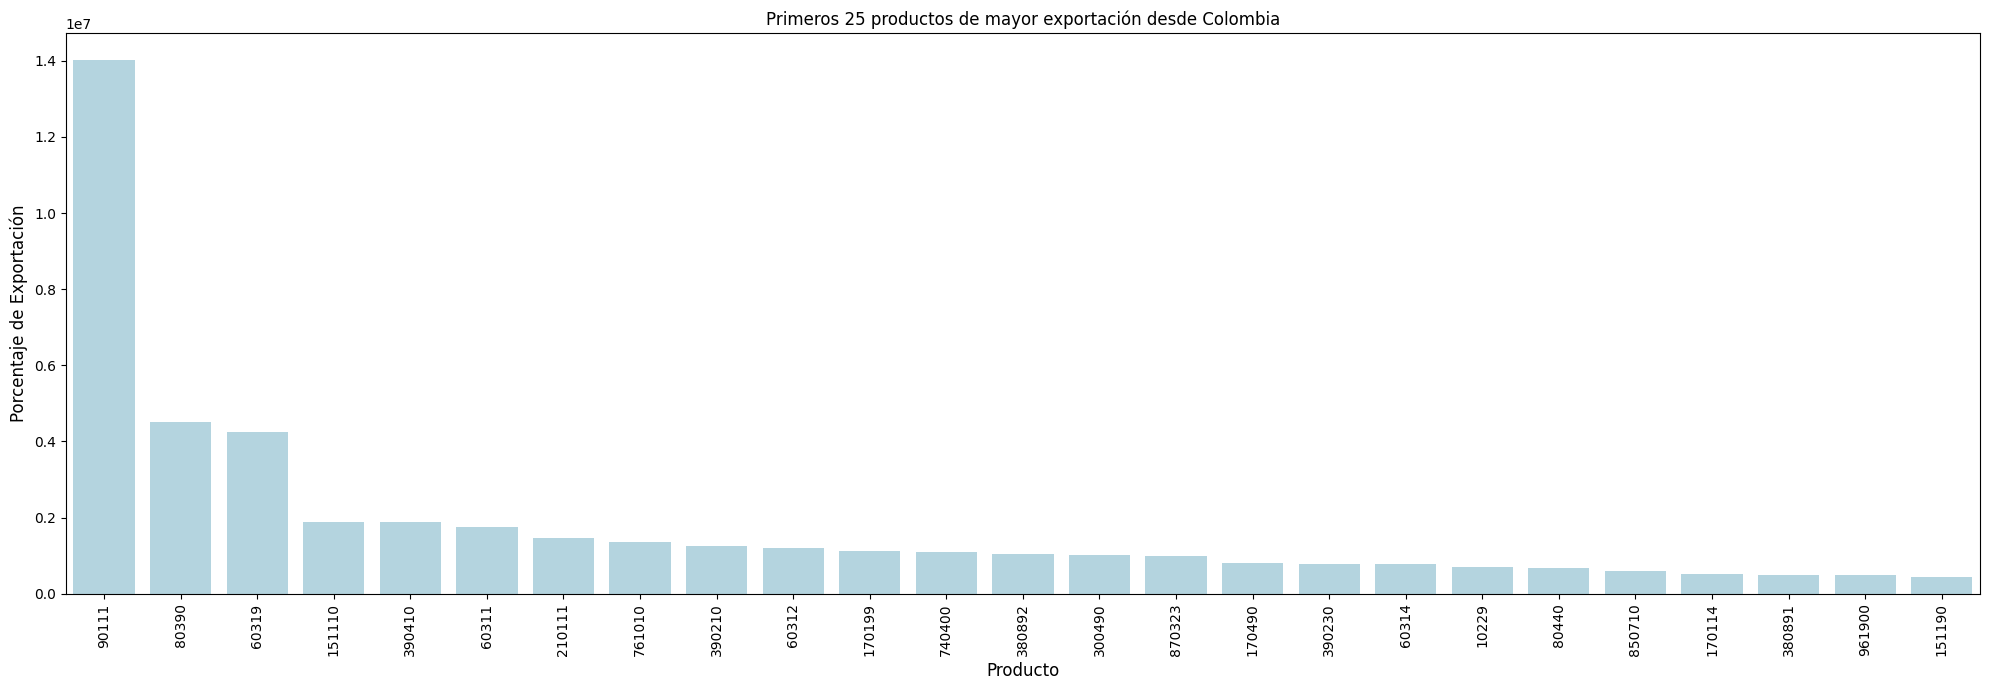

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que dft4b es tu DataFrame con los datos

# Calcular la suma total de exportaciones reales
total_exportaciones = dft4b['exportación_real'].sum()

# Calcular los porcentajes de exportación real para cada país
dft4b['porcentaje_exportacion'] = (dft4b['exportación_real'] / total_exportaciones) * 100

# Agrupar y ordenar por exportación real
agr = dft4b.groupby('producto')['exportación_real'].sum().sort_values(ascending=False).reset_index()

# Tomar los primeros 25 productos
agr_top25 = agr.head(25)

# Crear el gráfico
plt.figure(figsize=(20, 7))
sns.barplot(x='producto', y='exportación_real', data=agr_top25, color='lightblue', order=agr_top25['producto'])
plt.title("Primeros 25 productos de mayor exportación desde Colombia")
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Porcentaje de Exportación', fontsize=12)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Tomar los primeros 25 países
top25_productos = agr.head(25)

# Mostrar los porcentajes de exportación de los primeros 25 países
print("Porcentaje de Exportación de Colombia por País (primeros 25 países):")
print(top25_productos)

Porcentaje de Exportación de Colombia por País (primeros 25 países):
    producto  exportación_real
0      90111          14032399
1      80390           4508799
2      60319           4254579
3     151110           1888769
4     390410           1881478
5      60311           1742008
6     210111           1456865
7     761010           1346345
8     390210           1248022
9      60312           1195412
10    170199           1122308
11    740400           1107676
12    380892           1031839
13    300490           1015460
14    870323            985984
15    170490            805321
16    390230            781142
17     60314            768087
18     10229            706885
19     80440            679933
20    850710            592619
21    170114            521486
22    380891            502217
23    961900            487143
24    151190            440601


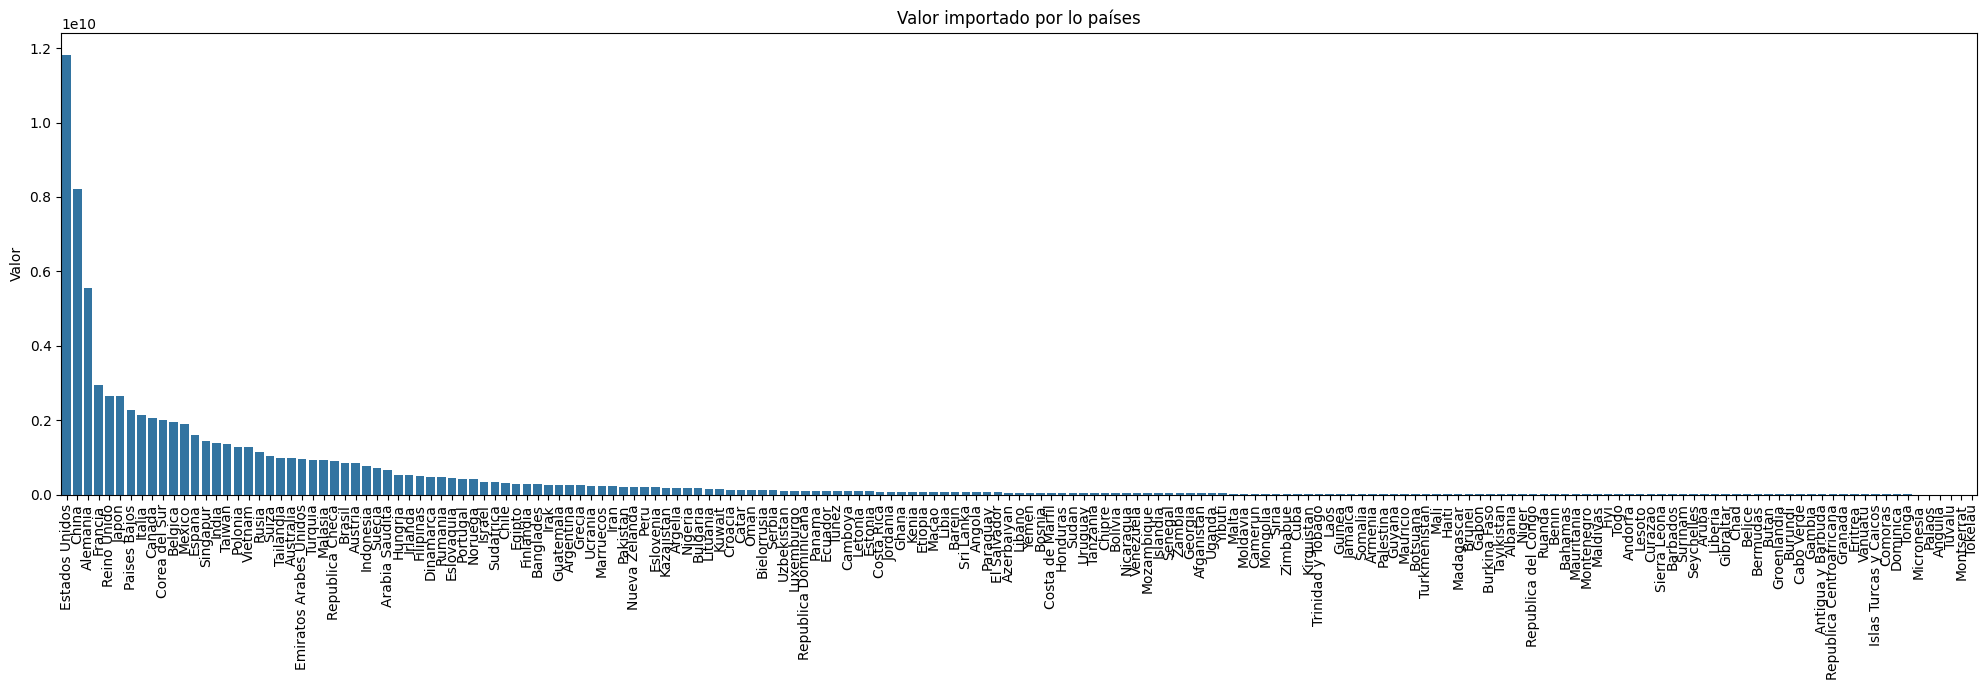

In [ ]:
agr = dft4[['potencial exportación','país']].groupby('país').sum()

agr = agr.sort_values('potencial exportación',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(20,7))
sns.barplot(x='país', y='potencial exportación', data=agr)
plt.title("Valor importado por lo países")
plt.xlabel('', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel("Valor")
plt.tight_layout()

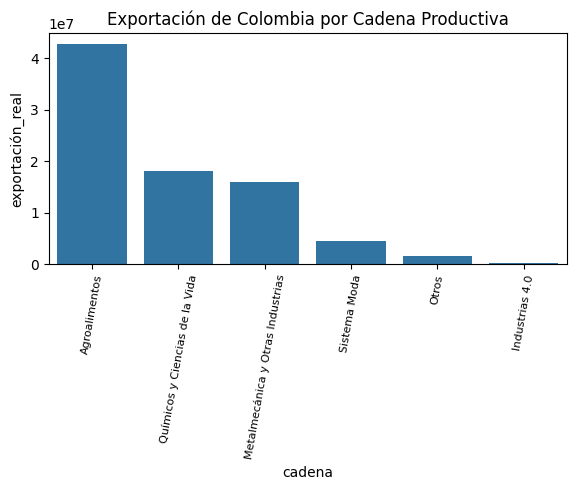

In [ ]:

agr = dft4[['exportación_real','cadena']].groupby('cadena').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(6,5))
sns.barplot(x='cadena', y='exportación_real', data=agr)
plt.xticks(fontsize=8, rotation=80)
plt.title("Exportación de Colombia por Cadena Productiva")
plt.tight_layout()

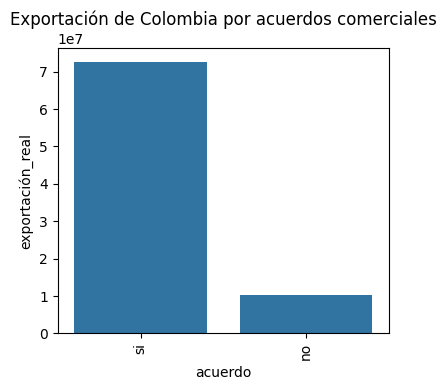

In [ ]:
agr = dft4[['exportación_real','acuerdo']].groupby('acuerdo').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,4))
sns.barplot(x='acuerdo', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por acuerdos comerciales")
plt.xticks(fontsize=10, rotation=90)
plt.tight_layout()

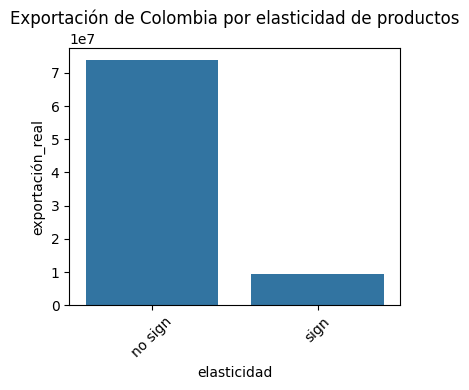

In [ ]:
agr = dft4[['exportación_real','elasticidad']].groupby('elasticidad').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,4))
sns.barplot(x='elasticidad', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por elasticidad de productos")
plt.xticks(fontsize=10, rotation=45)
plt.tight_layout()

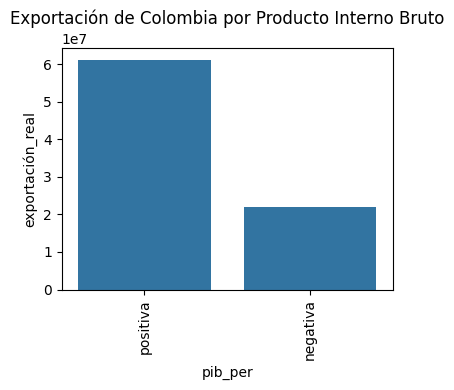

In [ ]:
agr = dft4[['exportación_real','pib_per']].groupby('pib_per').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,4))
sns.barplot(x='pib_per', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por Producto Interno Bruto")
plt.xticks(fontsize=10, rotation=90)
plt.tight_layout()

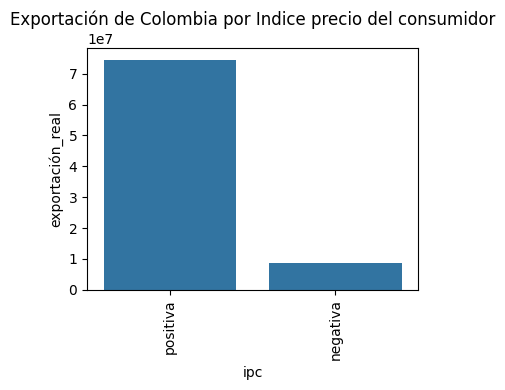

In [ ]:
agr = dft4[['exportación_real','ipc']].groupby('ipc').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,4))
sns.barplot(x='ipc', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por Indice precio del consumidor")
plt.xticks(fontsize=10, rotation=90)
plt.tight_layout()

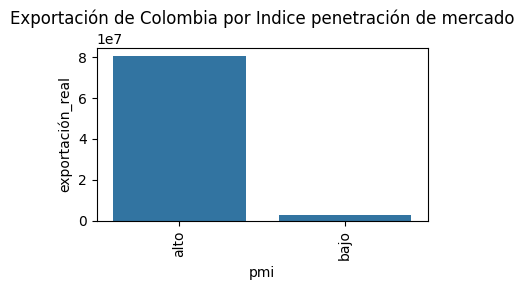

In [ ]:
agr = dft4[['exportación_real','pmi']].groupby('pmi').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,3))
sns.barplot(x='pmi', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por Indice penetración de mercado")
plt.xticks(fontsize=10, rotation=90)

plt.tight_layout()

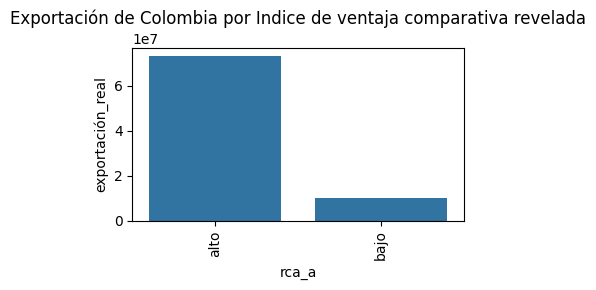

In [ ]:
agr = dft4[['exportación_real','rca_a']].groupby('rca_a').sum()

agr = agr.sort_values('exportación_real',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html

plt.figure(figsize=(4,3))
sns.barplot(x='rca_a', y='exportación_real', data=agr)
plt.title("Exportación de Colombia por Indice de ventaja comparativa revelada")
plt.xticks(fontsize=10, rotation=90)
plt.tight_layout()

In [ ]:
dft3.describe(include=["object"])

producto        país     años                            cadena  \
count    4551075     4551075  4551075                           4551075   
unique      5085         179        5                                 6   
top        10121  Afganistan     2018  Metalmecánica y Otras Industrias   
freq         895       25425   910215                           2082665   

           iso3 continent product_export  acuerdo elasticidad   pib_per  \
count   4551075   4551075        4551075  4551075     4551075   4551075   
unique      179         5              2        2           2         2   
top         AFG    Africa             no       no     no sign  positiva   
freq      25425   1169550        4425811  3000150     2940075   2842515   

             ipc pais_export      pmi    rca_a continente_abr  \
count    4551075     4551075  4551075  4551075        4551075   
unique         2           2        2        2              5   
top     positiva          no     bajo     bajo            Afr   
freq     3584925     2665093  3051592  4024636        1169550   

         pais_continente  
count            4551075  
unique               179  
top     Afganistan (Asi)  
freq               25425

## Selección de datos


In [ ]:
# Pivotear la tabla según el año y sumar el valor exportado en una nueva columna llamada 'total'
pivot_table = pd.pivot_table(dft3, values='exportación_real', index=['producto', 'país', 'cadena','elasticidad','pmi','rca_a'], columns='años', aggfunc='sum', fill_value=0)
pivot_table['total'] = pivot_table.sum(axis=1)

# Excluir las filas donde la suma total sea cero
pivot_table = pivot_table[pivot_table['total'] != 0]

In [ ]:
pivot_table = pivot_table.reset_index()

In [ ]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53076 entries, 0 to 53075
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   producto     53076 non-null  int64 
 1   país         53076 non-null  object
 2   cadena       53076 non-null  object
 3   elasticidad  53076 non-null  object
 4   pmi          53076 non-null  object
 5   rca_a        53076 non-null  object
 6   2018         53076 non-null  int64 
 7   2019         53076 non-null  int64 
 8   2020         53076 non-null  int64 
 9   2021         53076 non-null  int64 
 10  2022         53076 non-null  int64 
 11  total        53076 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 4.9+ MB


In [ ]:
pivot_table

años   producto            país         cadena elasticidad   pmi rca_a  2018  \
0         10121           Aruba  Agroalimentos     no sign  alto  bajo     0   
1         10121           Chile  Agroalimentos     no sign  alto  bajo     3   
2         10121      Costa Rica  Agroalimentos     no sign  alto  bajo    16   
3         10121         Curazao  Agroalimentos     no sign  alto  bajo     0   
4         10121  Estados Unidos  Agroalimentos     no sign  alto  bajo   961   
...         ...             ...            ...         ...   ...   ...   ...   
53071    970390     Reino Unido          Otros     no sign  alto  bajo     0   
53072    970390        Singapur          Otros     no sign  alto  bajo     0   
53073    970390         Turquia          Otros     no sign  alto  bajo     0   
53074    970500        Alemania          Otros        sign  bajo  bajo     0   
53075    970500  Estados Unidos          Otros        sign  bajo  bajo     0   

años   2019  2020  2021  2022  total  
0         4     0     0     0      4  
1         0     6     0     0      9  
2         0     0     9    12     37  
3         4     0    12     6     22  
4       297   240   489   289   2276  
...     ...   ...   ...   ...    ...  
53071     0     0     0     5      5  
53072     0     0     0     2      2  
53073     0     0     0     1      1  
53074     0     1     0     0      1  
53075     0   122     0     0    122  

[53076 rows x 12 columns]

In [ ]:
pivot_table=pivot_table.drop(['total'], axis=1)

In [ ]:
# Crear un DataFrame
dfm = pd.DataFrame(pivot_table)

# No usar paréntesis al acceder al DataFrame
df_melted = dfm.melt(id_vars=['producto', 'país', 'cadena','elasticidad','pmi','rca_a'], var_name='años', value_name='valor')

In [ ]:
# Ordenar por producto, país, cadena y año
df_melted = df_melted.sort_values(by=['producto', 'país', 'cadena','elasticidad','pmi','rca_a', 'años'])


In [ ]:
df_melted.head()

producto   país         cadena elasticidad   pmi rca_a  años  valor
0          10121  Aruba  Agroalimentos     no sign  alto  bajo  2018      0
53076      10121  Aruba  Agroalimentos     no sign  alto  bajo  2019      4
106152     10121  Aruba  Agroalimentos     no sign  alto  bajo  2020      0
159228     10121  Aruba  Agroalimentos     no sign  alto  bajo  2021      0
212304     10121  Aruba  Agroalimentos     no sign  alto  bajo  2022      0

In [ ]:
df_melted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265380 entries, 0 to 265379
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   producto     265380 non-null  int64 
 1   país         265380 non-null  object
 2   cadena       265380 non-null  object
 3   elasticidad  265380 non-null  object
 4   pmi          265380 non-null  object
 5   rca_a        265380 non-null  object
 6   años         265380 non-null  object
 7   valor        265380 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 18.2+ MB


In [ ]:
# Seleccionar las columnas deseadas
df_subset = dft3[['país','años','continent', 'acuerdo', 'pib_per', 'ipc', 'categoria_distancia']]

df_subset = df_subset.drop_duplicates()

In [ ]:
df_subset

país  años continent acuerdo   pib_per       ipc  \
0        Afganistan  2018      Asia      no  negativa  positiva   
1        Afganistan  2019      Asia      no  positiva  positiva   
2        Afganistan  2020      Asia      no  negativa  negativa   
3        Afganistan  2021      Asia      no  negativa  negativa   
4        Afganistan  2022      Asia      no  negativa  negativa   
...             ...   ...       ...     ...       ...       ...   
4525650    Zimbabue  2018    Africa      no  positiva  positiva   
4525651    Zimbabue  2019    Africa      no  negativa  positiva   
4525652    Zimbabue  2020    Africa      no  negativa  positiva   
4525653    Zimbabue  2021    Africa      no  positiva  positiva   
4525654    Zimbabue  2022    Africa      no  positiva  positiva   

        categoria_distancia  
0                     Larga  
1                     Larga  
2                     Larga  
3                     Larga  
4                     Larga  
...                     ...  
4525650               Larga  
4525651               Larga  
4525652               Larga  
4525653               Larga  
4525654               Larga  

[895 rows x 7 columns]

In [ ]:
#Realizar el merge
df_merge = pd.merge(df_melted, df_subset, on=['país', 'años'], how='inner')

In [ ]:
df_merge

producto     país                            cadena elasticidad   pmi  \
0          10121    Aruba                     Agroalimentos     no sign  alto   
1          10129    Aruba                     Agroalimentos     no sign  alto   
2          10129    Aruba                     Agroalimentos     no sign  bajo   
3          30111    Aruba                     Agroalimentos     no sign  alto   
4          30211    Aruba                     Agroalimentos     no sign  alto   
...          ...      ...                               ...         ...   ...   
265375    843680  Burundi  Metalmecánica y Otras Industrias        sign  alto   
265376    843880  Burundi  Metalmecánica y Otras Industrias     no sign  alto   
265377    843390  Burundi  Metalmecánica y Otras Industrias     no sign  alto   
265378    843680  Burundi  Metalmecánica y Otras Industrias        sign  alto   
265379    843880  Burundi  Metalmecánica y Otras Industrias     no sign  alto   

       rca_a  años  valor continent acuerdo   pib_per       ipc  \
0       bajo  2018      0   America      no  positiva  positiva   
1       bajo  2018      0   America      no  positiva  positiva   
2       bajo  2018      0   America      no  positiva  positiva   
3       alto  2018      0   America      no  positiva  positiva   
4       alto  2018      2   America      no  positiva  positiva   
...      ...   ...    ...       ...     ...       ...       ...   
265375  bajo  2021     14    Africa      no  positiva  positiva   
265376  alto  2021      4    Africa      no  positiva  positiva   
265377  bajo  2022      0    Africa      no  negativa  positiva   
265378  bajo  2022      0    Africa      no  negativa  positiva   
265379  alto  2022      0    Africa      no  negativa  positiva   

       categoria_distancia  
0                    Corta  
1                    Corta  
2                    Corta  
3                    Corta  
4                    Corta  
...                    ...  
265375               Larga  
265376               Larga  
265377               Larga  
265378               Larga  
265379               Larga  

[265380 rows x 13 columns]

In [ ]:
# Aplicar una transformación logarítmica a la variable "valor"
df_merge['valor_log'] = np.log1p(df_merge['valor'])

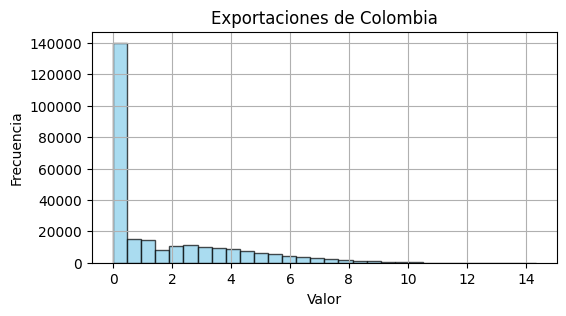

Cuantiles:
0.00     0.000000
0.25     0.000000
0.50     0.000000
0.75     2.833213
1.00    14.335977
Name: valor_log, dtype: float64


In [ ]:
# Graficar la distribución de la variable
plt.figure(figsize=(6, 3))
plt.hist(df_merge['valor_log'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Exportaciones de Colombia')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcular los cuantiles
cuantiles = df_merge['valor_log'].quantile([0, 0.25, 0.5, 0.75, 1])

# Imprimir los cuantiles
print("Cuantiles:")
print(cuantiles)

In [ ]:
df_merge['valor'].describe().T

count    2.653800e+05
mean     3.131593e+02
std      7.442702e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.600000e+01
max      1.682811e+06
Name: valor, dtype: float64

In [ ]:
df_merge['valor'].sum()

83106210

In [ ]:
país = df_merge.groupby(['país'])['valor'].sum()
país.head(2)

país
Afganistan      61
Albania       2993
Name: valor, dtype: int64

In [ ]:
# Imprimir la suma
print("La suma de la variable numérica es:", país)

La suma de la variable numérica es: país
Afganistan         61
Albania          2993
Alemania      2182336
Andorra            13
Angola          11582
               ...   
Vietnam        137677
Yemen            4686
Yibuti           6700
Zambia           2163
Zimbabue          179
Name: valor, Length: 169, dtype: int64


In [ ]:
suma_por_pais = df_merge.groupby(['país'])['valor'].sum()

# Ordenar la serie resultante en orden ascendente
suma_por_pais_ascendente = suma_por_pais.sort_values(ascending=True)

print(suma_por_pais_ascendente)

país
Uzbekistan              11
Andorra                 13
Lesoto                  13
Chad                    19
Botsuana                20
                    ...   
Mexico             4391791
Brasil             4534662
Peru               4657217
Ecuador            7929362
Estados Unidos    25163738
Name: valor, Length: 169, dtype: int64


In [ ]:
suma_por_pais_ascendente.head(169)

país
Uzbekistan              11
Andorra                 13
Lesoto                  13
Chad                    19
Botsuana                20
                    ...   
Mexico             4391791
Brasil             4534662
Peru               4657217
Ecuador            7929362
Estados Unidos    25163738
Name: valor, Length: 169, dtype: int64

## Análisis de Correlación

La correlación de Spearman es una medida de correlación no paramétrica que evalúa la relación entre las clasificaciones de dos variables en lugar de sus valores exactos. Es más apropiada cuando las variables no tienen una distribución normal o cuando hay valores atípicos presentes. También es adecuada para variables ordinales o discretas.

In [ ]:
dft5=df_merge

In [ ]:
#dft5=df_merge.drop(['valor'], axis=1)

In [ ]:
dft5['producto']=dft5['producto'].astype('object')

In [ ]:
dft5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265380 entries, 0 to 265379
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   producto             265380 non-null  object  
 1   país                 265380 non-null  object  
 2   cadena               265380 non-null  object  
 3   elasticidad          265380 non-null  object  
 4   pmi                  265380 non-null  object  
 5   rca_a                265380 non-null  object  
 6   años                 265380 non-null  object  
 7   valor                265380 non-null  int64   
 8   continent            265380 non-null  object  
 9   acuerdo              265380 non-null  object  
 10  pib_per              265380 non-null  object  
 11  ipc                  265380 non-null  object  
 12  categoria_distancia  265380 non-null  category
 13  valor_log            265380 non-null  float64 
dtypes: category(1), float64(1), int64(1), object(11)
mem

In [ ]:
dft5['categoria_distancia'].value_counts(dropna=False)

categoria_distancia
Corta      195600
Mediana     36485
Larga       33295
Name: count, dtype: int64

In [ ]:
def si_no(dft5, variables):
    dft5 = dft5.copy()
    for columna in variables:
        dft5[columna] = dft5[columna].replace({'si': 1, 'no': 0})
    return dft5

variables = ['acuerdo']

dft5_num1 = si_no(dft5, variables)

# Mapeo de valores para las columnas 'continent', 'cadena', 'ipc', 'pib_per', 'elasticidad', 'pmi', 'rca_a', 'categoria_distancia'
columnas_a_mapear = {
    'continent': {'America': 4, 'Europe': 3,  'Asia': 2, 'Africa': 1,'Pacific': 0},
    'cadena': {'Agroalimentos': 5,  'Químicos y Ciencias de la Vida': 4, 'Metalmecánica y Otras Industrias': 3, 'Sistema Moda': 2, 'Otros': 1, 'Industrias 4.0': 0},
    'ipc': {'positiva': 1, 'negativa': 0},
    'pib_per': {'positiva': 1, 'negativa': 0},
    'elasticidad': {'sign': 1, 'no sign': 0},
    'pmi': {'alto': 1, 'bajo': 0},
    'rca_a': {'alto': 1, 'bajo': 0},
    'categoria_distancia': {'Corta': 2, 'Mediana': 1, 'Larga': 0}
}

for columna, mapeo in columnas_a_mapear.items():
    dft5_num1[columna] = dft5_num1[columna].replace(mapeo)

In [ ]:
dft5_num1['categoria_distancia'].value_counts(dropna=False)

categoria_distancia
2    195600
1     36485
0     33295
Name: count, dtype: int64

In [ ]:
dft5_num1['acuerdo'].value_counts(dropna=False)

acuerdo
1    208795
0     56585
Name: count, dtype: int64

In [ ]:
dft5_num1.head(2)

producto   país  cadena  elasticidad  pmi  rca_a  años  valor  continent  \
0    10121  Aruba       5            0    1      0  2018      0          4   
1    10129  Aruba       5            0    1      0  2018      0          4   

   acuerdo  pib_per  ipc categoria_distancia  valor_log  
0        0        1    1                   2        0.0  
1        0        1    1                   2        0.0

In [ ]:
dft5_num1=dft5_num1.drop(['valor'], axis=1)

In [ ]:
dft5_num1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265380 entries, 0 to 265379
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   producto             265380 non-null  object  
 1   país                 265380 non-null  object  
 2   cadena               265380 non-null  int64   
 3   elasticidad          265380 non-null  int64   
 4   pmi                  265380 non-null  int64   
 5   rca_a                265380 non-null  int64   
 6   años                 265380 non-null  object  
 7   continent            265380 non-null  int64   
 8   acuerdo              265380 non-null  int64   
 9   pib_per              265380 non-null  int64   
 10  ipc                  265380 non-null  int64   
 11  categoria_distancia  265380 non-null  category
 12  valor_log            265380 non-null  float64 
dtypes: category(1), float64(1), int64(8), object(3)
memory usage: 24.5+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder

def convertir_num(dft5_num1, categoricas):

    dft5_num1=dft5_num1.copy()
    # Inicializar el codificador de etiquetas
    label_encoder = LabelEncoder()

    # Iterar sobre las columnas categóricas y convertirlas a numéricas
    for columna in categoricas:
        dft5_num1[columna] = label_encoder.fit_transform(dft5_num1[columna])

    return dft5_num1

In [ ]:
categoricas=dft5_num1.select_dtypes(include=['object','category']).columns

In [ ]:
df_numericas = convertir_num(dft5_num1, categoricas)
print(df_numericas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265380 entries, 0 to 265379
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   producto             265380 non-null  int64  
 1   país                 265380 non-null  int64  
 2   cadena               265380 non-null  int64  
 3   elasticidad          265380 non-null  int64  
 4   pmi                  265380 non-null  int64  
 5   rca_a                265380 non-null  int64  
 6   años                 265380 non-null  int64  
 7   continent            265380 non-null  int64  
 8   acuerdo              265380 non-null  int64  
 9   pib_per              265380 non-null  int64  
 10  ipc                  265380 non-null  int64  
 11  categoria_distancia  265380 non-null  int64  
 12  valor_log            265380 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 26.3 MB
None


In [ ]:
#numericas = df1.select_dtypes(include=['int', 'float']).columns
numericas = df_numericas.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

# Calcular la correlación de Spearman

df_correlations=df_numericas[numericas].corr(method='spearman')

In [ ]:
df_correlations


producto      país    cadena  elasticidad       pmi  \
producto             1.000000  0.000773 -0.500746     0.148977 -0.012111   
país                 0.000773  1.000000 -0.001400     0.003559 -0.007092   
cadena              -0.500746 -0.001400  1.000000    -0.083635 -0.019483   
elasticidad          0.148977  0.003559 -0.083635     1.000000 -0.105236   
pmi                 -0.012111 -0.007092 -0.019483    -0.105236  1.000000   
rca_a               -0.297110  0.013404  0.189580    -0.122067  0.252083   
años                 0.000000  0.000000  0.000000     0.000000  0.000000   
continent            0.022782 -0.021017 -0.038906     0.010226 -0.157627   
acuerdo              0.054813 -0.060259 -0.042328     0.027326 -0.096355   
pib_per              0.015570 -0.073464 -0.013327     0.007713  0.027409   
ipc                  0.034671 -0.021215 -0.024892     0.013227  0.049560   
categoria_distancia  0.022411 -0.027479 -0.033728     0.008030 -0.157013   
valor_log           -0.096163  0.000738  0.073860    -0.083695  0.185846   

                        rca_a      años  continent   acuerdo   pib_per  \
producto            -0.297110  0.000000   0.022782  0.054813  0.015570   
país                 0.013404  0.000000  -0.021017 -0.060259 -0.073464   
cadena               0.189580  0.000000  -0.038906 -0.042328 -0.013327   
elasticidad         -0.122067  0.000000   0.010226  0.027326  0.007713   
pmi                  0.252083  0.000000  -0.157627 -0.096355  0.027409   
rca_a                1.000000  0.000000  -0.108619 -0.065584  0.012566   
años                 0.000000  1.000000   0.000000  0.000000  0.164202   
continent           -0.108619  0.000000   1.000000  0.501056 -0.113464   
acuerdo             -0.065584  0.000000   0.501056  1.000000 -0.024155   
pib_per              0.012566  0.164202  -0.113464 -0.024155  1.000000   
ipc                  0.021961  0.018098  -0.115579  0.031488  0.399864   
categoria_distancia -0.108696  0.000000   0.989487  0.488682 -0.113297   
valor_log            0.202996  0.019243   0.100216  0.071076  0.013834   

                          ipc  categoria_distancia  valor_log  
producto             0.034671             0.022411  -0.096163  
país                -0.021215            -0.027479   0.000738  
cadena              -0.024892            -0.033728   0.073860  
elasticidad          0.013227             0.008030  -0.083695  
pmi                  0.049560            -0.157013   0.185846  
rca_a                0.021961            -0.108696   0.202996  
años                 0.018098             0.000000   0.019243  
continent           -0.115579             0.989487   0.100216  
acuerdo              0.031488             0.488682   0.071076  
pib_per              0.399864            -0.113297   0.013834  
ipc                  1.000000            -0.109637   0.021322  
categoria_distancia -0.109637             1.000000   0.099890  
valor_log            0.021322             0.099890   1.000000

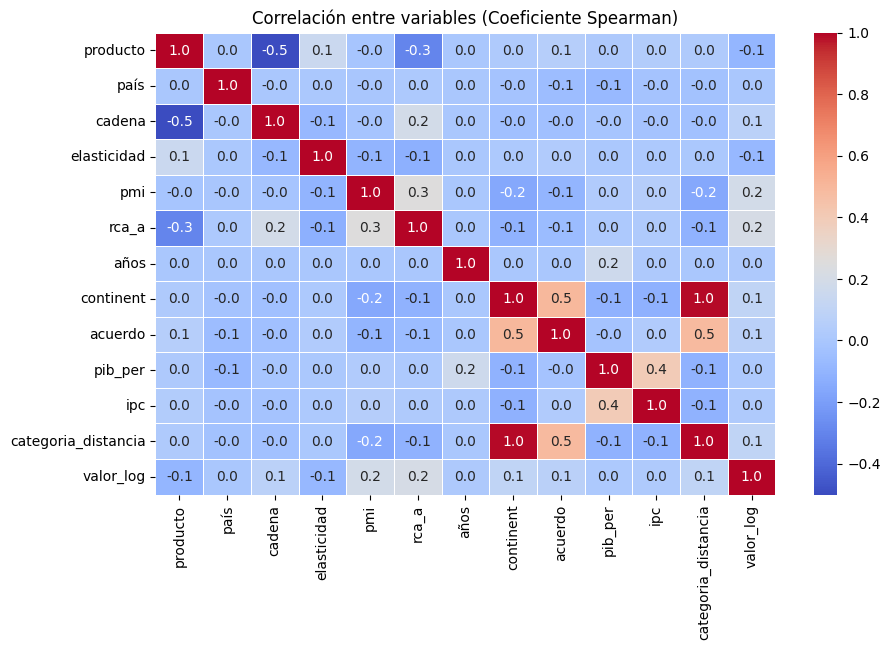

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

hfig, axes = plt.subplots(figsize=(10,6))
sns.heatmap(df_correlations, cmap = 'coolwarm', ax = axes, annot=True, linewidths=.5, fmt= '.1f')
plt.title('Correlación entre variables (Coeficiente Spearman)')
plt.show()

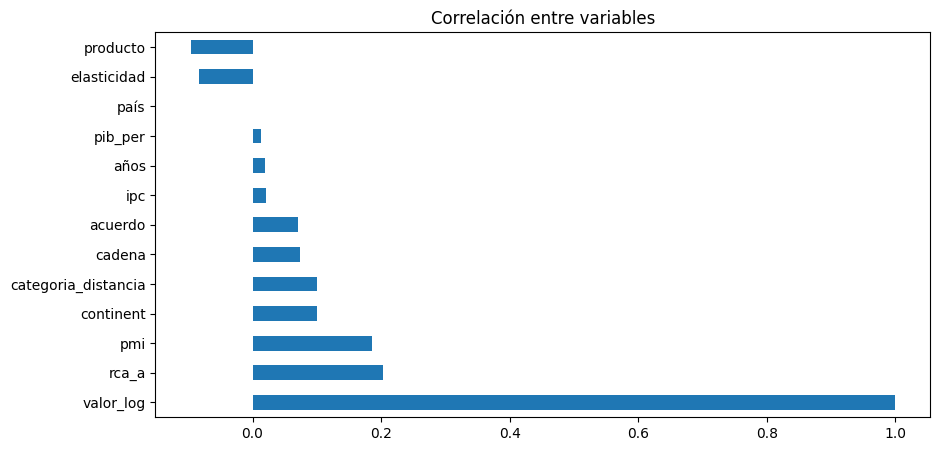

In [ ]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html

(df_correlations
     .valor_log
     .sort_values(ascending=False)
     .plot
     .barh())
plt.title('Correlación entre variables')
plt.show()

In [ ]:
df_numericas.head(2)

producto  país  cadena  elasticidad  pmi  rca_a  años  continent  acuerdo  \
0         0    11       5            0    1      0     0          4        0   
1         1    11       5            0    1      0     0          4        0   

   pib_per  ipc  categoria_distancia  valor_log  
0        1    1                    2        0.0  
1        1    1                    2        0.0

## Selección de variables

In [ ]:
dft5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265380 entries, 0 to 265379
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   producto             265380 non-null  object  
 1   país                 265380 non-null  object  
 2   cadena               265380 non-null  object  
 3   elasticidad          265380 non-null  object  
 4   pmi                  265380 non-null  object  
 5   rca_a                265380 non-null  object  
 6   años                 265380 non-null  object  
 7   valor                265380 non-null  int64   
 8   continent            265380 non-null  object  
 9   acuerdo              265380 non-null  object  
 10  pib_per              265380 non-null  object  
 11  ipc                  265380 non-null  object  
 12  categoria_distancia  265380 non-null  category
 13  valor_log            265380 non-null  float64 
dtypes: category(1), float64(1), int64(1), object(11)
mem

In [ ]:
categorical_vars = dft5.describe(include=["object","category"]).columns
continuous_vars = dft5.describe().columns

In [ ]:
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['valor', 'valor_log'], dtype='object')
categorical_vars: Index(['producto', 'país', 'cadena', 'elasticidad', 'pmi', 'rca_a', 'años',
       'continent', 'acuerdo', 'pib_per', 'ipc', 'categoria_distancia'],
      dtype='object')


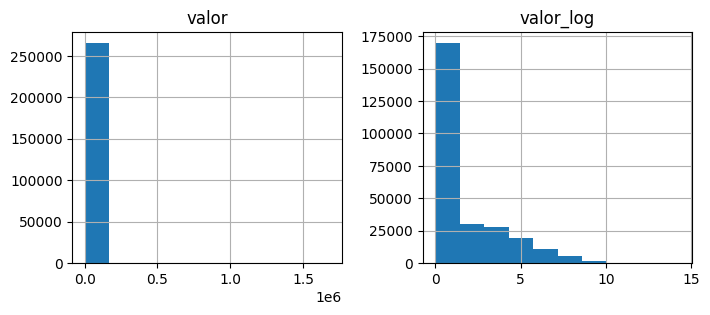

In [ ]:
# gráfico de barras de frecuencias relativas  #https://matplotlib.org/stable/tutorials/pyplot.html

_ = dft5.hist(column=continuous_vars, figsize=(8,3))

In [ ]:
dft5[continuous_vars].describe().T

count        mean          std  min  25%  50%        75%  \
valor      265380.0  313.159281  7442.701864  0.0  0.0  0.0  16.000000   
valor_log  265380.0    1.578336     2.217390  0.0  0.0  0.0   2.833213   

                    max  
valor      1.682811e+06  
valor_log  1.433598e+01

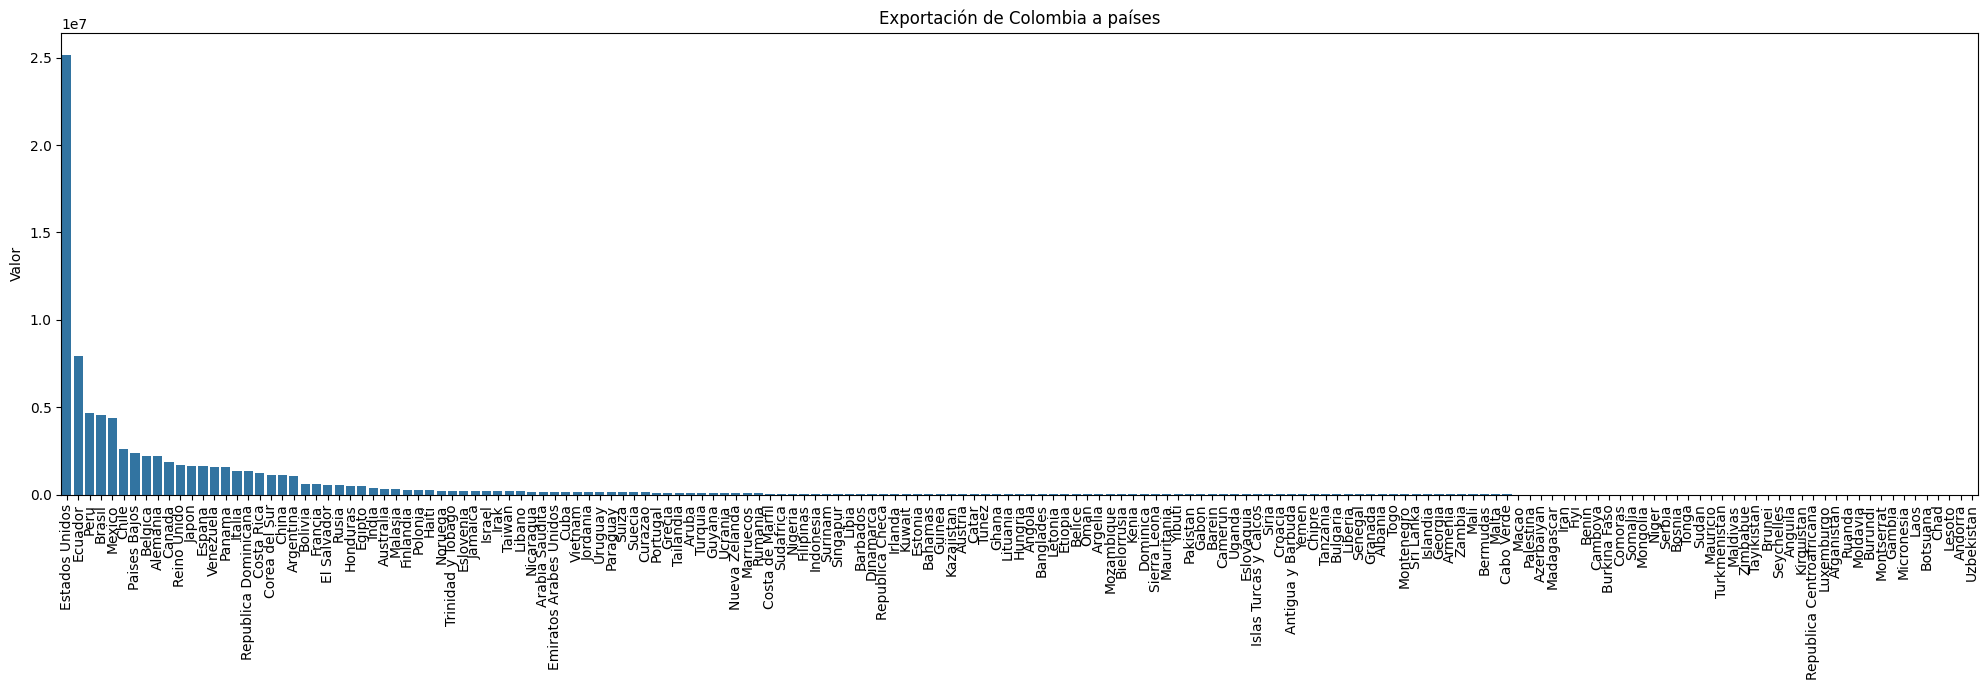

In [ ]:
agr = dft5[['valor','país']].groupby('país').sum()

agr = agr.sort_values('valor',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(20,7))
sns.barplot(x='país', y='valor', data=agr)
plt.title("Exportación de Colombia a países")
plt.xlabel('', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel("Valor")
plt.tight_layout()

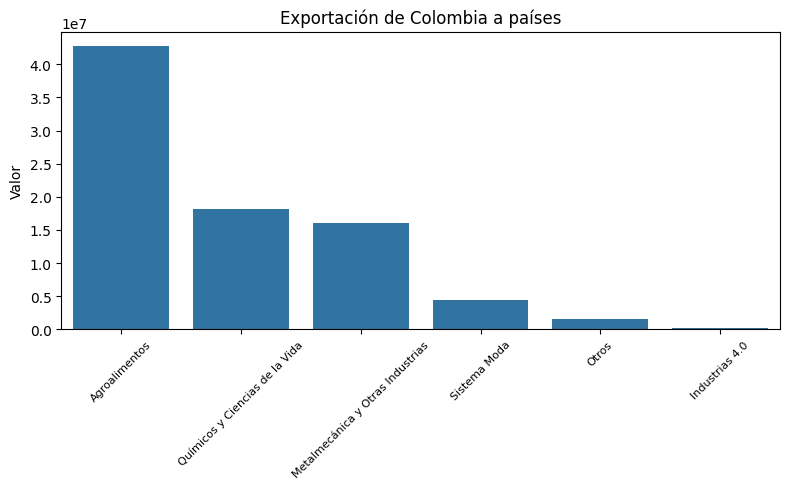

In [ ]:
agr = dft5[['valor','cadena']].groupby('cadena').sum()

agr = agr.sort_values('valor',ascending=False).reset_index(drop=False)
#agr = agr.reset_index()

#https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(8,5))
sns.barplot(x='cadena', y='valor', data=agr)
plt.title("Exportación de Colombia a países")
plt.xlabel('', fontsize=10)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel("Valor")
plt.tight_layout()

In [ ]:
dft5b=dft5.drop(['país','producto','años'], axis=1)
categorical_vars = dft5b.describe(include=["object","category"]).columns
print('categorical_vars:',categorical_vars)

categorical_vars: Index(['cadena', 'elasticidad', 'pmi', 'rca_a', 'continent', 'acuerdo',
       'pib_per', 'ipc', 'categoria_distancia'],
      dtype='object')


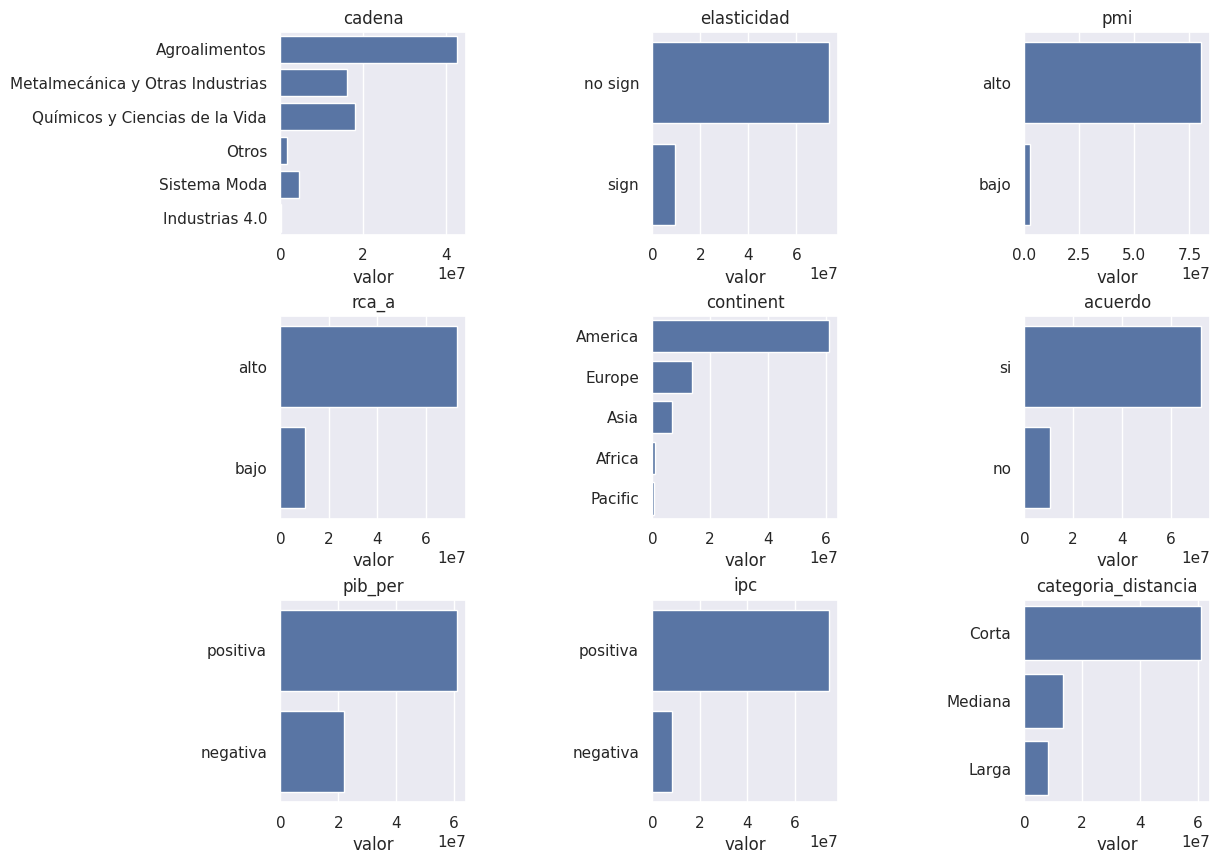

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.barplot.html

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3,3, figsize=(12,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)

for i, ax in enumerate(axes.ravel()):
    if i >10:
        ax.set_visible(False)
        continue
    sns.barplot(x='valor', y=categorical_vars[i], data=dft5b, estimator=sum, ci=None, ax=ax, order=dft5b.sort_values('valor', ascending=False)[categorical_vars[i]])
    ax.set_ylabel('')
    ax.set_title(categorical_vars[i])

### Factor de Inflación Varianza


Se propone hacer uso del método *VIF (Variance Inflation Factor)* donde el
*VIF* es un número que determina si una variable tiene multicolinealidad o no. Ese número también representa cuánto se infla una variable debido a la dependencia lineal con otras variables. Esto nos ayuda a determinar el conjunto de variables con el que deberíamos trabajar para los modelos no supervisados.

En términos de multicolinealidad, existen variables relacionadas entre sí y para eliminar variables son todas aquellas mayores a 5.

In [ ]:
#Normalización de los datos
#http://scikit-learn.org/stable/modules/preprocessing.html

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#from sklearn.preprocessing import StandardScaler
df_numericas_cols =  [col for col in df_numericas.columns]

X_df_numericas = scaler.fit_transform(df_numericas[df_numericas_cols])

In [ ]:
df1= pd.DataFrame(X_df_numericas)
df1.columns = df_numericas_cols
df1.head(2)

producto      país    cadena  elasticidad       pmi     rca_a      años  \
0 -1.857557 -1.430393  1.931765    -0.656363  0.521198 -0.621562 -1.414214   
1 -1.856713 -1.430393  1.931765    -0.656363  0.521198 -0.621562 -1.414214   

   continent  acuerdo   pib_per      ipc  categoria_distancia  valor_log  
0     0.5195 -1.92092  0.722047  0.49881             0.555733    -0.7118  
1     0.5195 -1.92092  0.722047  0.49881             0.555733    -0.7118

In [ ]:
# Calculacion de VIF con el conjunto de datos normalizado con MaxMinScaler     https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(df1,considered_features):

    X = df1[considered_features]
    # the calculation
    X['intercept'] = 1

    # create
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

features_selector_norm = compute_vif(df1, [x for x in df1.columns])
features_selector_norm.sort_values('VIF', ascending=False)

Variable       VIF
7             continent  6.581216
11  categoria_distancia  6.260801
8               acuerdo  1.565615
0              producto  1.558208
2                cadena  1.472190
5                 rca_a  1.252154
9               pib_per  1.243171
10                  ipc  1.218409
12            valor_log  1.137169
4                   pmi  1.128553
3           elasticidad  1.041080
6                  años  1.031496
1                  país  1.019750

In [ ]:
features_selector_norm = compute_vif(df1, [x for x in df1.columns if x not in ['continent']])
features_selector_norm.sort_values('VIF', ascending=False)

Variable       VIF
0              producto  1.556810
10  categoria_distancia  1.529869
7               acuerdo  1.479781
2                cadena  1.469803
5                 rca_a  1.252087
8               pib_per  1.242013
9                   ipc  1.210892
11            valor_log  1.137052
4                   pmi  1.128409
3           elasticidad  1.040919
6                  años  1.031478
1                  país  1.013286

### PCA


Con el fin de observar como están relacionadas las variables también se puede evaluar una representación en Análisis de componentes principales (PCA) para las variables.

In [ ]:
dfta=df_numericas.drop(['producto', 'país','valor_log'], axis=1)

In [ ]:
dftc=dfta.corr()

In [ ]:
names =  dftc.index
names

Index(['cadena', 'elasticidad', 'pmi', 'rca_a', 'años', 'continent', 'acuerdo',
       'pib_per', 'ipc', 'categoria_distancia'],
      dtype='object')

In [ ]:
# Normalizació de los datos
#http://scikit-learn.org/stable/modules/preprocessing.html

#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#features_norm1 = min_max_scaler.fit_transform(dftc)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_norm1 = scaler.fit_transform(dftc)

# Análisis de Componentes Principales
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(features_norm1)
print("Componentes lineales:\n", estimator.components_)
print("\nRatio de variabilidad: ", estimator.explained_variance_ratio_, "\n")



Componentes lineales:
 [[-0.15598375  0.07426483 -0.28954695 -0.27849362 -0.08754096  0.49007416
   0.45390935 -0.25128566 -0.23055432  0.4884548 ]
 [ 0.40130191 -0.30307655  0.26318172  0.45860799 -0.20343894  0.05365801
  -0.00538288 -0.47723123 -0.4388374   0.05377743]]

Ratio de variabilidad:  [0.38848835 0.19041899] 



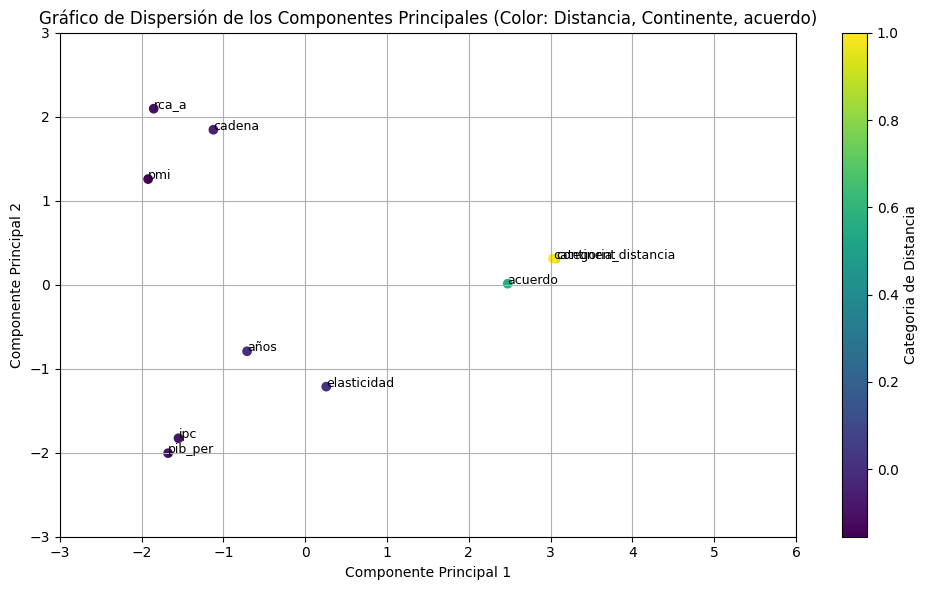

In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dftc['categoria_distancia'], cmap='viridis')
plt.colorbar(scatter, label='Categoria de Distancia')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de Dispersión de los Componentes Principales (Color: Distancia, Continente, acuerdo)')
plt.grid(True)
plt.xlim(-3, 6)
plt.ylim(-3, 3)

# Etiquetar los puntos con el nombre de las variables
for i, txt in enumerate(dftc.columns):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt, fontsize=9)

plt.tight_layout()
plt.show()



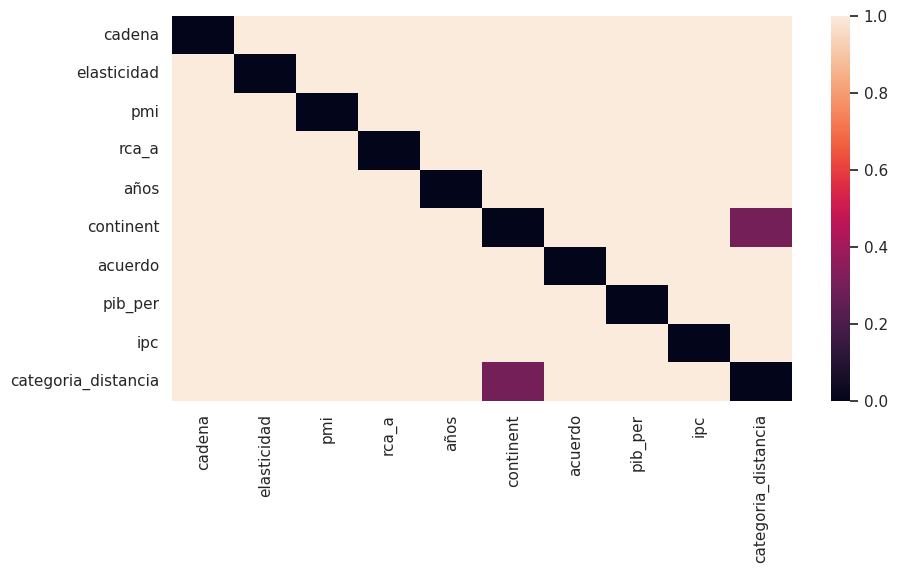

In [ ]:
# matriz de similitud
#http://docs.scipy.org/doc/scipy/reference/cluster.html
from scipy import cluster
import sklearn.metrics
dist1 = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist1= dist1.pairwise(features_norm1)

#  Visualización
import seaborn as sns; sns.set()
ax = sns.heatmap(matdist1,vmin=0, vmax=1, yticklabels = names, xticklabels = names)

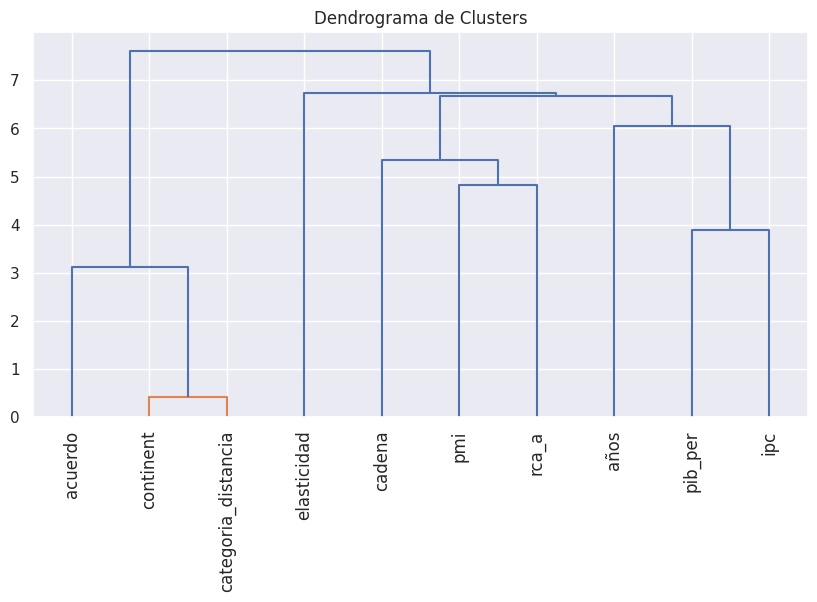

In [ ]:
#  Dendrograma
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
clusters1 = cluster.hierarchy.linkage(matdist1, method = 'single')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters1, color_threshold = 1
                             , labels = names , leaf_rotation=90)
plt.title('Dendrograma de Clusters')
plt.show()

In [ ]:
dftc

cadena   elasticidad           pmi         rca_a  \
cadena               1.000000e+00 -9.407948e-02 -1.917850e-02  2.030140e-01   
elasticidad         -9.407948e-02  1.000000e+00 -1.052357e-01 -1.220672e-01   
pmi                 -1.917850e-02 -1.052357e-01  1.000000e+00  2.520831e-01   
rca_a                2.030140e-01 -1.220672e-01  2.520831e-01  1.000000e+00   
años                 3.659534e-16 -1.799031e-16  8.155078e-16  4.396034e-16   
continent           -5.852346e-02  1.589206e-02 -1.483506e-01 -1.054620e-01   
acuerdo             -5.718786e-02  2.732622e-02 -9.635460e-02 -6.558406e-02   
pib_per             -1.055033e-02  7.712619e-03  2.740892e-02  1.256627e-02   
ipc                 -2.429676e-02  1.322706e-02  4.956007e-02  2.196126e-02   
categoria_distancia -4.853851e-02  9.467406e-03 -1.548123e-01 -1.114208e-01   

                             años     continent       acuerdo   pib_per  \
cadena               3.659534e-16 -5.852346e-02 -5.718786e-02 -0.010550   
elasticidad         -1.799031e-16  1.589206e-02  2.732622e-02  0.007713   
pmi                  8.155078e-16 -1.483506e-01 -9.635460e-02  0.027409   
rca_a                4.396034e-16 -1.054620e-01 -6.558406e-02  0.012566   
años                 1.000000e+00 -1.430751e-15 -1.203689e-15  0.164202   
continent           -1.430751e-15  1.000000e+00  5.865724e-01 -0.090003   
acuerdo             -1.203689e-15  5.865724e-01  1.000000e+00 -0.024155   
pib_per              1.642015e-01 -9.000273e-02 -2.415493e-02  1.000000   
ipc                  1.809790e-02 -1.029200e-01  3.148777e-02  0.399864   
categoria_distancia -2.380103e-15  9.152133e-01  5.590143e-01 -0.098590   

                          ipc  categoria_distancia  
cadena              -0.024297        -4.853851e-02  
elasticidad          0.013227         9.467406e-03  
pmi                  0.049560        -1.548123e-01  
rca_a                0.021961        -1.114208e-01  
años                 0.018098        -2.380103e-15  
continent           -0.102920         9.152133e-01  
acuerdo              0.031488         5.590143e-01  
pib_per              0.399864        -9.859027e-02  
ipc                  1.000000        -8.997253e-02  
categoria_distancia -0.089973         1.000000e+00

In [ ]:
cut = 1 # !!!! ad-hoc
labels1 = cluster.hierarchy.fcluster(clusters1, cut , criterion = 'distance')

labels1

array([5, 9, 3, 4, 8, 1, 2, 6, 7, 1], dtype=int32)

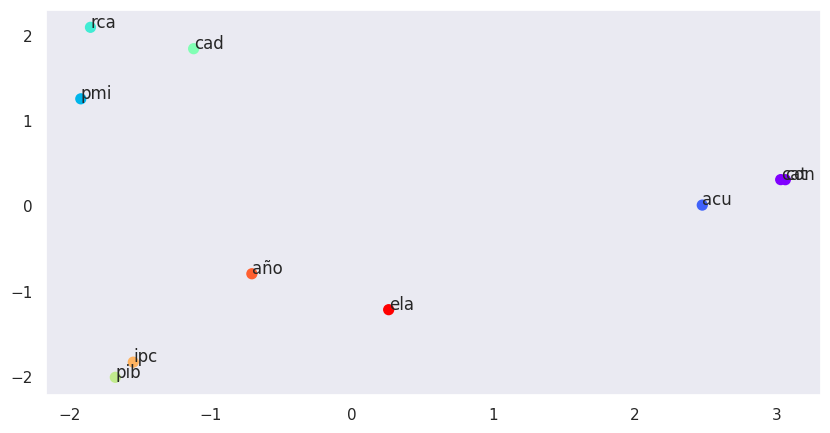

In [ ]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels1,s=50, cmap="rainbow")
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], names[i][0:3])

plt.grid()
plt.show()

## Modelamiento

In [ ]:
df_numericas

producto  país  cadena  elasticidad  pmi  rca_a  años  continent  \
0              0    11       5            0    1      0     0          4   
1              1    11       5            0    1      0     0          4   
2              1    11       5            0    0      0     0          4   
3             36    11       5            0    1      1     0          4   
4             38    11       5            0    1      1     0          4   
...          ...   ...     ...          ...  ...    ...   ...        ...   
265375      3207    31       3            1    1      0     3          1   
265376      3219    31       3            0    1      1     3          1   
265377      3198    31       3            0    1      0     4          1   
265378      3207    31       3            1    1      0     4          1   
265379      3219    31       3            0    1      1     4          1   

        acuerdo  pib_per  ipc  categoria_distancia  valor_log  
0             0        1    1                    2   0.000000  
1             0        1    1                    2   0.000000  
2             0        1    1                    2   0.000000  
3             0        1    1                    2   0.000000  
4             0        1    1                    2   1.098612  
...         ...      ...  ...                  ...        ...  
265375        0        1    1                    0   2.708050  
265376        0        1    1                    0   1.609438  
265377        0        0    1                    0   0.000000  
265378        0        0    1                    0   0.000000  
265379        0        0    1                    0   0.000000  

[265380 rows x 13 columns]

In [ ]:
dftb=df_numericas.drop(["continent"], axis=1)

In [ ]:
dftb = dftb[dftb['valor_log'] >0]

In [ ]:
dftb = dftb.loc[dftb['años'] == 4]

In [ ]:
dftb=dftb.drop(["años"], axis=1)

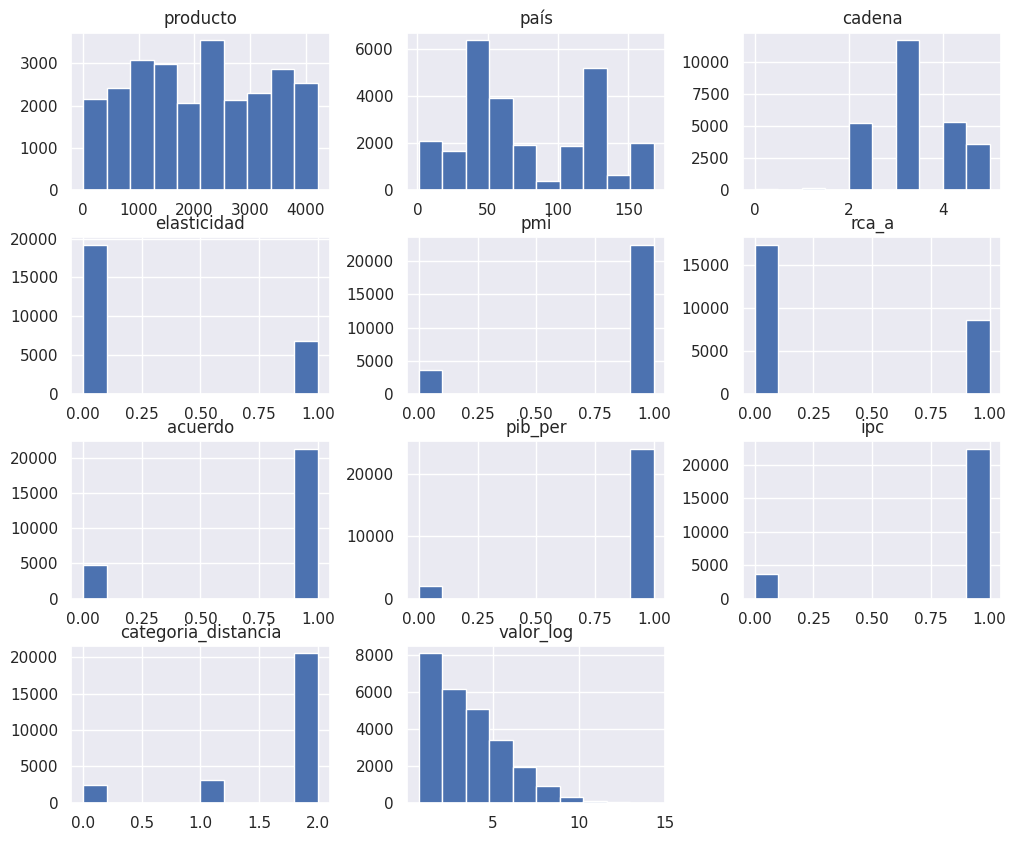

In [ ]:
_ = dftb.hist(figsize=(12,10))

In [ ]:
dftb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26054 entries, 4461 to 265364
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   producto             26054 non-null  int64  
 1   país                 26054 non-null  int64  
 2   cadena               26054 non-null  int64  
 3   elasticidad          26054 non-null  int64  
 4   pmi                  26054 non-null  int64  
 5   rca_a                26054 non-null  int64  
 6   acuerdo              26054 non-null  int64  
 7   pib_per              26054 non-null  int64  
 8   ipc                  26054 non-null  int64  
 9   categoria_distancia  26054 non-null  int64  
 10  valor_log            26054 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 2.4 MB


In [ ]:
# Supongamos que df es tu DataFrame
column_names = dftb.columns.tolist()
print(column_names)

['producto', 'país', 'cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc', 'categoria_distancia', 'valor_log']


In [ ]:
#folderResults = '/content/drive/MyDrive/project_procolombia/Files/Resultados/'

In [ ]:
#dftb.to_csv(folderResults + 'dataset.csv', index=False)

### K-means

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


scaler = StandardScaler()
scaled_data = scaler.fit_transform(dftb)

# Aplica PCA para reducir la dimensionalidad
pca = PCA(n_components=2)  # Reducir a 2 componentes para visualización
pca_data = pca.fit_transform(scaled_data)

In [ ]:
print("Componentes lineales:\n", pca.components_)
print("\nRatio de variabilidad: ", pca.explained_variance_ratio_, "\n")

Componentes lineales:
 [[-0.49635758  0.04250042  0.46365206 -0.20421518  0.19350574  0.47378906
  -0.22947395 -0.07715666 -0.08124452 -0.24517158  0.32848749]
 [-0.00599315  0.42648654  0.0041135   0.0175218  -0.12545914 -0.10671904
  -0.09507215 -0.66383377 -0.56294556  0.08432216 -0.12995582]]

Ratio de variabilidad:  [0.19809632 0.15434769] 



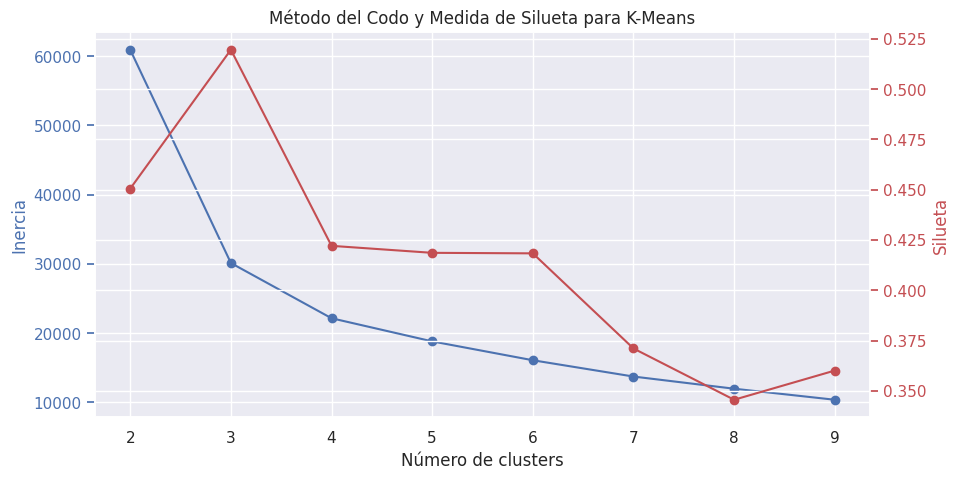

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Inicializa las listas para almacenar los valores de la inercia y la silueta
inertia = []
silhouette = []

# Calcula la inercia y la silueta para diferentes números de clusters
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42,n_init=10)
    kmeans.fit(pca_data)

    # Calcula la inercia
    inertia.append(kmeans.inertia_)

    # Calcula la silueta
    silhouette.append(silhouette_score(pca_data, kmeans.labels_))

# Grafica la curva de codo y la medida de la silueta
fig, ax1 = plt.subplots()

# Curva de codo
ax1.plot(range(2, 10), inertia, marker='o', label='Inercia', color='b')
ax1.set_xlabel('Número de clusters')
ax1.set_ylabel('Inercia', color='b')
ax1.tick_params('y', colors='b')

# Segunda gráfica para la silueta
ax2 = ax1.twinx()
ax2.plot(range(2, 10), silhouette, marker='o', label='Silueta', color='r')
ax2.set_ylabel('Silueta', color='r')
ax2.tick_params('y', colors='r')

plt.title('Método del Codo y Medida de Silueta para K-Means')
plt.show()

In [ ]:
print(inertia)

[60915.27443883146, 30102.774094433837, 22126.53934802093, 18783.613197801744, 16057.90752878477, 13703.461066376072, 11944.883305781346, 10350.801106265724]


In [ ]:
print(silhouette)

[0.4504769878695817, 0.5195077934425483, 0.42205354367197057, 0.41858011485957985, 0.41832010073042863, 0.3710461946081505, 0.3455639468202148, 0.3600717647350453]


In [ ]:
from sklearn.cluster import KMeans

# Basado en la curva de codo, selecciona el número óptimo de clusters
n_clusters = 3

# Aplica K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(pca_data)
clusters = kmeans.predict(pca_data)

#Interpreta los clusters
# Añade los clusters al DataFrame original
dftb['cluster'] = clusters

Clúster 1 - Centroide: [ 1.67733664 -0.45898043]
Clúster 2 - Centroide: [-0.93155701 -0.23537189]
Clúster 3 - Centroide: [0.52421312 4.06714812]


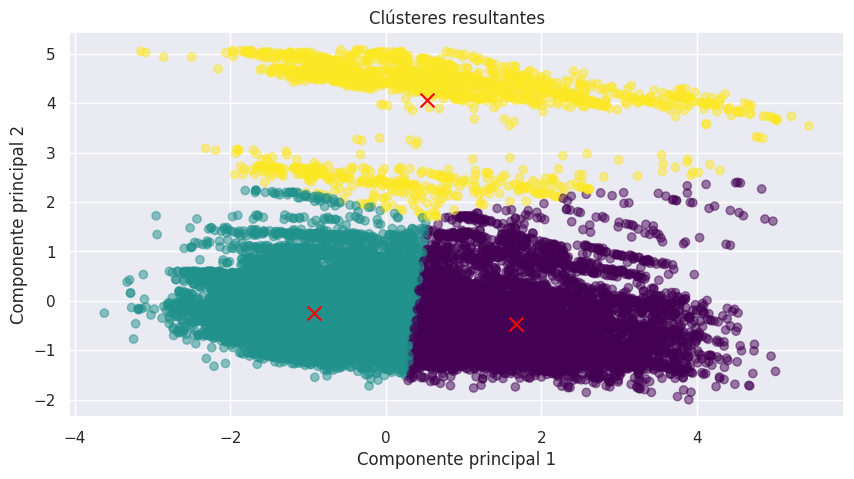

In [ ]:
# Analiza los clusters resultantes
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    print(f'Clúster {i+1} - Centroide: {center}')

# Visualiza los clusters en el espacio reducido por PCA
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=100)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clústeres resultantes')
plt.show()

### Validación


In [ ]:
# generar los grupos
labels = kmeans.labels_

In [ ]:
# organizar el dataframe original
#dftk=dft5.drop(['ipc','categoria_distancia',"continent","valor_log"], axis=1)

dftk=dft5.drop(["continent","valor_log"], axis=1)

dftk = dftk[dftk['valor'] >0]

dftk = dftk.loc[dftk['años'] =='2022']

# Añadir las etiquetas al DataFrame original
dftk['cluster'] = labels

In [ ]:
# validar los datos
dftk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26054 entries, 4461 to 265364
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   producto             26054 non-null  object  
 1   país                 26054 non-null  object  
 2   cadena               26054 non-null  object  
 3   elasticidad          26054 non-null  object  
 4   pmi                  26054 non-null  object  
 5   rca_a                26054 non-null  object  
 6   años                 26054 non-null  object  
 7   valor                26054 non-null  int64   
 8   acuerdo              26054 non-null  object  
 9   pib_per              26054 non-null  object  
 10  ipc                  26054 non-null  object  
 11  categoria_distancia  26054 non-null  category
 12  cluster              26054 non-null  int32   
dtypes: category(1), int32(1), int64(1), object(10)
memory usage: 2.5+ MB


In [ ]:
dftk.head(5)

producto   país         cadena elasticidad   pmi rca_a  años  valor  \
4461    10129  Aruba  Agroalimentos     no sign  alto  bajo  2022      7   
4465    30219  Aruba  Agroalimentos        sign  bajo  bajo  2022      1   
4466    30299  Aruba  Agroalimentos     no sign  bajo  bajo  2022      3   
4469    30369  Aruba  Agroalimentos     no sign  bajo  bajo  2022      3   
4470    30399  Aruba  Agroalimentos     no sign  bajo  bajo  2022    223   

     acuerdo   pib_per       ipc categoria_distancia  cluster  
4461      no  positiva  negativa               Corta        0  
4465      no  positiva  negativa               Corta        0  
4466      no  positiva  negativa               Corta        0  
4469      no  positiva  negativa               Corta        0  
4470      no  positiva  negativa               Corta        0

In [ ]:
categorical_vars = dftk.describe(include=["object","category"]).columns
continuous_vars = dftk.describe().columns
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['valor', 'cluster'], dtype='object')
categorical_vars: Index(['producto', 'país', 'cadena', 'elasticidad', 'pmi', 'rca_a', 'años',
       'acuerdo', 'pib_per', 'ipc', 'categoria_distancia'],
      dtype='object')


In [ ]:
dftk[continuous_vars].describe().T

count        mean           std  min  25%   50%    75%        max
valor    26054.0  812.157442  14338.548401  1.0  4.0  22.0  125.0  1682811.0
cluster  26054.0    0.753358      0.572904  0.0  0.0   1.0    1.0        2.0

In [ ]:
# agrupar por el número de clúster
cluster_grouped = dftk.groupby('cluster')

# diccionario para almacenar los 10 primeros países por cluster
top_countries_by_cluster = {}

# Iterar sobre cada grupo de clúster
for cluster, group in cluster_grouped:
    # Ordenar el grupo por valor de exportación en orden descendente
    sorted_group = group.sort_values(by='valor', ascending=False)
    # Tomar los primeros 10 países de cada clúster
    top_countries = sorted_group.head(20)
    # Almacenar los resultados en el diccionario
    top_countries_by_cluster[cluster] = top_countries

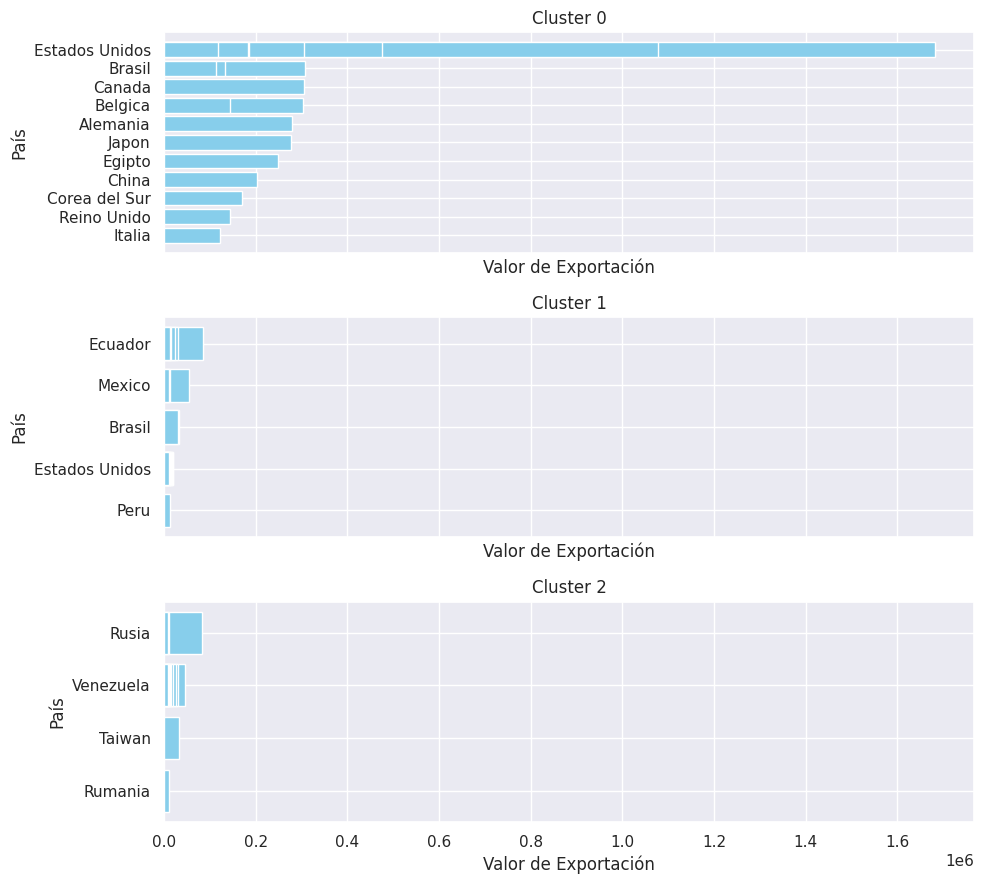

In [ ]:

# figura y ejes para la gráfica
fig, axs = plt.subplots(len(top_countries_by_cluster), figsize=(10, 9), sharex=True)

# graficar los 10 primeros países por cada cluster
for i, (cluster, top_countries) in enumerate(top_countries_by_cluster.items()):
    axs[i].barh(top_countries['país'], top_countries['valor'], color='skyblue')
    axs[i].set_title(f'Cluster {cluster}')
    axs[i].set_xlabel('Valor de Exportación')
    axs[i].set_ylabel('País')
    axs[i].invert_yaxis()

# diseño de la gráfica
plt.tight_layout()

# gráfica
plt.show()


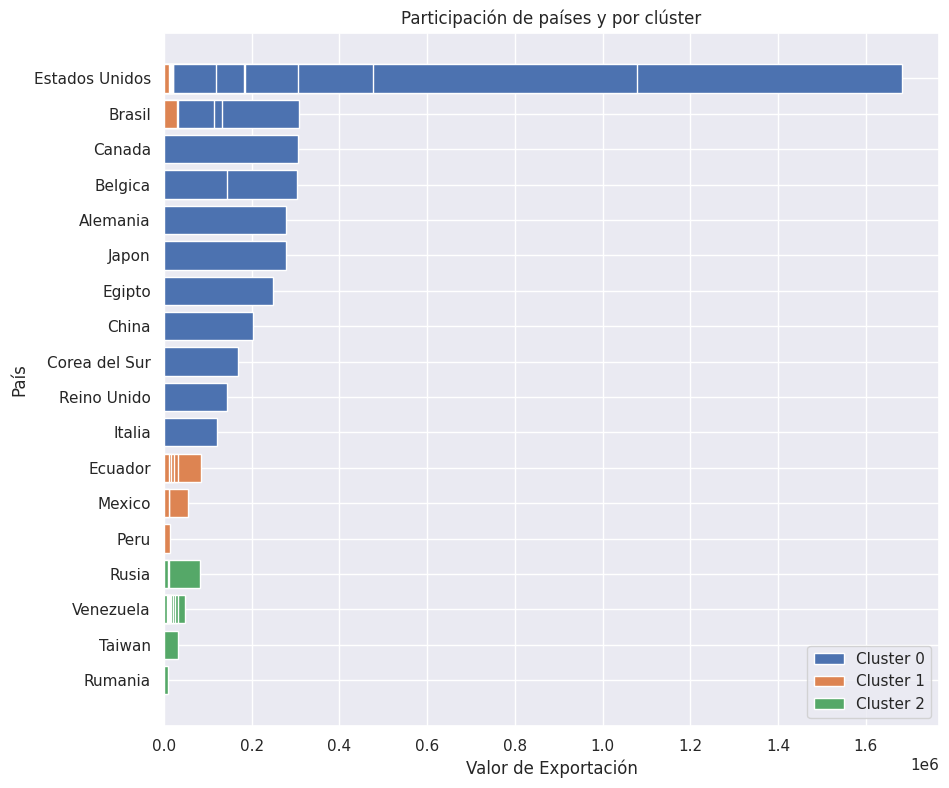

In [ ]:

# figura y ejes para la gráfica
fig, ax = plt.subplots(figsize=(10, 9))

# graficar los países en orden descendente de participación sobre cada cluster
for cluster, top_countries in top_countries_by_cluster.items():
    ax.barh(top_countries['país'], top_countries['valor'], label=f'Cluster {cluster}')

# Configurar etiquetas y leyenda
ax.set_xlabel('Valor de Exportación')
ax.set_ylabel('País')
ax.set_title('Participación de países y por clúster')
ax.legend()

# Invertir el eje y para que el país con el valor más alto esté en la parte superior
ax.invert_yaxis()

# Mostrar la gráfica
plt.show()


In [ ]:
import pandas as pd

# agrupar por el número de clúster
cluster_grouped = dftk.groupby('cluster')

# Crear un diccionario para almacenar los resultados
productos_por_cluster = {}

# Iterar sobre cada grupo de clúster
for cluster, group in cluster_grouped:
    # Ordenar el grupo por valor de exportación en orden descendente
    sorted_group = group.sort_values(by='valor', ascending=False)
    # Tomar los primeros 10 productos de cada clúster
    top_productos = sorted_group.head(10)['producto'].unique().tolist()
    # Almacenar los resultados en el diccionario
    productos_por_cluster[f'Clúster {cluster}'] = top_productos

# Convertir el diccionario a un DataFrame
df_productos = pd.DataFrame(productos_por_cluster)

# Mostrar el DataFrame
print(df_productos)


ValueError: All arrays must be of the same length

In [ ]:
# agrupar por el número de clúster
cluster_grouped = dftk.groupby('cluster')

# Crear un diccionario para almacenar los resultados
productos_por_cluster = {}

# Iterar sobre cada grupo de clúster
for cluster, group in cluster_grouped:
    # Ordenar el grupo por valor de exportación en orden descendente
    sorted_group = group.sort_values(by='valor', ascending=False)
    # Tomar los primeros 10 productos de cada clúster
    top_productos = sorted_group.head(40)['producto'].tolist()
    # Almacenar los resultados en el diccionario
    productos_por_cluster[f'Clúster {cluster}'] = top_productos

# Convertir el diccionario a un DataFrame
df_productos = pd.DataFrame(productos_por_cluster)

# Mostrar el DataFrame
print(df_productos)


    Clúster 0  Clúster 1  Clúster 2
0       90111     870323      20230
1       60319     870323     170490
2      761010     740400      90111
3      390410     880240     390210
4       60311     760200     151190
5       90111     870322     310520
6       90111     880730     961900
7       90111     852560     150790
8       90111     611030     850710
9       10229     870421     151790
10     740400     620342     230990
11     210111     610910      90111
12      80390     711719     190590
13      90111     870210      90111
14      80390     940360     390230
15      80390     870423     392010
16     380892     761699     340231
17      80390     852872      80390
18      60314     841182     340111
19     151110     760200     300490
20      60312     871120     320611
21     151110     940542      60312
22      80390     880230     722550
23      90111     940199     340250
24      90111     731210     180690
25      90121     490199     481910
26     151110     870323    

In [ ]:
## Agrupar por clúster y país, y calcular la suma del valor exportado
grouped_df = dftk.groupby(['cluster', 'país'])['valor'].sum().reset_index()

# Ordenar los países dentro de cada clúster por valor exportado de manera descendente
grouped_df['rank'] = grouped_df.groupby('cluster')['valor'].rank(ascending=False, method='dense')

# Seleccionar los primeros 10 países por clúster
top_countries_by_cluster = grouped_df[grouped_df['rank'] <= 20]


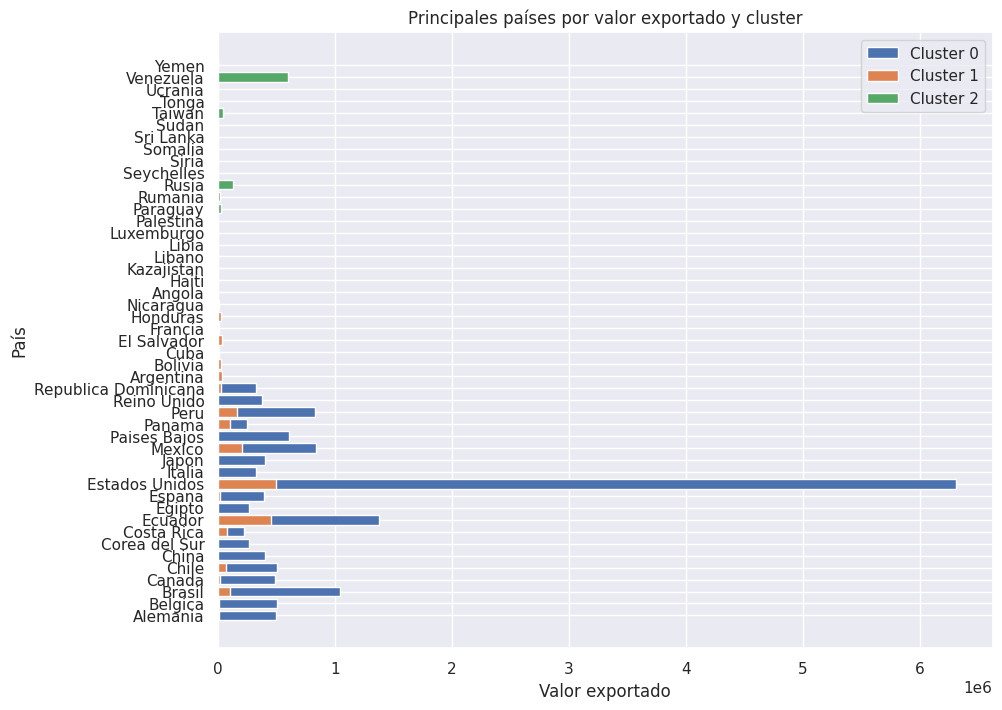

In [ ]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Iterar sobre cada clúster
for cluster, data in top_countries_by_cluster.groupby('cluster'):
    # Obtener los datos relevantes
    countries = data['país']
    values = data['valor']

    # Graficar los valores
    ax.barh(countries, values, label=f'Cluster {cluster}')

# Ajustar la apariencia de la gráfica
ax.set_xlabel('Valor exportado')
ax.set_ylabel('País')
ax.set_title('Principales países por valor exportado y cluster')
ax.legend()

# Mostrar la gráfica
plt.show()


## Visualización de resultados

In [ ]:
dftk1=dftk.copy()

In [ ]:
# Función para convertir valores numéricos a categorías

def convertir_a_categorica(valor):
    if valor >= 2:
        return "cluster 2"
    elif valor == 1:
        return "cluster 1"
    else:
        return "cluster 0"

# Aplicar la función a la columna 'cluster'
dftk1['cluster_categorico'] = dftk1['cluster'].apply(lambda x: convertir_a_categorica(x))

In [ ]:
categorical_vars = dftk1.describe(include=["object","category"]).columns
continuous_vars = dftk1.describe().columns

In [ ]:
print('continuous_vars:',continuous_vars)
print('categorical_vars:',categorical_vars)

continuous_vars: Index(['valor', 'cluster'], dtype='object')
categorical_vars: Index(['producto', 'país', 'cadena', 'elasticidad', 'pmi', 'rca_a', 'años',
       'acuerdo', 'pib_per', 'ipc', 'categoria_distancia',
       'cluster_categorico'],
      dtype='object')


In [ ]:
dftk1[continuous_vars].describe().T

count        mean           std  min  25%   50%    75%        max
valor    26054.0  812.157442  14338.548401  1.0  4.0  22.0  125.0  1682811.0
cluster  26054.0    0.753358      0.572904  0.0  0.0   1.0    1.0        2.0

<Figure size 600x300 with 0 Axes>

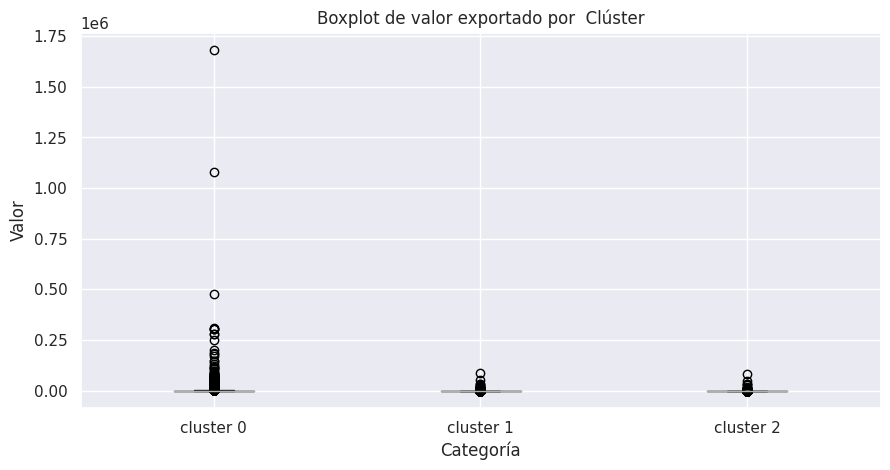

In [ ]:
## Crear la figura de matplotlib
plt.figure(figsize=(6, 3))

# Graficar el boxplot
dftk1.boxplot(column='valor', by='cluster_categorico')
plt.title('Boxplot de valor exportado por  Clúster')
plt.xlabel('Categoría')
plt.ylabel('Valor')
plt.suptitle('')
plt.show()

In [ ]:
# Agrupar por la categoría del cluster y calcular las estadísticas descriptivas para las variables continuas
stats_por_cluster = dftk1.groupby('cluster_categorico')[continuous_vars].describe().T

# Mostrar las estadísticas
print(stats_por_cluster)

cluster_categorico     cluster 0     cluster 1     cluster 2
valor   count       8.281000e+03  15918.000000   1855.000000
        mean        2.206266e+03    128.837480    452.305121
        std         2.529737e+04   1097.194804   2803.139622
        min         1.000000e+00      1.000000      1.000000
        25%         1.800000e+01      3.000000      5.000000
        50%         1.030000e+02     11.000000     22.000000
        75%         6.060000e+02     49.000000    123.500000
        max         1.682811e+06  85198.000000  82619.000000
cluster count       8.281000e+03  15918.000000   1855.000000
        mean        0.000000e+00      1.000000      2.000000
        std         0.000000e+00      0.000000      0.000000
        min         0.000000e+00      1.000000      2.000000
        25%         0.000000e+00      1.000000      2.000000
        50%         0.000000e+00      1.000000      2.000000
        75%         0.000000e+00      1.000000      2.000000
        max         0.00

In [ ]:
# Agrupar por valor exportado y la categoría de los clusters y calcular estadísticas
stats_por_cluster = dftk1.groupby(['valor', 'cluster_categorico']).agg({
    'valor': ['mean', 'median', 'min', 'max', 'std', 'count']
}).reset_index()

# Renombrar las columnas para mayor claridad
stats_por_cluster.columns = ['valor', 'cluster_categorico',
                             'mean_valor', 'median_valor', 'min_valor',
                             'max_valor', 'std_valor', 'count_valor']

# Mostrar las estadísticas
print(stats_por_cluster)

        valor cluster_categorico  mean_valor  median_valor  min_valor  \
0           1          cluster 0         1.0           1.0          1   
1           1          cluster 1         1.0           1.0          1   
2           1          cluster 2         1.0           1.0          1   
3           2          cluster 0         2.0           2.0          2   
4           2          cluster 1         2.0           2.0          2   
...       ...                ...         ...           ...        ...   
3693   306306          cluster 0    306306.0      306306.0     306306   
3694   308457          cluster 0    308457.0      308457.0     308457   
3695   476303          cluster 0    476303.0      476303.0     476303   
3696  1077606          cluster 0   1077606.0     1077606.0    1077606   
3697  1682811          cluster 0   1682811.0     1682811.0    1682811   

      max_valor  std_valor  count_valor  
0             1        0.0          424  
1             1        0.0         2327

In [ ]:
dftk1=dftk1.drop(['años','cluster_categorico','producto', 'país'], axis=1)

In [ ]:
categorical_vars = dftk1.describe(include=["object","category"]).columns

In [ ]:
print('categorical_vars:',categorical_vars)

categorical_vars: Index(['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc',
       'categoria_distancia'],
      dtype='object')


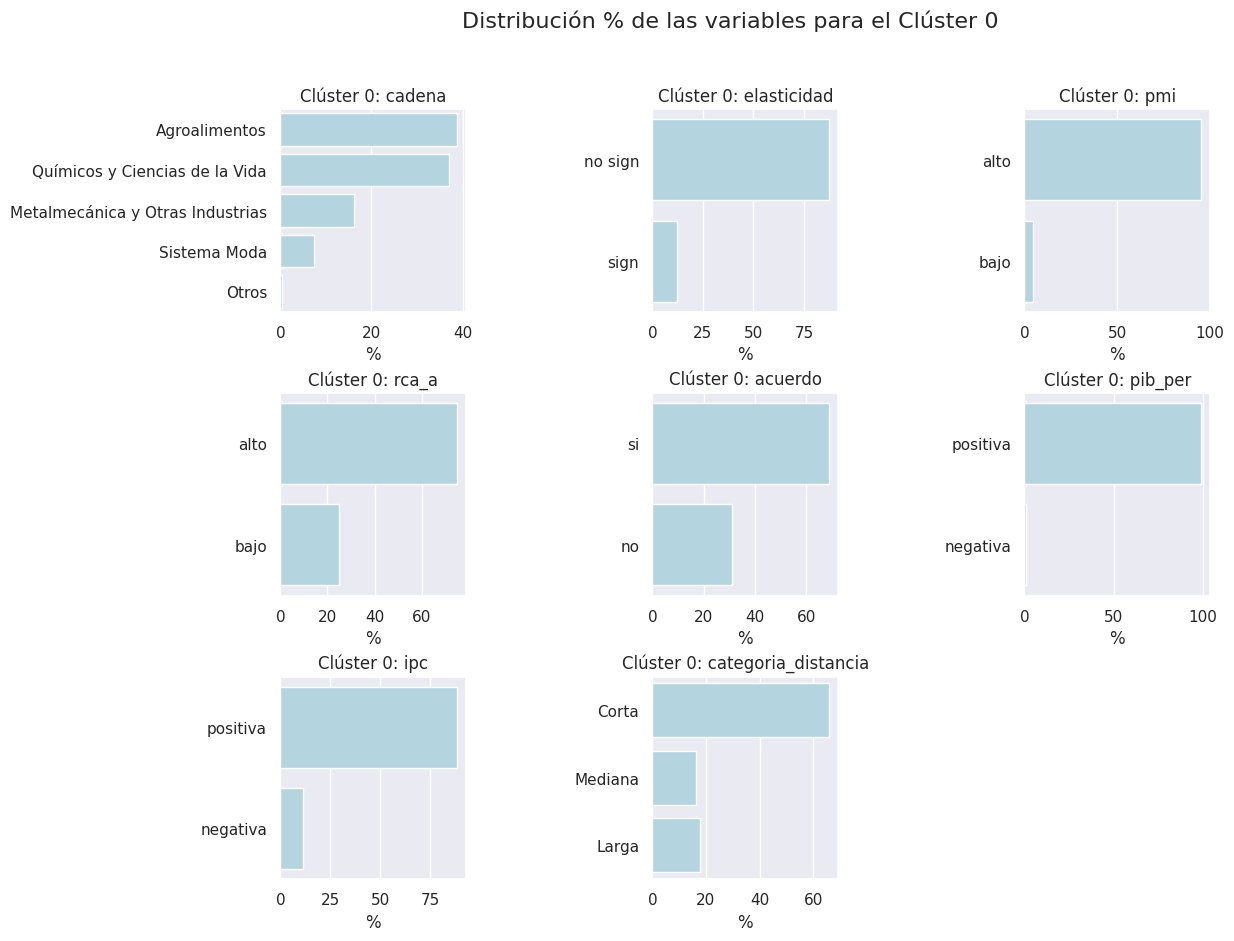

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Distribución % de las variables para el Clúster 0', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 0][current_var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Graficar el countplot ordenando las categorías
    sns.barplot(y=percentages.index, x=percentages.values, ax=ax, color='lightblue')
    ax.set_title(f'Clúster 0: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad
    ax.set_xlabel('%')

plt.show()


In [ ]:
# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear un diccionario para almacenar los resultados
percentages_by_variable = {}

# Iterar sobre cada variable categórica
for var in categorical_vars:
    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 0][var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Almacenar los resultados en el diccionario
    percentages_by_variable[var] = percentages

# Mostrar los resultados
for var, percentages in percentages_by_variable.items():
    print(f'Variable: {var}')
    print(percentages)
    print('\n')


Variable: cadena
cadena
Agroalimentos                       38.884193
Químicos y Ciencias de la Vida      37.121121
Metalmecánica y Otras Industrias    16.266151
Sistema Moda                         7.390412
Otros                                0.338123
Name: count, dtype: float64


Variable: elasticidad
elasticidad
no sign    87.610192
sign       12.389808
Name: count, dtype: float64


Variable: pmi
pmi
alto    95.531941
bajo     4.468059
Name: count, dtype: float64


Variable: rca_a
rca_a
alto    75.099626
bajo    24.900374
Name: count, dtype: float64


Variable: acuerdo
acuerdo
si    69.013404
no    30.986596
Name: count, dtype: float64


Variable: pib_per
pib_per
positiva    99.009781
negativa     0.990219
Name: count, dtype: float64


Variable: ipc
ipc
positiva    88.588335
negativa    11.411665
Name: count, dtype: float64


Variable: categoria_distancia
categoria_distancia
Corta      66.078976
Larga      17.727328
Mediana    16.193696
Name: count, dtype: float64




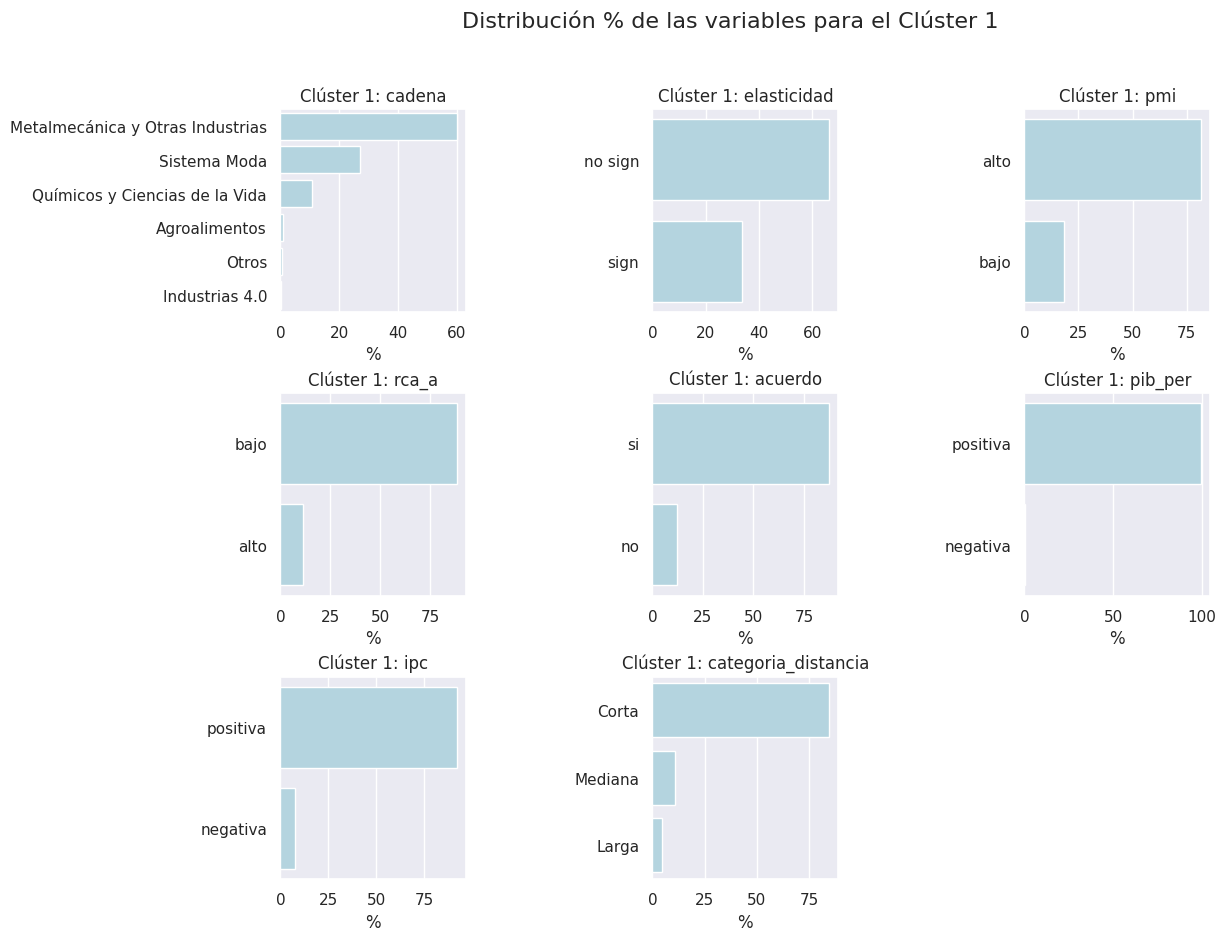

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Distribución % de las variables para el Clúster 1', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 1][current_var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Graficar el countplot ordenando las categorías
    sns.barplot(y=percentages.index, x=percentages.values, ax=ax, color='lightblue')
    ax.set_title(f'Clúster 1: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad
    ax.set_xlabel('%')

plt.show()

In [ ]:
# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear un diccionario para almacenar los resultados
percentages_by_variable = {}

# Iterar sobre cada variable categórica
for var in categorical_vars:
    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 1][var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Almacenar los resultados en el diccionario
    percentages_by_variable[var] = percentages

# Mostrar los resultados
for var, percentages in percentages_by_variable.items():
    print(f'Variable: {var}')
    print(percentages)
    print('\n')

Variable: cadena
cadena
Metalmecánica y Otras Industrias    60.221133
Sistema Moda                        27.101395
Químicos y Ciencias de la Vida      10.924739
Agroalimentos                        0.804121
Otros                                0.653348
Industrias 4.0                       0.295263
Name: count, dtype: float64


Variable: elasticidad
elasticidad
no sign    66.453072
sign       33.546928
Name: count, dtype: float64


Variable: pmi
pmi
alto    81.787913
bajo    18.212087
Name: count, dtype: float64


Variable: rca_a
rca_a
bajo    88.723458
alto    11.276542
Name: count, dtype: float64


Variable: acuerdo
acuerdo
si    87.605227
no    12.394773
Name: count, dtype: float64


Variable: pib_per
pib_per
positiva    99.648197
negativa     0.351803
Name: count, dtype: float64


Variable: ipc
ipc
positiva    92.367132
negativa     7.632868
Name: count, dtype: float64


Variable: categoria_distancia
categoria_distancia
Corta      84.621184
Mediana    10.943586
Larga       4.435231

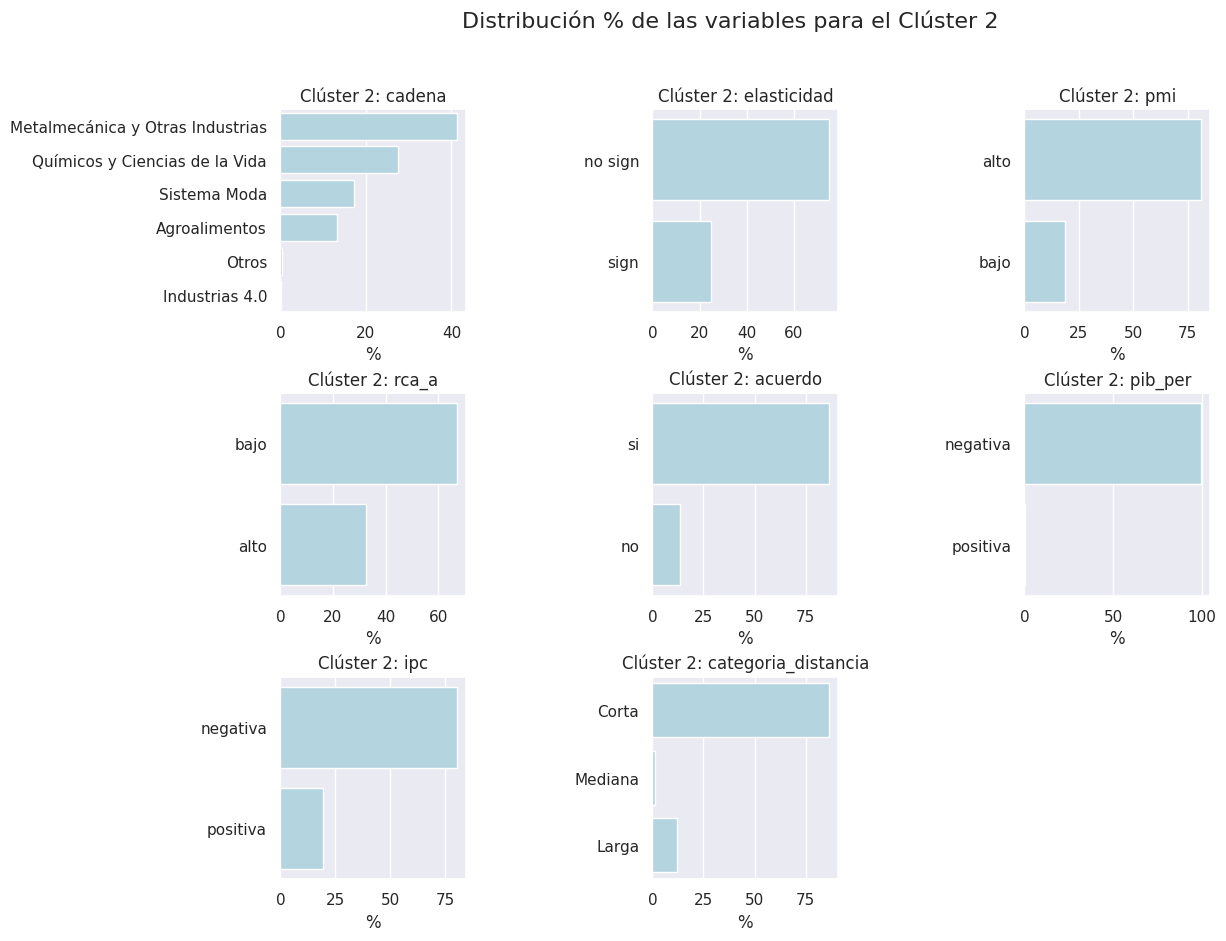

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Distribución % de las variables para el Clúster 2', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 2][current_var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Graficar el countplot ordenando las categorías
    sns.barplot(y=percentages.index, x=percentages.values, ax=ax, color='lightblue')
    ax.set_title(f'Clúster 2: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad
    ax.set_xlabel('%')

plt.show()

In [ ]:
# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear un diccionario para almacenar los resultados
percentages_by_variable = {}

# Iterar sobre cada variable categórica
for var in categorical_vars:
    # Obtener la frecuencia de cada categoría basada en el valor exportado
    value_counts = dftk1[dftk1['cluster'] == 2][var].value_counts()

    # Calcular el porcentaje de cada categoría
    percentages = value_counts / value_counts.sum() * 100

    # Almacenar los resultados en el diccionario
    percentages_by_variable[var] = percentages

# Mostrar los resultados
for var, percentages in percentages_by_variable.items():
    print(f'Variable: {var}')
    print(percentages)
    print('\n')

Variable: cadena
cadena
Metalmecánica y Otras Industrias    41.401617
Químicos y Ciencias de la Vida      27.547170
Sistema Moda                        17.142857
Agroalimentos                       13.207547
Otros                                0.485175
Industrias 4.0                       0.215633
Name: count, dtype: float64


Variable: elasticidad
elasticidad
no sign    75.040431
sign       24.959569
Name: count, dtype: float64


Variable: pmi
pmi
alto    81.401617
bajo    18.598383
Name: count, dtype: float64


Variable: rca_a
rca_a
bajo    67.331536
alto    32.668464
Name: count, dtype: float64


Variable: acuerdo
acuerdo
si    86.630728
no    13.369272
Name: count, dtype: float64


Variable: pib_per
pib_per
negativa    99.838275
positiva     0.161725
Name: count, dtype: float64


Variable: ipc
ipc
negativa    80.592992
positiva    19.407008
Name: count, dtype: float64


Variable: categoria_distancia
categoria_distancia
Corta      86.630728
Larga      12.075472
Mediana     1.293801

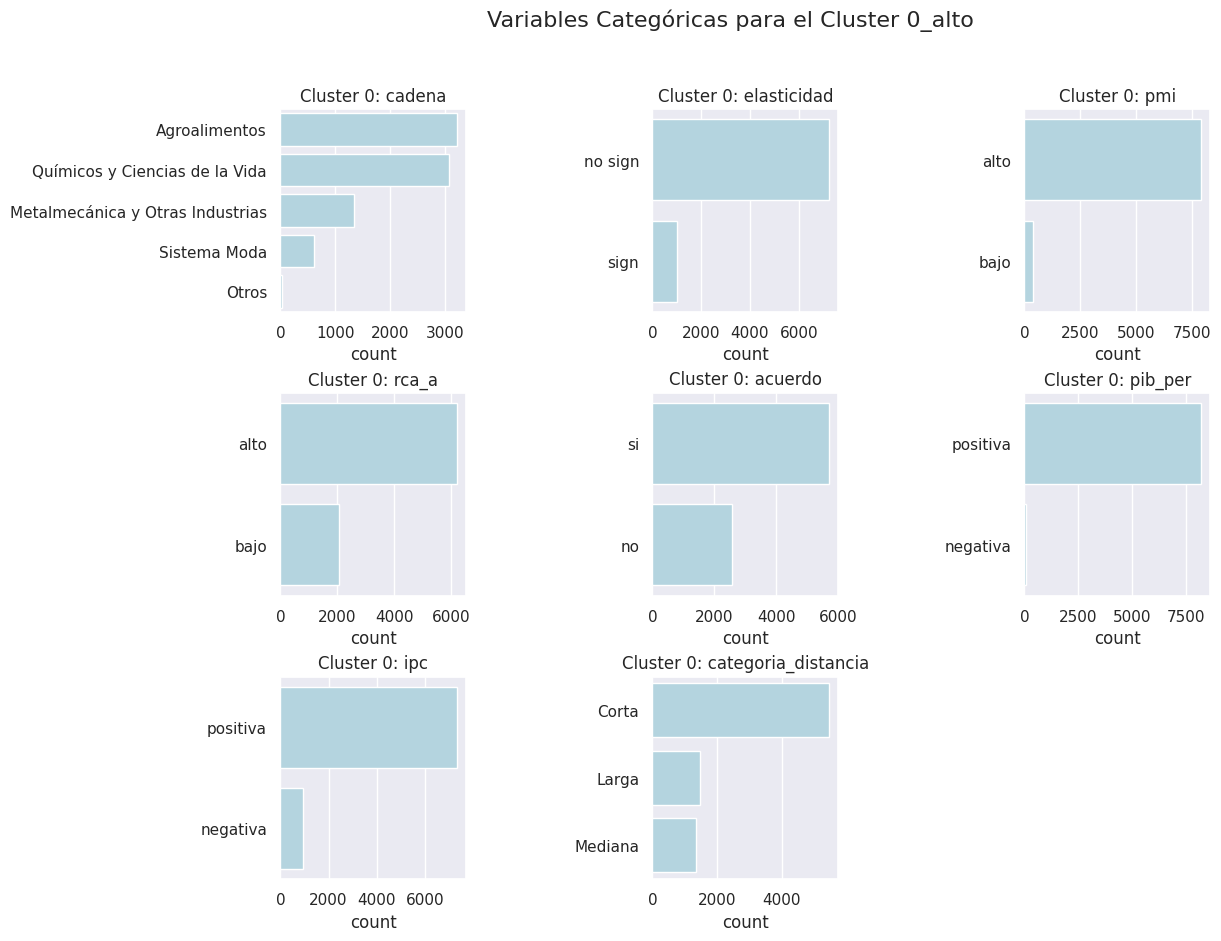

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Variables Categóricas para el Cluster 0_alto', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener el orden de las categorías basado en la frecuencia en el cluster 1
    ordered_categories = dftk1[dftk1['cluster'] == 0][current_var].value_counts().index

    # Graficar el countplot ordenando las categorías
    sns.countplot(y=current_var, data=dftk1[dftk1['cluster'] == 0], ax=ax, order=ordered_categories, color='lightblue')
    ax.set_title(f'Cluster 0: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad

plt.show()

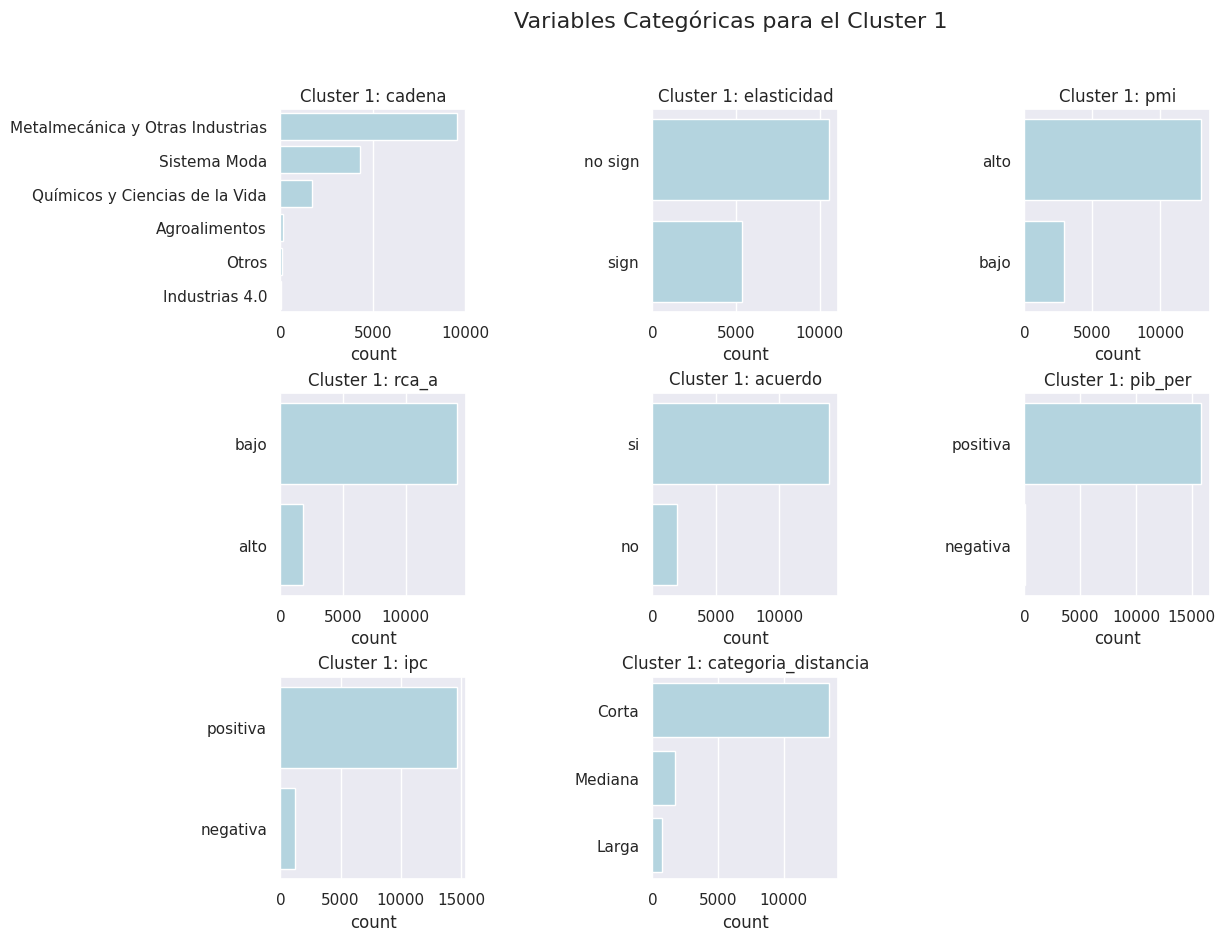

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Variables Categóricas para el Cluster 1', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener el orden de las categorías basado en la frecuencia en el cluster 1
    ordered_categories = dftk1[dftk1['cluster'] == 1][current_var].value_counts().index

    # Graficar el countplot ordenando las categorías
    sns.countplot(y=current_var, data=dftk1[dftk1['cluster'] == 1], ax=ax, order=ordered_categories, color='lightblue')
    ax.set_title(f'Cluster 1: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad

plt.show()



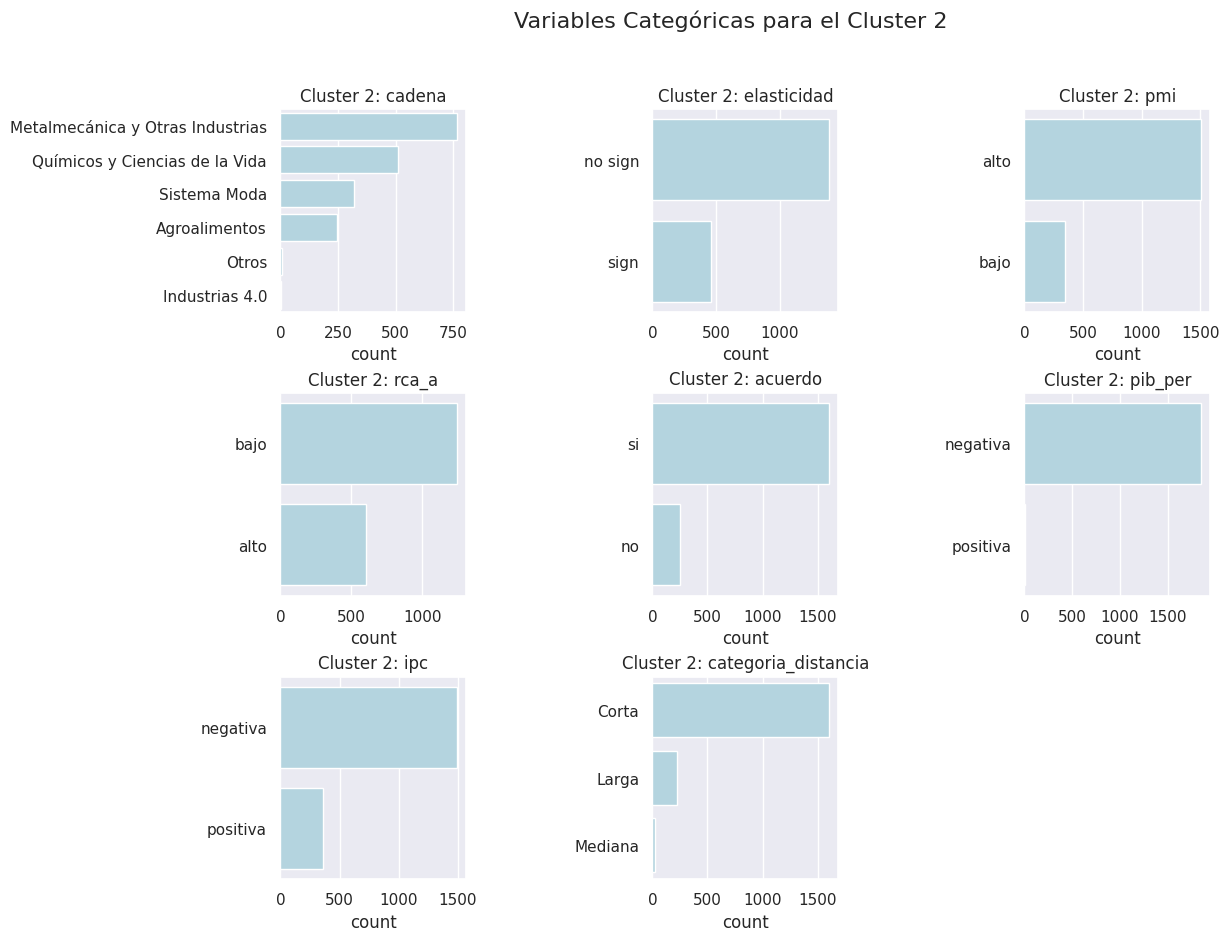

In [ ]:
import seaborn as sns

# Supongamos que tienes una lista llamada categorical_vars que contiene las variables categóricas
categorical_vars = ['cadena', 'elasticidad', 'pmi', 'rca_a', 'acuerdo', 'pib_per', 'ipc','categoria_distancia']

# Crear una figura con subgráficos
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.4)
fig.suptitle('Variables Categóricas para el Cluster 2', fontsize=16)

# Iterar sobre los subgráficos
for i, ax in enumerate(axes.ravel()):
    if i >= len(categorical_vars):
        ax.set_visible(False)
        continue

    # Obtener la variable categórica actual
    current_var = categorical_vars[i]

    # Obtener el orden de las categorías basado en la frecuencia en el cluster 2
    ordered_categories = dftk1[dftk1['cluster'] == 2][current_var].value_counts().index

    # Graficar el countplot ordenando las categorías
    sns.countplot(y=current_var, data=dftk1[dftk1['cluster'] == 2], ax=ax, order=ordered_categories, color='lightblue')
    ax.set_title(f'Cluster 2: {current_var}')
    ax.set_ylabel('')  # Eliminar la etiqueta del eje y para mayor claridad

plt.show()

In [ ]:
dftk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26054 entries, 4461 to 265364
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   producto             26054 non-null  object  
 1   país                 26054 non-null  object  
 2   cadena               26054 non-null  object  
 3   elasticidad          26054 non-null  object  
 4   pmi                  26054 non-null  object  
 5   rca_a                26054 non-null  object  
 6   años                 26054 non-null  object  
 7   valor                26054 non-null  int64   
 8   acuerdo              26054 non-null  object  
 9   pib_per              26054 non-null  object  
 10  ipc                  26054 non-null  object  
 11  categoria_distancia  26054 non-null  category
 12  cluster              26054 non-null  int32   
dtypes: category(1), int32(1), int64(1), object(10)
memory usage: 3.5+ MB


In [ ]:
dftk.head(2)

producto   país         cadena elasticidad   pmi rca_a  años  valor  \
4461    10129  Aruba  Agroalimentos     no sign  alto  bajo  2022      7   
4465    30219  Aruba  Agroalimentos        sign  bajo  bajo  2022      1   

     acuerdo   pib_per       ipc categoria_distancia  cluster  
4461      no  positiva  negativa               Corta        0  
4465      no  positiva  negativa               Corta        0

In [ ]:
from tableauhyperapi import HyperProcess, Telemetry, Connection, TableName, TableDefinition, SqlType, CreateMode, Inserter

folderResults = '/content/drive/MyDrive/project_procolombia/Files/Resultados/'

dftk2 = dftk

columnsText = ['producto']
for key in columnsText:
    dftk2[key] = dftk2[key].astype(str).fillna('')

# Define la estructura de la tabla en Hyper
table_definition = TableDefinition(
    table_name=TableName("public", "Extract"),
    columns=[
        TableDefinition.Column(name="producto", type=SqlType.text()),
        TableDefinition.Column(name="país", type=SqlType.text()),
        TableDefinition.Column(name="cadena", type=SqlType.text()),
        TableDefinition.Column(name="elasticidad", type=SqlType.text()),
        TableDefinition.Column(name="pmi", type=SqlType.text()),
        TableDefinition.Column(name="rca_a", type=SqlType.text()),
        TableDefinition.Column(name="años", type=SqlType.text()),
        TableDefinition.Column(name="acuerdo", type=SqlType.text()),
        TableDefinition.Column(name="pib_per", type=SqlType.text()),
        TableDefinition.Column(name="ipc", type=SqlType.text()),
        TableDefinition.Column(name="categoria_distancia", type=SqlType.text()),
        TableDefinition.Column(name="valor", type=SqlType.big_int()),
        TableDefinition.Column(name="cluster", type=SqlType.big_int())
    ]
)

# Función para insertar los datos en la tabla
def insert_data_into_hyper(process):
    with Connection(endpoint=process.endpoint, database=folderResults + 'prueba4.hyper', create_mode=CreateMode.CREATE_AND_REPLACE) as connection:

      # Crear la tabla en el archivo Hyper
      connection.catalog.create_table(table_definition)


      # Iniciar un inserter para agregar datos a la tabla
      with Inserter(connection, table_definition) as inserter:
        # Insertar filas de datos en la tabla a partir del DataFrame
        #inserter.add_rows_from_iterator(dftk2.itertuples(index=False, name=None))

        # Insertar filas de datos en la tabla a partir del DataFrame
        for index, row in dftk2.iterrows():
          inserter.add_row([row['producto'], row['país'], row['cadena'], row['elasticidad'], row['pmi'], row['rca_a'], row['años'], row['acuerdo'], row['pib_per'], row['ipc'], row['categoria_distancia'], row['valor'], row['cluster']])

        # Finalizar la inserción de datos
        inserter.execute()


# Proceso principal para exportar los datos
def export_data_to_hyper():
    with HyperProcess(telemetry=Telemetry.SEND_USAGE_DATA_TO_TABLEAU) as process:
        insert_data_into_hyper(process)


# Exportar los datos
export_data_to_hyper()


print(f"Archivo Hyper generado en Google Drive")



Archivo Hyper generado en Google Drive


## Referencias


* [Machine learning con Python y Scikit-learn
](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html)

* [*Python* 3: documentación oficial.](https://docs.python.org/3/)

* [Documento oficial](https://pandas.pydata.org/pandas-docs/stable/reference/index.html) y [Guía de usuario de *Pandas*](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)

* [*Matplotlib*: Visualization with Python](http://www.matplotlib.org)

* [scikit-learn](https://scikit-learn.org/stable/index.html)

* [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)